## TFM: ANÁLISIS Y PREDICCIÓN DE LA CALIDAD DEL AIRE EN LA COMUNIDAD DE MADRID

Alumno: Daniel de Miguel Bel



### Datos de la calidad del aire (horaria) en los municipios de la Comunidad de Madrid

Los dataset se han obtenido de la web de datos abiertos de la Comunidad de Madrid, en el siguiente enlace: 
https://datos.comunidad.madrid/dataset/calidad_aire_datos_historico

https://datos.comunidad.madrid/dataset/calidad_aire_datos_meteo_historico

Objetivo:  
- Análisis en profundidad de los datos horarios relacionados con la calidad del aire.
- Encontrar patrones importantes entre la calidad del aire y otros procesos climatológicos y ambientales.

____
### DATOS RELATIVOS A LA CALIDAD DEL AIRE

Preparación del entorno

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from scipy.stats import skew
import glob
import os

Lectura y unión de los datasets

In [2]:
ruta = 'datasets calidad aire/*.csv'

archivos_csv = glob.glob(ruta)

dataframes = []
for archivo in archivos_csv:
    try:
        df = pd.read_csv(archivo, sep=';', decimal=',')
        dataframes.append(df)
    except Exception as e:
        print(f"Error en el archivo {archivo}: {e}")

df_aire = pd.concat(dataframes, ignore_index=True)
df_aire

provincia  municipio  estacion  magnitud  punto_muestreo   ano  mes  \
0              28        102         1         1   28102001_1_38  2015    1   
1              28        102         1         6   28102001_6_48  2015    1   
2              28        102         1         7    28102001_7_8  2015    1   
3              28        102         1         8    28102001_8_8  2015    1   
4              28        102         1        10  28102001_10_49  2015    1   
...           ...        ...       ...       ...             ...   ...  ...   
593812         28         92         5         7    28092005_7_8  2025    2   
593813         28         92         5         8    28092005_8_8  2025    2   
593814         28         92         5        10  28092005_10_49  2025    2   
593815         28         92         5        12   28092005_12_8  2025    2   
593816         28         92         5        14   28092005_14_6  2025    2   

        dia    h01 v01  ...   h20 v20   h21 v21   h22 v22   h23 v23   h24 v24  
0         1    1.0   V  ...   1.0   V   1.0   V   1.0   V   1.0   V   1.0   V  
1         1    0.3   V  ...   0.3   V   0.3   V   0.3   V   0.4   V   0.4   V  
2         1    1.0   V  ...   1.0   V   1.0   V   1.0   V   1.0   V   1.0   V  
3         1   14.0   V  ...   5.0   V   3.0   V   5.0   V   8.0   V   9.0   V  
4         1    2.0   V  ...  16.0   V   4.0   V   4.0   V   6.0   V   8.0   V  
...     ...    ...  ..  ...   ...  ..   ...  ..   ...  ..   ...  ..   ...  ..  
593812   28   57.0   V  ...   2.0   V   2.0   V   2.0   V   2.0   V   2.0   V  
593813   28   79.0   V  ...  21.0   V  26.0   V  19.0   V  13.0   V  12.0   V  
593814   28   31.0   V  ...  11.0   V  13.0   V  15.0   V  11.0   V   9.0   V  
593815   28  166.0   V  ...  24.0   V  29.0   V  22.0   V  16.0   V  15.0   V  
593816   28    5.0   V  ...  75.0   V  68.0   V  74.0   V  77.0   V  78.0   V  

[593817 rows x 56 columns]

#### Limpieza, calidad y comprobación del dataframe

In [3]:
df_aire.shape

(593817, 56)

In [4]:
df_aire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593817 entries, 0 to 593816
Data columns (total 56 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   provincia       593817 non-null  int64  
 1   municipio       593817 non-null  int64  
 2   estacion        593817 non-null  int64  
 3   magnitud        593817 non-null  int64  
 4   punto_muestreo  593817 non-null  object 
 5   ano             593817 non-null  int64  
 6   mes             593817 non-null  int64  
 7   dia             593817 non-null  int64  
 8   h01             586404 non-null  float64
 9   v01             593817 non-null  object 
 10  h02             586346 non-null  float64
 11  v02             593817 non-null  object 
 12  h03             585816 non-null  float64
 13  v03             593817 non-null  object 
 14  h04             586111 non-null  float64
 15  v04             593817 non-null  object 
 16  h05             585946 non-null  float64
 17  v05       

In [5]:
df_aire.columns

Index(['provincia', 'municipio', 'estacion', 'magnitud', 'punto_muestreo',
       'ano', 'mes', 'dia', 'h01', 'v01', 'h02', 'v02', 'h03', 'v03', 'h04',
       'v04', 'h05', 'v05', 'h06', 'v06', 'h07', 'v07', 'h08', 'v08', 'h09',
       'v09', 'h10', 'v10', 'h11', 'v11', 'h12', 'v12', 'h13', 'v13', 'h14',
       'v14', 'h15', 'v15', 'h16', 'v16', 'h17', 'v17', 'h18', 'v18', 'h19',
       'v19', 'h20', 'v20', 'h21', 'v21', 'h22', 'v22', 'h23', 'v23', 'h24',
       'v24'],
      dtype='object')

La provincia es la misma para todos los registros, ya que son todos los municipios de la comunidad de Madrid, por lo que no lo necesitamos. La estación va asociada solo al municipio, por lo que tampoco nos hace falta y el punto de muestreo es una etiqueta que no considero necesaria para la predicción, ya que es una suma de números de las anteriores variables. 

Ya que las columna que contienen 'v' son únicamente para conocer la validación de los datos, no lo vamos a necesitar, ya que más adelante comprobaremos los nulos. Así que procedemos a eliminar estas columnas.

Aparte, creo que no es necesario realizar cambios de nombre en la columnas, ya que son bastante descriptivos y cumplen con el formato PEP8

In [6]:
df_aire = df_aire.drop(columns=['provincia', 'estacion', 'punto_muestreo', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24'])

Cambio la fecha a una sola columna (con dia, mes y año), elimino las 3 columnas anteriores

In [7]:
df_aire['fecha'] = pd.to_datetime(
    df_aire.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'})[['year', 'month', 'day']]
)

In [8]:
df_aire.drop(columns=['ano', 'mes', 'dia'], inplace=True)

In [9]:
df_aire

municipio  magnitud    h01   h02   h03   h04   h05   h06   h07   h08  \
0             102         1    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1             102         6    0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.3   
2             102         7    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3             102         8   14.0   9.0   7.0   4.0   3.0   3.0   2.0   2.0   
4             102        10    2.0   3.0   5.0   5.0   2.0   3.0   1.0   1.0   
...           ...       ...    ...   ...   ...   ...   ...   ...   ...   ...   
593812         92         7   57.0   3.0   2.0   2.0   2.0   3.0   NaN   NaN   
593813         92         8   79.0  43.0  16.0  17.0  20.0  27.0   NaN   NaN   
593814         92        10   31.0  25.0  17.0  11.0   9.0  13.0   9.0  12.0   
593815         92        12  166.0  48.0  19.0  20.0  23.0  31.0   NaN   NaN   
593816         92        14    5.0  28.0  53.0  50.0  47.0  40.0  30.0  22.0   

        ...   h16   h17   h18   h19   h20   h21   h22   h23   h24      fecha  
0       ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0 2015-01-01  
1       ...   0.3   0.3   0.3   0.3   0.3   0.3   0.3   0.4   0.4 2015-01-01  
2       ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0 2015-01-01  
3       ...   3.0   3.0   8.0  11.0   5.0   3.0   5.0   8.0   9.0 2015-01-01  
4       ...   3.0   2.0   3.0  12.0  16.0   4.0   4.0   6.0   8.0 2015-01-01  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...        ...  
593812  ...   3.0   3.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0 2025-02-28  
593813  ...  15.0  20.0  15.0  19.0  21.0  26.0  19.0  13.0  12.0 2025-02-28  
593814  ...   6.0   9.0   8.0   9.0  11.0  13.0  15.0  11.0   9.0 2025-02-28  
593815  ...  20.0  24.0  18.0  22.0  24.0  29.0  22.0  16.0  15.0 2025-02-28  
593816  ...  89.0  84.0  85.0  79.0  75.0  68.0  74.0  77.0  78.0 2025-02-28  

[593817 rows x 27 columns]

Para el municipio y las magnitudes de medida de contaminantes creo unos diccionarios para pasarlos a variable cualitativa, de modo que el análisis y la posterior visualización de datos sean más fáciles

In [10]:
dic_municipios = {
    5: 'ALCALÁ DE HENARES',
    6: 'ALCOBENDAS',
    7: 'ALCORCÓN',
    9: 'ALGETE',
    13: 'ARANJUEZ',
    14: 'ARGANDA DEL REY',
    16: 'ATAZAR, EL',
    45: 'COLMENAR VIEJO',
    47: 'COLLADO VILLALBA',
    49: 'COSLADA',
    58: 'FUENLABRADA',
    65: 'GETAFE',
    67: 'GUADALIX DE LA SIERRA',
    74: 'LEGANÉS',
    80: 'MAJADAHONDA',
    92: 'MÓSTOLES',
    102: 'ORUSCO DE TAJUÑA',
    106: 'PARLA',
    115: 'POZUELO DE ALARCÓN',
    120: 'PUERTO DE COTOS',
    123: 'RIVAS-VACIAMADRID',
    127: 'ROZAS, LAS',
    133: 'SAN MARTÍN DE VALDEIGLESIAS',
    134: 'SAN SEBASTIÁN DE LOS REYES',
    148: 'TORREJÓN DE ARDOZ',
    161: 'VALDEMORO',
    171: 'VILLA DEL PRADO',
    180: 'VILLAREJO DE SALVANÉS'
}

df_aire['municipio'] = df_aire['municipio'].replace(dic_municipios)

In [11]:
dic_magnitudes = {
    1: 'SO2',
    6: 'CO',
    7: 'NO',
    8: 'NO2',
    9: 'PM2.5',
    10: 'PM10',
    11: 'PM1',
    12: 'NOx',
    14: 'O3',
    20: 'Tolueno',
    22: 'Carbón',
    30: 'Benceno',
    42: 'Hidrocarburos totales',
    44: 'Hidrocarburos no metánicos',
    431: 'M/P-xileno'
}

df_aire['magnitud'] = df_aire['magnitud'].replace(dic_magnitudes)


Convertimos los datos de contaminación de cada hora a formato decimal, ya que es una variable cuantitativa continua y más tarde tendremos que hacer la imputación de nulos. Lo hacemos forzando errores como Nan, ya que sino no nos funciona

In [12]:
cols_horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]
df_aire[cols_horas] = df_aire[cols_horas].apply(pd.to_numeric, errors='coerce')

In [13]:
df_aire.dtypes

municipio            object
magnitud             object
h01                 float64
h02                 float64
h03                 float64
h04                 float64
h05                 float64
h06                 float64
h07                 float64
h08                 float64
h09                 float64
h10                 float64
h11                 float64
h12                 float64
h13                 float64
h14                 float64
h15                 float64
h16                 float64
h17                 float64
h18                 float64
h19                 float64
h20                 float64
h21                 float64
h22                 float64
h23                 float64
h24                 float64
fecha        datetime64[ns]
dtype: object

***Breve análisis de las variables y téminos estadísticos para aplicar al dataset***

Variables cuantitativas continuas (float): 

- h01, h02, h03, (...), h24: concentración del contaminante para cada hora del día del 01 al 24 (correspondiente con la hora del momento de la medición diaria). Expresado en microgramos por metro cúbico (μg/m3).


Variables cualitativas nominales (string):

- municipio: nombre del municipio de la Comunidad de Madrid para cada registro de contaminación.

- magnitud: nombre del contaminante medido en cada registro.

- fecha: dia, mes y año del registro de contaminación. Es numérico y tiene un orden, pero se considera objeto en un principio.

In [14]:
df_aire.head()

municipio magnitud   h01  h02  h03  h04  h05  h06  h07  h08  ...  \
0  ORUSCO DE TAJUÑA      SO2   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
1  ORUSCO DE TAJUÑA       CO   0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  ...   
2  ORUSCO DE TAJUÑA       NO   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
3  ORUSCO DE TAJUÑA      NO2  14.0  9.0  7.0  4.0  3.0  3.0  2.0  2.0  ...   
4  ORUSCO DE TAJUÑA     PM10   2.0  3.0  5.0  5.0  2.0  3.0  1.0  1.0  ...   

   h16  h17  h18   h19   h20  h21  h22  h23  h24      fecha  
0  1.0  1.0  1.0   1.0   1.0  1.0  1.0  1.0  1.0 2015-01-01  
1  0.3  0.3  0.3   0.3   0.3  0.3  0.3  0.4  0.4 2015-01-01  
2  1.0  1.0  1.0   1.0   1.0  1.0  1.0  1.0  1.0 2015-01-01  
3  3.0  3.0  8.0  11.0   5.0  3.0  5.0  8.0  9.0 2015-01-01  
4  3.0  2.0  3.0  12.0  16.0  4.0  4.0  6.0  8.0 2015-01-01  

[5 rows x 27 columns]

### DUPLICADOS

Comprobamos duplicados, vemos que realmente son registros iguales y procedemos a eliminarlos

In [15]:
duplicados = df_aire.duplicated().any()

print("Duplicados:", duplicados)

df_aire.duplicated().sum()

Duplicados: True


np.int64(35)

In [16]:
df_aire[df_aire.duplicated(keep=False)]

municipio magnitud    h01   h02    h03   h04   h05   h06  \
40899   RIVAS-VACIAMADRID       O3   76.0  81.0   72.0  52.0  53.0  34.0   
40900   RIVAS-VACIAMADRID       O3   76.0  81.0   72.0  52.0  53.0  34.0   
127171  RIVAS-VACIAMADRID       O3  101.0  99.0  100.0  96.0  75.0  56.0   
127172  RIVAS-VACIAMADRID       O3  101.0  99.0  100.0  96.0  75.0  56.0   
127303             ALGETE       O3   87.0  85.0   82.0  76.0  75.0  82.0   
...                   ...      ...    ...   ...    ...   ...   ...   ...   
129584             ALGETE       O3   90.0  80.0   76.0  70.0  71.0  65.0   
129603  RIVAS-VACIAMADRID       O3  102.0  95.0   93.0  85.0  78.0  74.0   
129604  RIVAS-VACIAMADRID       O3  102.0  95.0   93.0  85.0  78.0  74.0   
129735             ALGETE       O3   93.0  85.0   82.0  83.0  76.0  59.0   
129736             ALGETE       O3   93.0  85.0   82.0  83.0  76.0  59.0   

         h07   h08  ...    h16    h17    h18    h19    h20    h21   h22   h23  \
40899   47.0  50.0  ...   98.0  103.0   73.0   24.0   64.0   24.0  69.0  77.0   
40900   47.0  50.0  ...   98.0  103.0   73.0   24.0   64.0   24.0  69.0  77.0   
127171  59.0  91.0  ...  118.0  121.0  123.0  113.0   94.0   79.0  62.0  39.0   
127172  59.0  91.0  ...  118.0  121.0  123.0  113.0   94.0   79.0  62.0  39.0   
127303  74.0  82.0  ...   95.0   98.0   98.0   95.0   87.0   73.0  53.0  43.0   
...      ...   ...  ...    ...    ...    ...    ...    ...    ...   ...   ...   
129584  58.0  61.0  ...  115.0  119.0  115.0  104.0  100.0  101.0  97.0  74.0   
129603  65.0  42.0  ...  135.0  127.0   99.0   66.0   64.0   71.0  67.0  65.0   
129604  65.0  42.0  ...  135.0  127.0   99.0   66.0   64.0   71.0  67.0  65.0   
129735  65.0  80.0  ...  115.0  116.0   77.0   72.0   75.0   76.0  72.0  67.0   
129736  65.0  80.0  ...  115.0  116.0   77.0   72.0   75.0   76.0  72.0  67.0   

         h24      fecha  
40899   73.0 2015-09-27  
40900   73.0 2015-09-27  
127171  11.0 2017-05-01  
127172  11.0 2017-05-01  
127303  36.0 2017-05-01  
...      ...        ...  
129584  82.0 2017-05-16  
129603  57.0 2017-05-17  
129604  57.0 2017-05-17  
129735  68.0 2017-05-17  
129736  68.0 2017-05-17  

[70 rows x 27 columns]

In [17]:
df_aire = df_aire.drop_duplicates()

In [18]:
df_aire.duplicated().sum()

np.int64(0)

### NULOS

Vemos que no haya caracteres especiales que se pudieran considerar nulos en las variables tipo 'object'. Vemos nulos en las concentraciones por hora, pero ahora mismo nuestro análisis es horario y más adelante procederemos a trabajar únicamente con datos diarios, por lo que por el momento no vamos a realizar transfromaciones ni eliminar nada

In [19]:
for col in df_aire.select_dtypes(include=['object']).columns:
    print(col)
    print(df_aire[col].unique())

municipio
['ORUSCO DE TAJUÑA' 'RIVAS-VACIAMADRID' 'ARANJUEZ'
 'SAN MARTÍN DE VALDEIGLESIAS' 'ARGANDA DEL REY' 'TORREJÓN DE ARDOZ'
 'ATAZAR, EL' 'VALDEMORO' 'VILLA DEL PRADO' 'VILLAREJO DE SALVANÉS'
 'COLMENAR VIEJO' 'COLLADO VILLALBA' 'COSLADA' 'ALCALÁ DE HENARES'
 'FUENLABRADA' 'ALCOBENDAS' 'GETAFE' 'GUADALIX DE LA SIERRA' 'ALCORCÓN'
 'LEGANÉS' 'MAJADAHONDA' 'ALGETE' 'MÓSTOLES' 'PUERTO DE COTOS'
 'SAN SEBASTIÁN DE LOS REYES' 'POZUELO DE ALARCÓN' 'PARLA' 'ROZAS, LAS']
magnitud
['SO2' 'CO' 'NO' 'NO2' 'PM10' 'NOx' 'O3' 'PM2.5' 'Tolueno' 'Benceno'
 'Hidrocarburos totales' 'Hidrocarburos no metánicos' 'M/P-xileno']


In [20]:
nulos = df_aire.isnull().sum()
nulos

municipio        0
magnitud         0
h01           7413
h02           7471
h03           8001
h04           7706
h05           7871
h06          12180
h07          18842
h08          23919
h09          28220
h10          30058
h11          30113
h12          27740
h13          22148
h14          15541
h15          11524
h16           9797
h17           8252
h18           7467
h19           7266
h20           7139
h21           7267
h22           7891
h23           7349
h24           7442
fecha            0
dtype: int64

In [21]:
df_aire.to_csv('calidad_aire_cleaned.csv')

### ANÁLISIS DE LA CALIDAD DEL AIRE (HORARIO)

Vamos a agrupar por magnitudes para observar diferencias y similitudes entre contaminantes y las concentraciones según las horas del día. En un primer vistazo vemos que las concentraciones totales más altas se dan para el ozono, dióxido de nitrógeno (y óxidos de nitrógeno en conjunto), las particulas de 10 micrómetros (µM) o menor y las particulas de 2.5 micrómetros (µM) o menos. Las magnitudes con menores concentraciones totales son: los hidrocarburos no metánicos, el monóxido de carbono, el benceno y el MP-Xileno.

In [22]:
concentraciones_por_magnitud = df_aire.groupby('magnitud')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                           'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                           'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].mean()

concentraciones_por_magnitud.T

magnitud   Benceno        CO  Hidrocarburos no metánicos  \
h01       0.525215  0.407771                    0.173631   
h02       0.474271  0.399382                    0.171112   
h03       0.435702  0.393399                    0.168796   
h04       0.412461  0.391930                    0.167214   
h05       0.406911  0.396879                    0.167220   
h06       0.455728  0.411119                    0.171183   
h07       0.551231  0.429050                    0.178942   
h08       0.632317  0.439470                    0.183113   
h09       0.622482  0.439318                    0.178502   
h10       0.525699  0.429080                    0.168223   
h11       0.435202  0.422643                    0.159682   
h12       0.377301  0.411049                    0.153834   
h13       0.341335  0.400566                    0.150591   
h14       0.324532  0.395087                    0.147566   
h15       0.310403  0.390490                    0.147944   
h16       0.309540  0.390210                    0.147838   
h17       0.334898  0.393412                    0.149317   
h18       0.402165  0.407973                    0.158416   
h19       0.534333  0.428335                    0.170584   
h20       0.633182  0.444985                    0.177948   
h21       0.684076  0.452769                    0.182096   
h22       0.679631  0.446182                    0.179463   
h23       0.636978  0.432935                    0.179942   
h24       0.582420  0.419876                    0.176661   

magnitud  Hidrocarburos totales  M/P-xileno         NO        NO2        NOx  \
h01                    2.285375    0.945652   6.882140  18.066040  28.894806   
h02                    2.290027    0.890245   5.667102  16.048561  25.030466   
h03                    2.295428    0.835573   4.861485  14.923570  22.680532   
h04                    2.303852    0.816552   4.532995  15.131460  22.369389   
h05                    2.310874    0.793446   5.465052  18.169999  26.779056   
h06                    2.328263    0.829005   9.639301  23.972735  38.860806   
h07                    2.338441    1.002641  16.244567  27.731005  52.618371   
h08                    2.333280    1.205841  20.186372  27.233366  58.112595   
h09                    2.306627    1.243613  17.758594  23.400723  50.561651   
h10                    2.274494    1.031291  11.780120  19.017925  37.059964   
h11                    2.244264    0.810659   8.033383  15.969542  28.316213   
h12                    2.225153    0.674059   5.837343  13.918570  22.951067   
h13                    2.205373    0.590312   4.559214  12.505902  19.613218   
h14                    2.193998    0.484687   3.811818  11.645667  17.633028   
h15                    2.181306    0.432874   3.322240  11.368440  16.646336   
h16                    2.180521    0.465220   3.229684  12.355001  17.491140   
h17                    2.187883    0.548860   4.082154  15.599837  22.040954   
h18                    2.206578    0.709562   7.671727  21.802367  33.734694   
h19                    2.230962    0.936878  12.484857  28.057119  47.328731   
h20                    2.253070    1.091632  15.010779  32.234950  55.384314   
h21                    2.269801    1.163384  15.036544  32.332200  55.509910   
h22                    2.283480    1.168319  13.090109  28.858641  49.122155   
h23                    2.284516    1.095474  10.735397  24.868710  41.526360   
h24                    2.284065    1.016702   8.542768  21.092196  34.418511   

magnitud         O3       PM10      PM2.5       SO2   Tolueno  
h01       52.174224  18.314864  11.027314  1.828663  1.876935  
h02       51.632763  18.086060  10.965473  1.810785  1.841724  
h03       50.550511  17.233769  10.436393  1.796600  1.768141  
h04       48.600501  16.313838   9.773301  1.792679  1.752194  
h05       44.631045  15.871074   9.375643  1.826240  1.764189  
h06       39.270052  16.442501   9.415727  1.902952  1.810805  
h07       37.527743  17.941978   9.706873  2.01368

Es importante aquí tener en cuenta que justo los contaminantes con menos concetración total horaria son los que menos datos tenemos en el dataset

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\2910353274.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_aire, x='magnitud', palette='Set2', order=magnitudes_count)


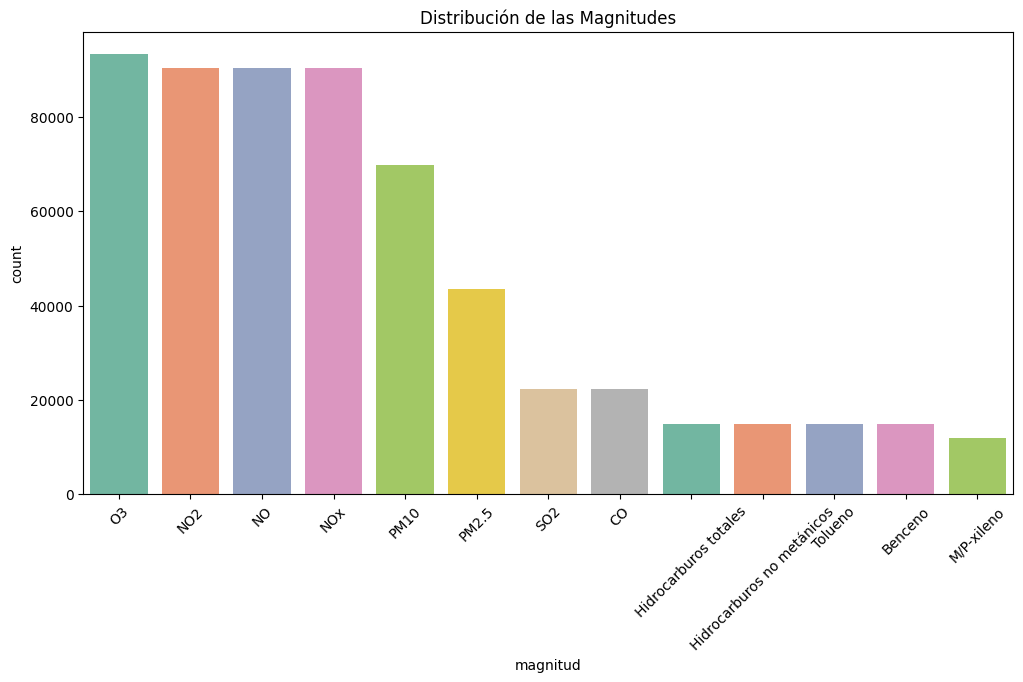

In [23]:
magnitudes_count = df_aire['magnitud'].value_counts().index
plt.figure(figsize=(12, 6))

sns.countplot(data=df_aire, x='magnitud', palette='Set2', order=magnitudes_count)
plt.xticks(rotation=45)
plt.title('Distribución de las Magnitudes')
plt.show()

Filtro a mayores que 0 en la concentración y vemos una tendencia a concentraciones bajas en todas las horas del día


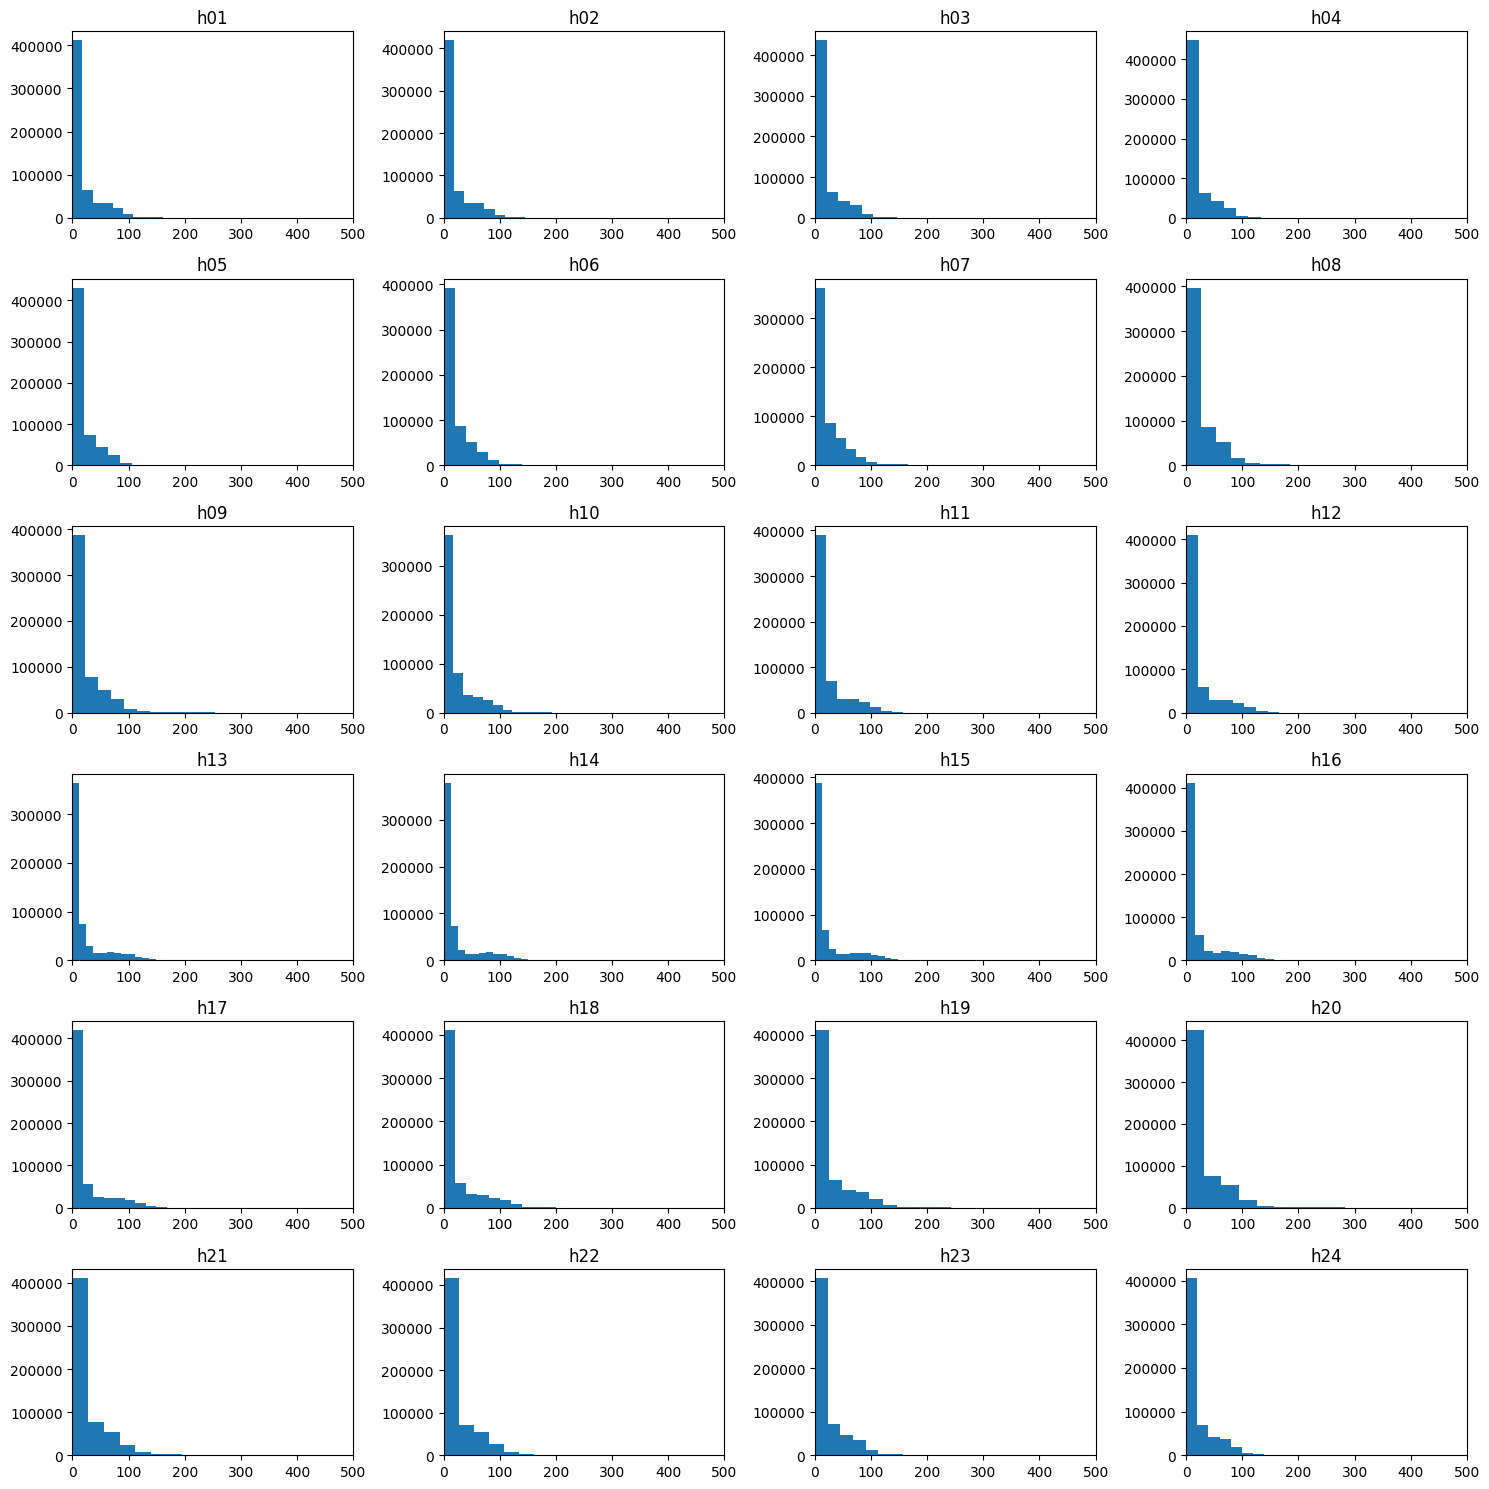

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

axes = axes.flatten()

for i, col in enumerate(['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 
                         'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 
                         'h21', 'h22', 'h23', 'h24']):
    data = df_aire[col]
    data = data[data > 0]
    axes[i].hist(data, bins=50)
    axes[i].set_title(col)
    axes[i].set_xlim(0, 500)

plt.tight_layout()
plt.show()

Vamos a ver las mínimas y máximas concentraciones, aunque las mínimas son poco útiles, al ser casi siempre cero o valores muy bajos.

In [25]:
min_concentraciones = df_aire.groupby('magnitud')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                  'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].min()

max_concentraciones = df_aire.groupby('magnitud')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                  'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].max()

print("\nMínimas concentraciones por magnitud:")
min_concentraciones


Mínimas concentraciones por magnitud:


h01  h02  h03  h04  h05  h06  h07  h08  h09  h10  \
magnitud                                                                       
Benceno                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
CO                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Hidrocarburos no metánicos  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Hidrocarburos totales       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
M/P-xileno                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
NO                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
NO2                         1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0   
NOx                         1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
O3                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
PM10                        0.6  0.6  0.6  0.6  0.6  0.6  1.0  0.0  0.6  0.0   
PM2.5                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SO2                         1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Tolueno                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0   

                            ...  h15  h16  h17  h18  h19  h20  h21  h22  h23  \
magnitud                    ...                                                
Benceno                     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
CO                          ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Hidrocarburos no metánicos  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0   
Hidrocarburos totales       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0   
M/P-xileno                  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
NO                          ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
NO2                         ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
NOx                         ...  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
O3                          ...  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
PM10                        ...  0.0  0.0  0.6  0.6  0.6  0.6  0.6  1.0  0.6   
PM2.5                       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
SO2                         ...  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
Tolueno                     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                            h24  
magnitud                         
Benceno                     0.0  
CO                          0.0  
Hidrocarburos no metánicos  0.0  
Hidrocarburos totales       0.0  
M/P-xileno                  0.0  
NO                          0.0  
NO2                         1.0  
NOx                         1.0  
O3                          0.0  
PM10                        0.6  
PM2.5                       0.0  
SO2                         0.0  
Tolueno                     0.0  

[13 rows x 24 columns]

In [26]:
print("Máximas concentraciones por magnitud:")
max_concentraciones

Máximas concentraciones por magnitud:


h01     h02      h03      h04      h05     h06  \
magnitud                                                                        
Benceno                      22.00   20.00    10.30    14.60    10.30   17.20   
CO                            3.90    3.20     2.90     2.10     2.10    3.20   
Hidrocarburos no metánicos   11.09   16.96    11.13    11.25    11.34   11.36   
Hidrocarburos totales        24.60   25.00    17.70    20.90    22.50   18.30   
M/P-xileno                   43.00   37.40    44.00    44.00    40.70   34.80   
NO                          490.00  472.00   486.00   494.00   643.00  730.00   
NO2                         220.00  223.00   231.00   246.00   248.00  246.00   
NOx                         898.00  798.00   755.00   774.00   770.00  778.00   
O3                          159.00  149.00   153.00   147.00   147.00  146.00   
PM10                        801.00  908.00  1043.00  1109.00  1065.00  994.00   
PM2.5                       295.00  340.00   432.00   380.00   311.00  295.00   
SO2                          25.00   29.00    18.00    19.00    19.00   21.00   
Tolueno                      66.60  108.40    50.00    71.20   126.40   44.60   

                               h07      h08      h09     h10  ...     h15  \
magnitud                                                      ...           
Benceno                      18.70    20.70    12.20   15.80  ...   11.50   
CO                            7.60     4.60     5.00    5.50  ...    6.10   
Hidrocarburos no metánicos   11.31    11.68    19.17    9.86  ...   13.60   
Hidrocarburos totales        22.70    20.20    22.25   14.50  ...   15.27   
M/P-xileno                   43.00    37.60    41.00   32.50  ...   25.00   
NO                          737.00   723.00   736.00  409.00  ...  361.00   
NO2                         252.00   275.00   224.00  217.00  ...  146.00   
NOx                         918.00  1318.00  1155.00  795.00  ...  564.00   
O3                          147.00   150.00   350.00  187.00  ...  213.00   
PM10                        895.00   833.00   821.00  875.00  ...  620.00   
PM2.5                       265.00   269.00   207.00  246.00  ...  238.00   
SO2                          24.00    83.20    23.00   81.00  ...   27.00   
Tolueno                      37.80    40.30    74.30   72.90  ...  110.89   

                               h16     h17     h18      h19      h20      h21  \
magnitud                                                                        
Benceno                      11.22   16.84   10.18    13.26    11.11    13.00   
CO                            5.50    5.20    5.70     5.10     3.30     4.30   
Hidrocarburos no metánicos   18.51   10.49   10.75    19.54    17.59    13.64   
Hidrocarburos totales        33.44   39.77   41.36    37.30    28.68    14.80   
M/P-xileno                   23.60   28.40   31.00    34.80    36.20    36.20   
NO                          505.00  603.00  625.00   630.00   830.00   756.00   
NO2                         150.00  198.00  234.00   247.00   296.00   247.00   
NOx                         784.00  935.00  999.00  1213.00  1569.00  1400.00   
O3                          233.00  237.00  230.00   225.00   219.00   208.00   
PM10                        604.00  573.00  568.00   544.00   509.00   486.00   
PM2.5                       224.00  229.00  193.00   556.00   327.80   225.00   
SO2                          42.00   10.00   21.00    32.00    36.00    31.00   
Tolueno                      60.63   47.36   63.80   131.83   106.80   126.90   

                               h22      h23     h24  
magnitud                                             
Benceno                        9.8    18.10   20.50  
CO                             3.5     3.90    5.20  
Hidrocarburos no metánicos     4.9    11.38   11.13  
Hidrocarburos totales         14.6    21.70   16.00  
M/P-xileno                    37.3    36.10   30.00  
NO                           757.0   595.00  527.00  
NO2        

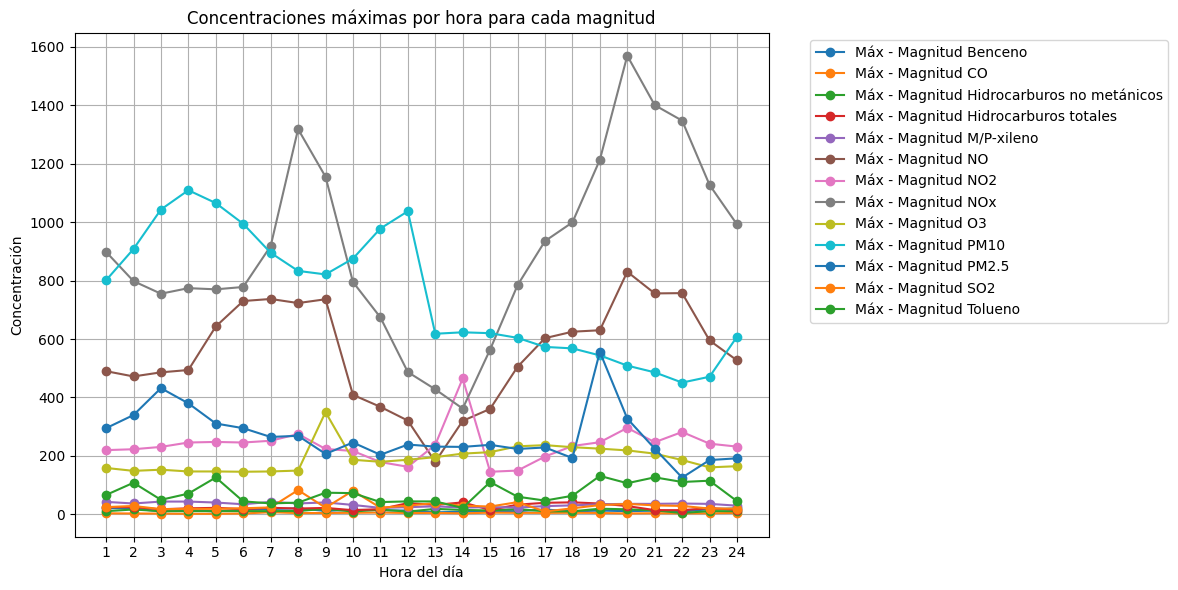

In [27]:
horas_max = [int(h[1:]) for h in max_concentraciones.columns]

fig, ax = plt.subplots(figsize=(12, 6))

for magnitud in max_concentraciones.index:
    ax.plot(horas_max, max_concentraciones.loc[magnitud], label=f'Máx - Magnitud {magnitud}', linestyle='-', marker='o')

ax.set_title('Concentraciones máximas por hora para cada magnitud')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Concentración')
ax.set_xticks(horas_max)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

Los valores máximos son moderados en algunos casos y otro tienen valores muy altos, sobre todo el PM10, PM2.5 y los oxidos de nitrógeno (NOx). El PM10 tiene picos máximos en la madrugada (3:00-6-00) y al mediodía. Los NOx tienen picos máximos pronto por la mañana (7:00-9:00) y en las últimas horas de la tarde (20.00-22.00). El NO se presenta dentro de estos como el más variables y con más picos máximos y bajadas a mínimos. El resto son bastante más equilibrados y moderados, aunque cabe destacar el PM2.5, con concentraciones máximas entre las 19:00 y las 20:00.

Hay que tener en cuenta que este análisis es de picos de concentración máxima y no quiere decir que esas horas sean las que tienen medias de concentración más altas, ya que los picos pueden ser simplemente valores extremos o outliers.

De hecho, esto se puede ver en el siguiente gráfico anual, agrupando las concentraciones en grupos de 3 horas, donde se aprecia una regularidad en las concentraciones medias y una mayor concentración a nivel general en horas de la tarde (18:00-21:00, 21:00-00:00) y en los últimos años concentraciones medias altas en las mañanas (09:00-12:00) 

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\848136280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aire['fecha'] = pd.to_datetime(df_aire['fecha'])


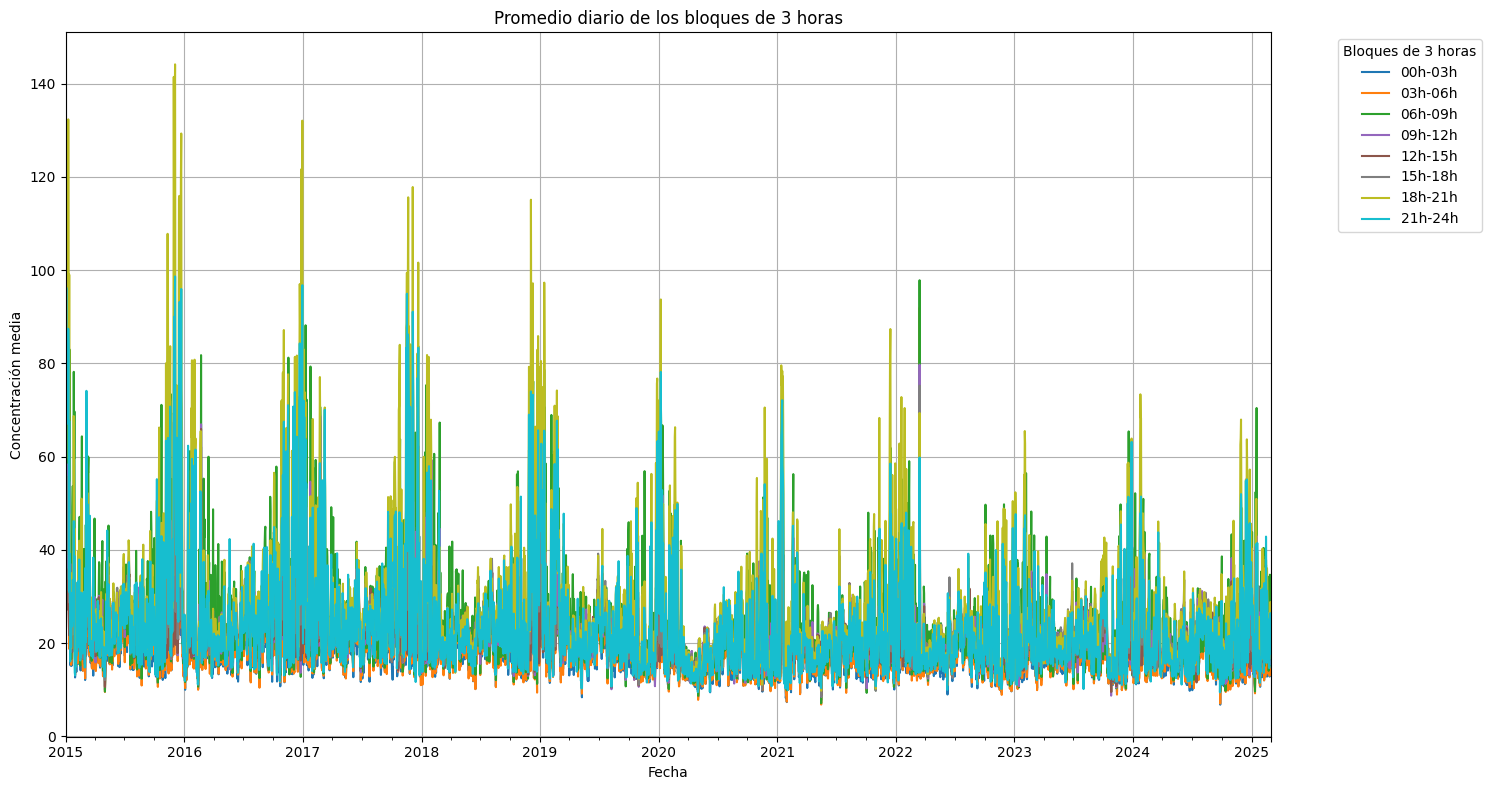

In [28]:
df_aire['fecha'] = pd.to_datetime(df_aire['fecha'])

bloques_horas = [
    ['h01', 'h02', 'h03'],
    ['h04', 'h05', 'h06'],
    ['h07', 'h08', 'h09'],
    ['h10', 'h11', 'h12'],
    ['h13', 'h14', 'h15'],
    ['h16', 'h17', 'h18'],
    ['h19', 'h20', 'h21'],
    ['h22', 'h23', 'h24']
]

df_aire_bloques = pd.DataFrame()

for i, bloque in enumerate(bloques_horas):
    df_aire_bloques[f'{str(i*3).zfill(2)}h-{str((i+1)*3).zfill(2)}h'] = df_aire[bloque].mean(axis=1)

df_aire_bloques['fecha'] = df_aire['fecha']
df_aire_bloques.set_index('fecha', inplace=True)

plt.figure(figsize=(15, 8))
df_aire_bloques.resample('D').mean().plot(cmap='tab10', ax=plt.gca())
plt.title('Promedio diario de los bloques de 3 horas')
plt.xlabel('Fecha')
plt.ylabel('Concentración media')
plt.legend(title='Bloques de 3 horas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

CORRELACIÓN CONTAMINANTES POR HORAS

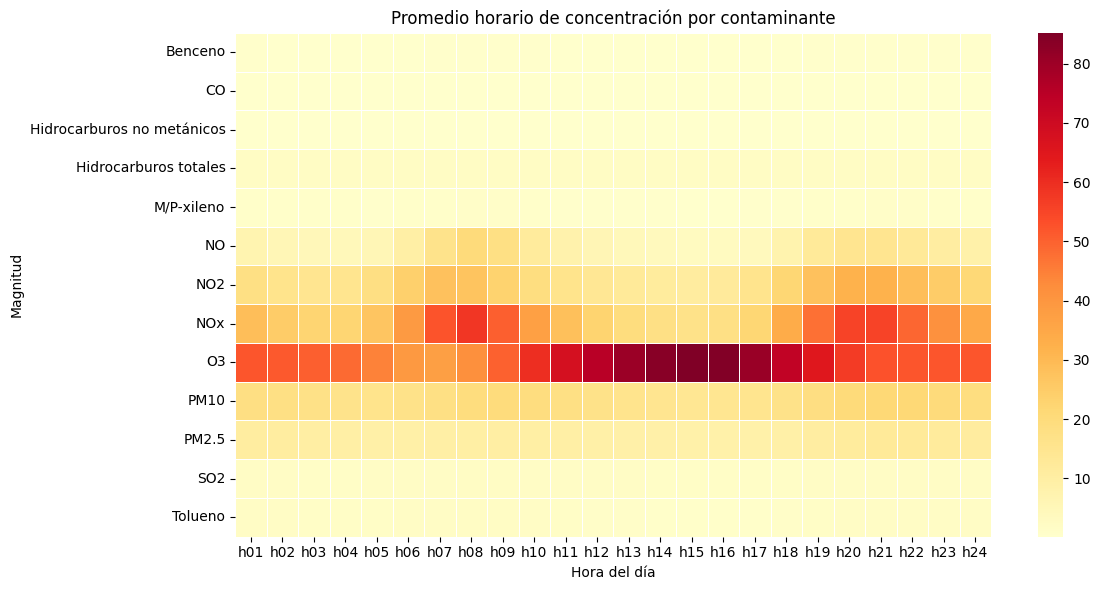

In [29]:
cols_horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]
heat_data = df_aire.groupby("magnitud")[cols_horas].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap="YlOrRd", linewidths=.5)
plt.title('Promedio horario de concentración por contaminante')
plt.xlabel("Hora del día")
plt.ylabel("Magnitud")
plt.tight_layout()
plt.show()

Es normal que en horas consecutivas haya bastante correlación, por lo que nos interesan más las correlaciones (o falta de ella) en horas distintas. Donde más correlacionadas consecutivamente están es entre el mediodía y la tarde (12:00-17:00). Es interesante aquí el análisis de horas menos relacionadas entre sí, que son:
- Las horas del mediodía y tarde (12-17) y primeras horas de la mañana (6-9)
- Las horas del mediodía y tarde (12-17) y las primeras horas de la noche (20-23)

El O3 es el más visible en el gráfico anterior, con mucha concentración entre las 12 y las 17, debido a que son las horas más cálidas del día, momento en el que se dan más concentraciones de ozono. Para el NOx es a la inversa, ya que con la caída del sol o a primeras hora es cuadno sube por la reacción que hace con el ozono, habiendo más concentraciones en horas menos cálidas y que incluso pueden coincidir con horas de tráfico elevado en días laborales, ya que la contaminación de vehículos es uno de los mayores contribuyentes a las concentraciones de los NO.

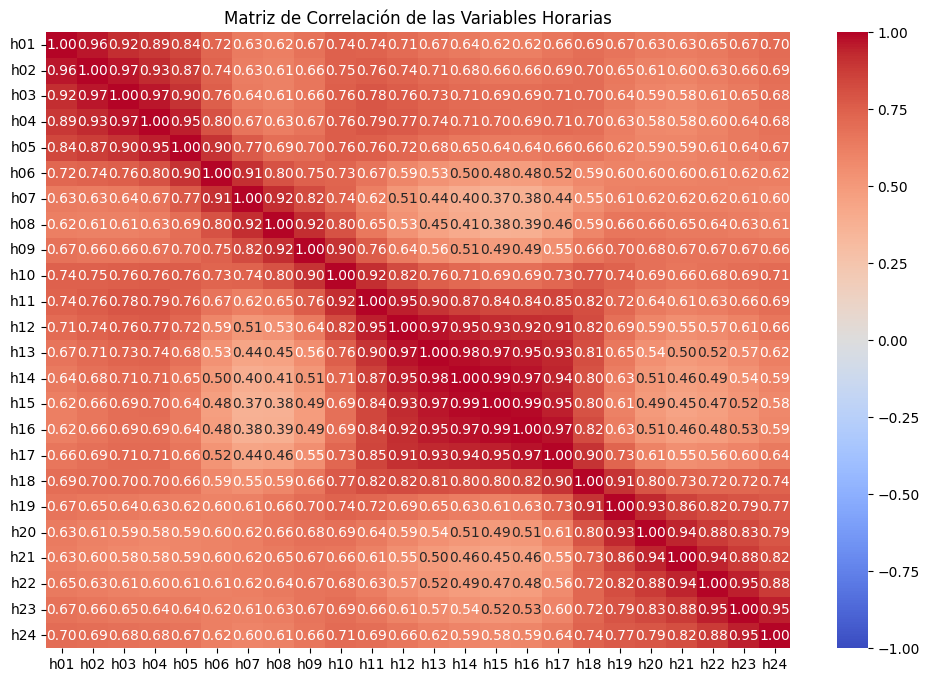

In [30]:
corr_matrix = df_aire[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de las Variables Horarias')
plt.show()

#### ANALISIS HORARIO POR MUNICIPIOS

In [31]:
horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]

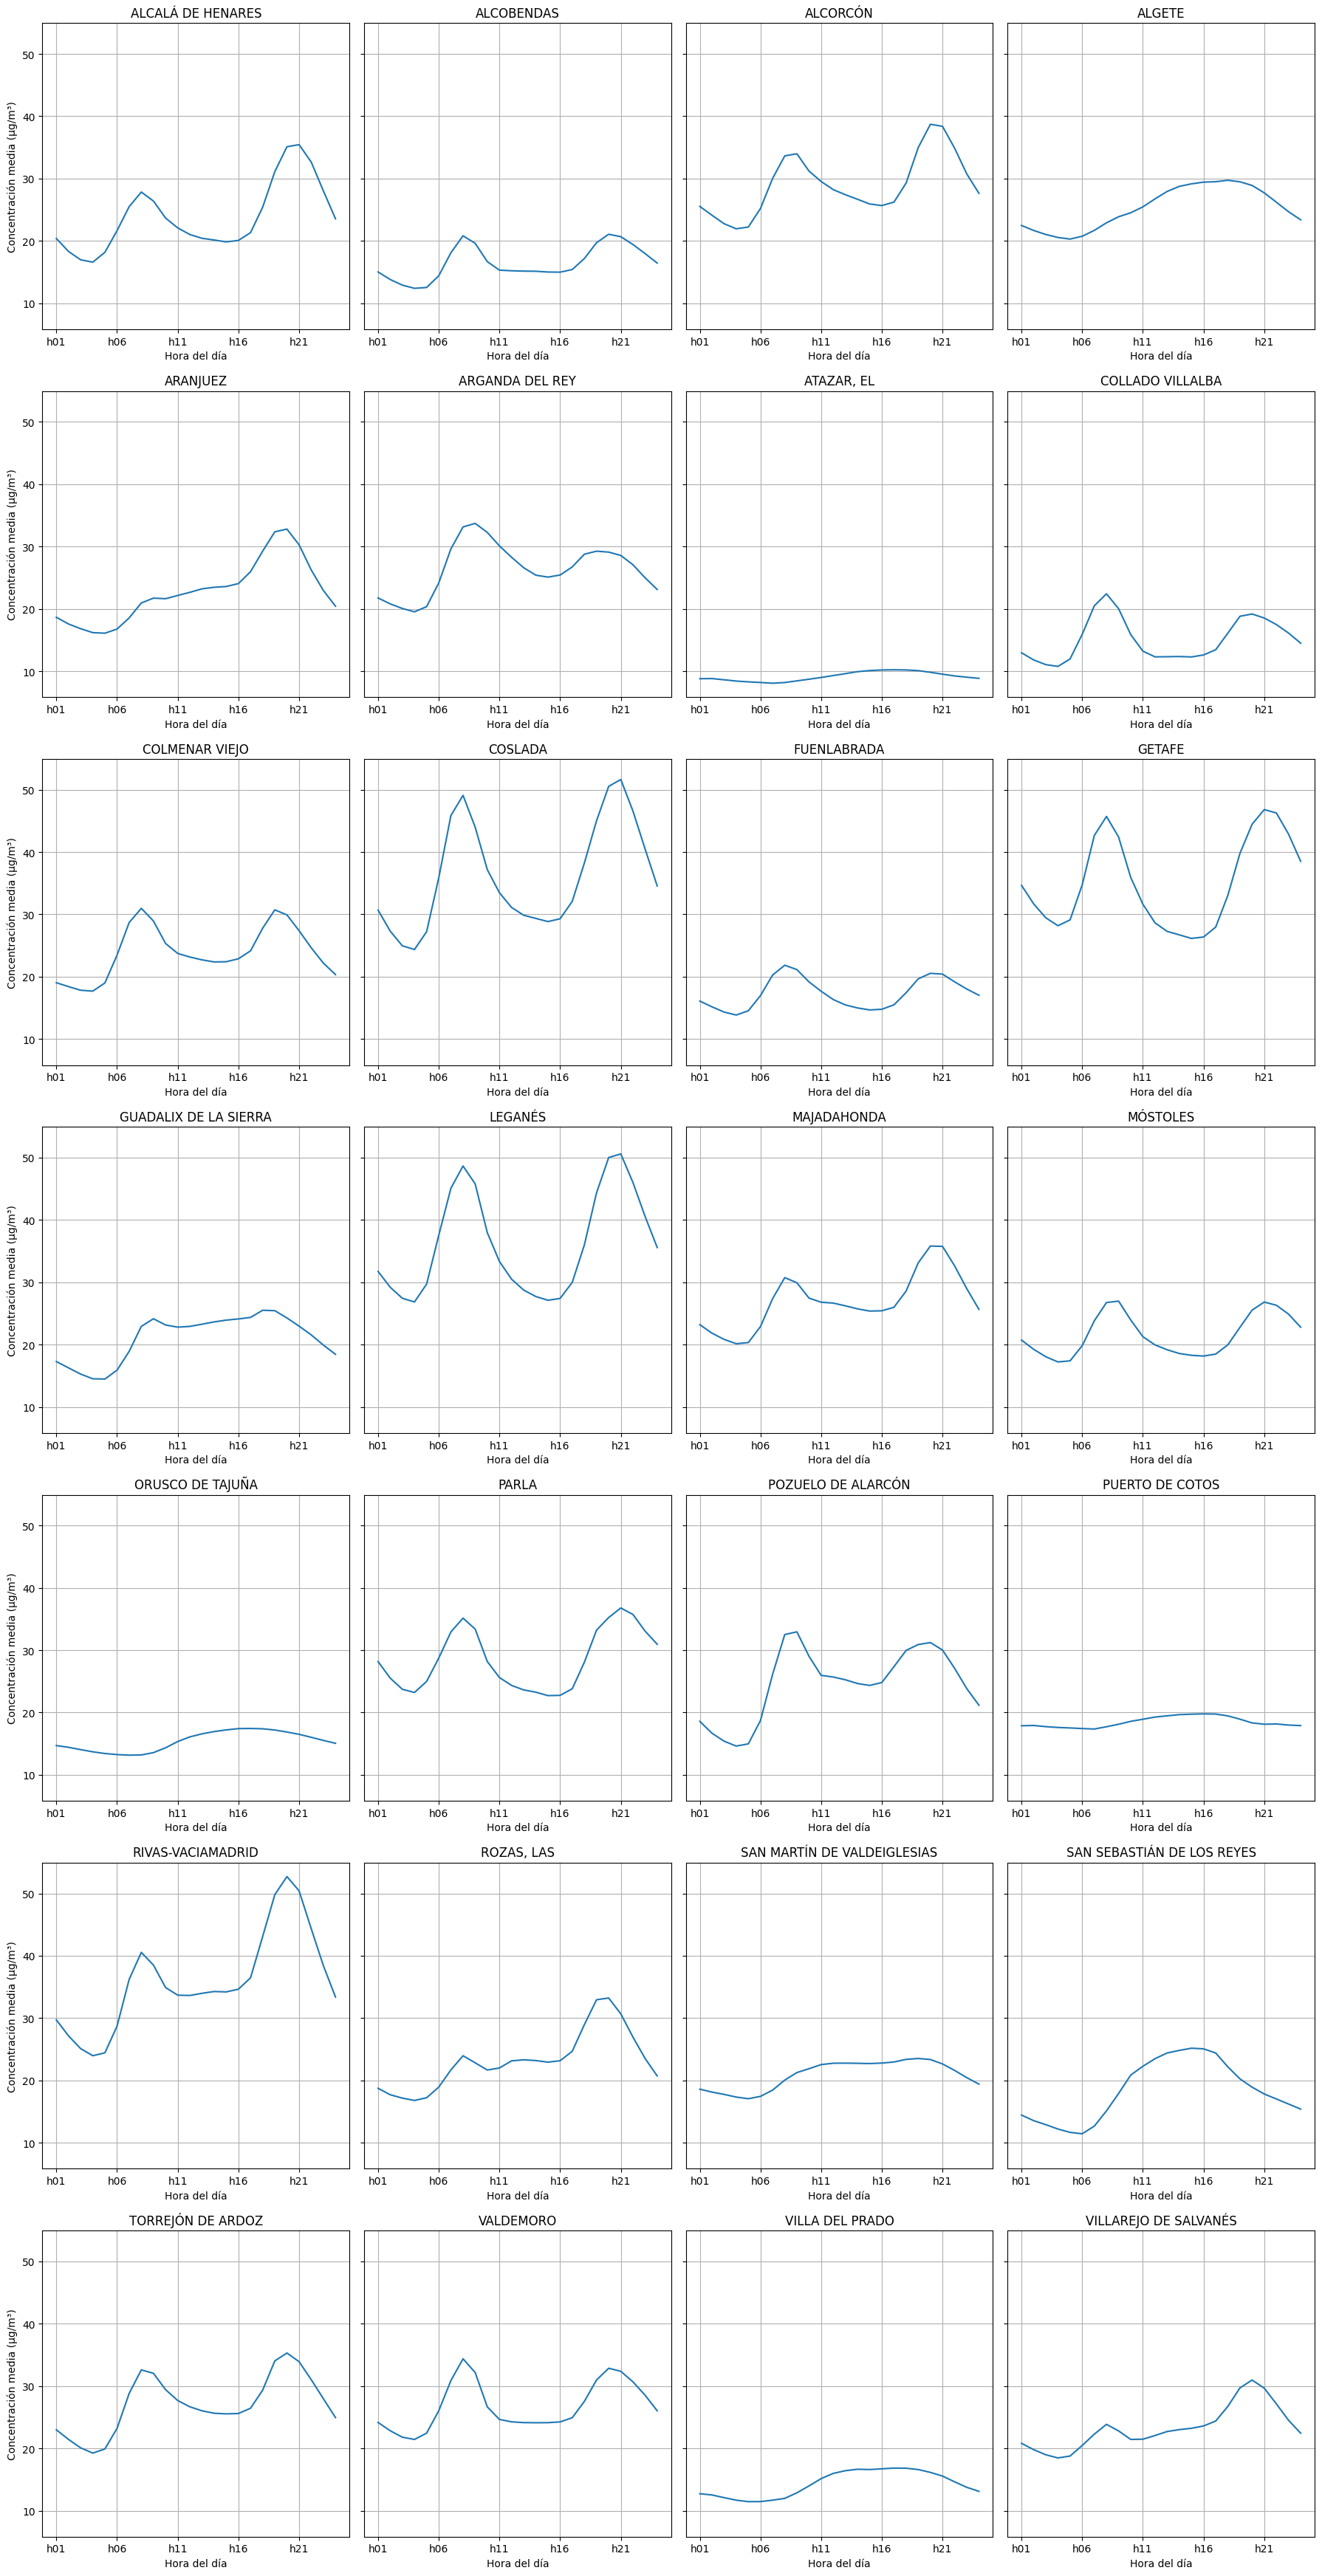

In [32]:
df_aire_grouped = df_aire.groupby('municipio')[horas].mean()

municipios = df_aire_grouped.index.tolist()
n_municipios = len(municipios)
n_cols = 4
n_rows = math.ceil(n_municipios / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), sharey=True)
axes = axes.flatten()

for i, municipio in enumerate(municipios):
    ax = axes[i]
    df_aire_grouped.loc[municipio].plot(ax=ax)
    ax.set_title(f'{municipio}')
    ax.set_xlabel('Hora del día')
    ax.set_ylabel('Concentración media (µg/m³)')
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Con el gráfico anterior vemos que hay dos picos principales en la mayoría de los municipios. Uno por la mañana temprano, entre las 7h y las 10h y otro por la tarde-noche, entre las 19h y las 22h. Estos picos se podrían asociar con las horas punta de tráfico, pero esto se tiene que analizar aparte para sacar conclusiones.

En municipios más urbanos y conocidos como Madrid, Alcorcón, Coslada, Getafe, Leganés o Rivas-Vaciamadrid, los picos son más marcados.

Hay municipios conocidos y poblados, pero no tanto, con concentraciones intermedias como Las Rozas, San Sebastián de los Reyes o Majadahonda. Móstoles también está en este grupo, aunque es un municipio muy poblado.

En municipios más alejados o menos poblados como El Atazar, Puerto de Cotos, Villa del Prado, San Martín de Valdeiglesias o Orusco de Tajuña, los niveles son más bajos y más lineales a lo largo del día y las horas.
____

#### ANÁLISIS DE CONTAMINANTES

In [33]:
df_aire['magnitud'].value_counts()

magnitud
O3                            93340
NO2                           90370
NO                            90370
NOx                           90352
PM10                          69947
PM2.5                         43624
SO2                           22263
CO                            22263
Hidrocarburos totales         14847
Hidrocarburos no metánicos    14847
Tolueno                       14818
Benceno                       14818
M/P-xileno                    11923
Name: count, dtype: int64

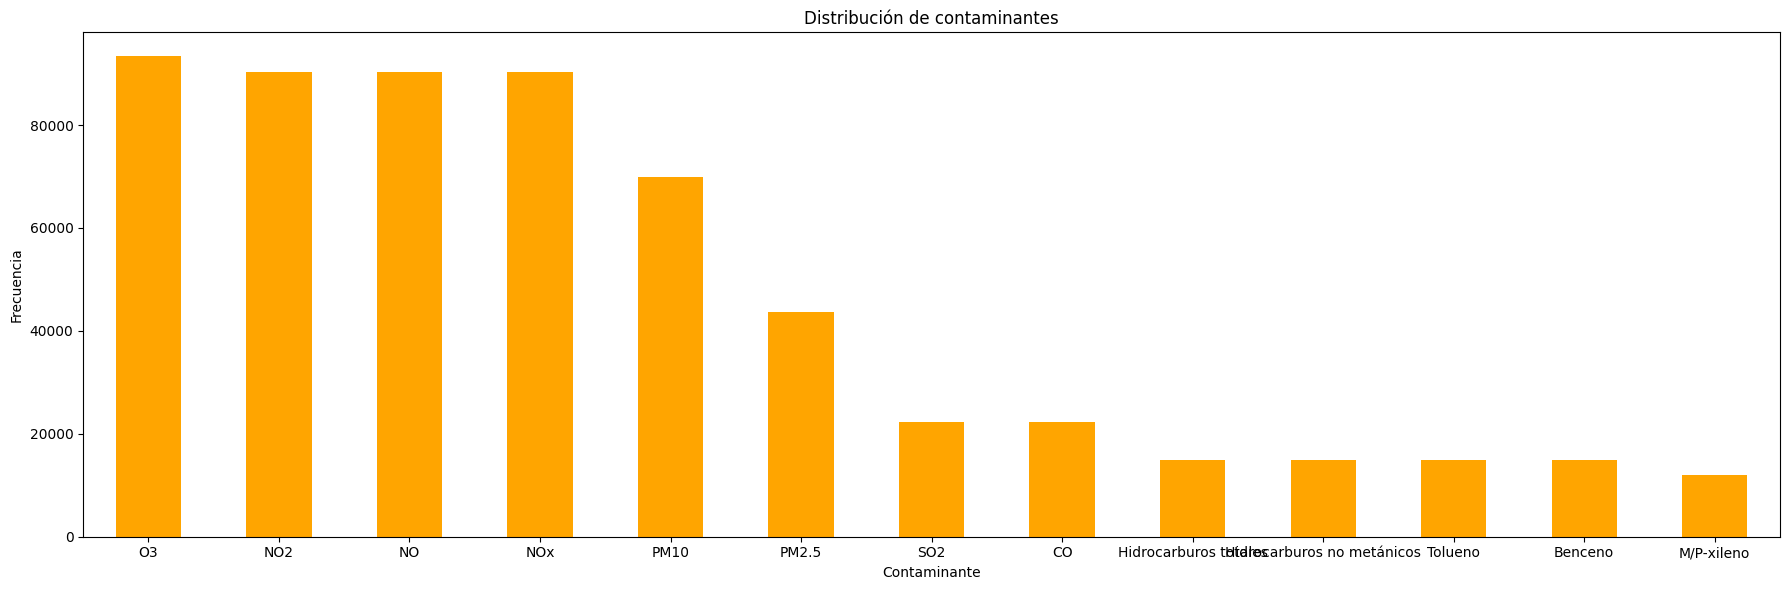

In [34]:
magnitudes_count = df_aire['magnitud'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(18, 6))
magnitudes_count.plot(kind='bar', color='orange')

plt.title('Distribución de contaminantes')
plt.xlabel('Contaminante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
df_aire['magnitud'].describe()

count     593782
unique        13
top           O3
freq       93340
Name: magnitud, dtype: object

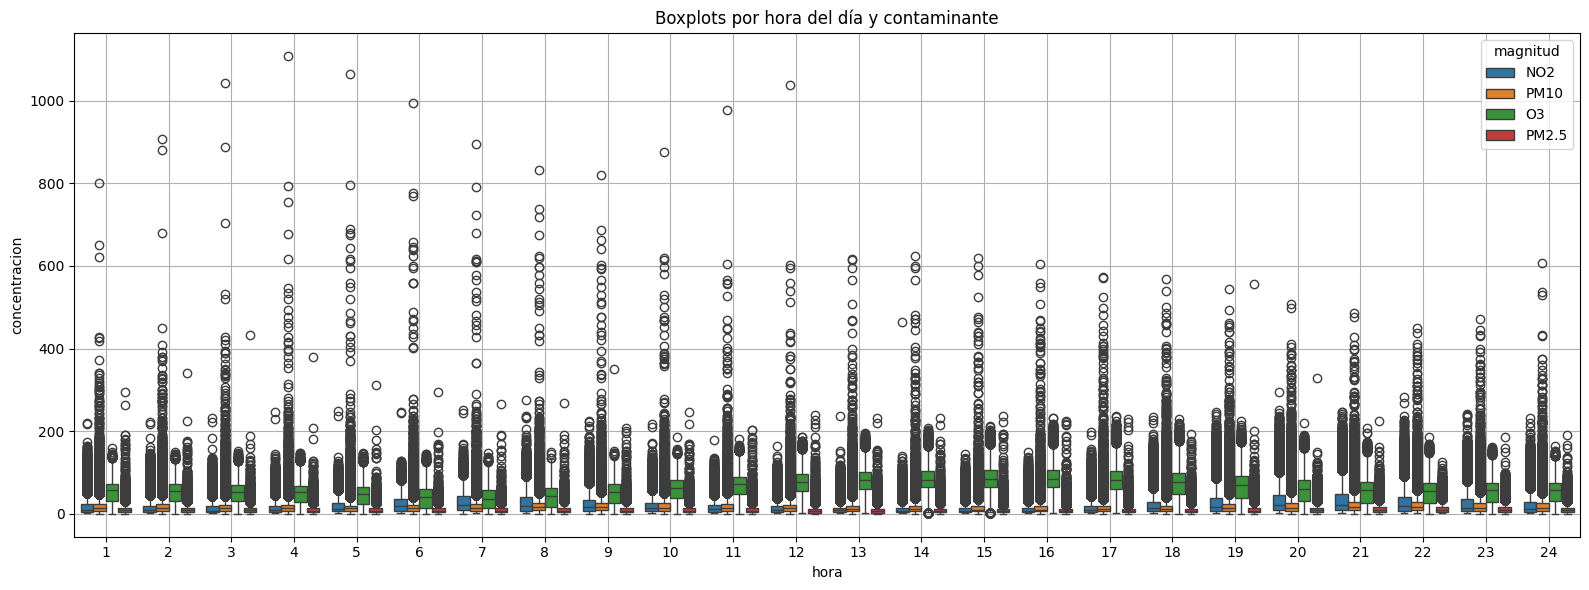

In [36]:
df_largo = df_aire.melt(
    id_vars=['fecha', 'municipio', 'magnitud'],
    value_vars=[f'h{str(i).zfill(2)}' for i in range(1, 25)],
    var_name='hora',
    value_name='concentracion'
)
df_largo['hora'] = df_largo['hora'].str.extract('h(\\d+)').astype(int)

plt.figure(figsize=(16, 6))
sns.boxplot(data=df_largo[df_largo['magnitud'].isin(['NO2', 'PM10', 'O3', 'PM2.5'])],
            x='hora', y='concentracion', hue='magnitud')
plt.title('Boxplots por hora del día y contaminante')
plt.grid(True)
plt.tight_layout()
plt.show()

OZONO (O3)

In [37]:
df_aire[df_aire['magnitud'] == 'O3'].describe().T

count                           mean                  min  \
h01    92249.0                      52.174224                  0.0   
h02    92243.0                      51.632763                  0.0   
h03    92162.0                      50.550511                  0.0   
h04    92210.0                      48.600501                  0.0   
h05    92176.0                      44.631045                  0.0   
h06    91439.0                      39.270052                  0.0   
h07    90318.0                      37.527743                  0.0   
h08    89368.0                      41.816917                  0.0   
h09    88578.0                      50.193426                  0.0   
h10    88259.0                      59.660112                  0.0   
h11    88270.0                      68.142532                  0.0   
h12    88775.0                      75.185672                  1.0   
h13    89698.0                      80.407107                  1.0   
h14    90818.0                      83.717226                  1.0   
h15    91540.0                       85.20623                  1.0   
h16    91875.0                      84.581543                  1.0   
h17    92146.0                      80.852462                  1.0   
h18    92276.0                      73.489824                  0.0   
h19    92307.0                       65.07635                  0.0   
h20    92316.0                      57.131137                  0.0   
h21    92295.0                      52.765807                  0.0   
h22    92206.0                      52.021354                  0.0   
h23    92272.0                      52.051513                  0.0   
h24    92251.0                      52.239239                  0.0   
fecha    93340  2020-02-26 16:57:59.820012800  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                   32.0                 57.0                 73.0   
h02                   32.0                 56.0                 72.0   
h03                   31.0                 54.0                 70.0   
h04                   29.0                 52.0                 68.0   
h05                   24.0                 47.0                 64.0   
h06                   15.0                 40.0                 59.0   
h07                   13.0                 37.0                 58.0   
h08                   17.0                 44.0                 63.0   
h09                   27.0                 54.0                 72.0   
h10                   38.0                 63.0                 81.0   
h11                   48.0                 71.0                 89.0   
h12                   56.0                 77.0                 96.0   
h13                   61.0                 81.0                101.0   
h14                   64.0                 83.0                104.0   
h15                   65.0                 84.0                106.0   
h16                   64.0                 84.0                106.0   
h17                   59.0                 82.0                104.0   
h18                   49.0                 76.0                100.0   
h19                   38.0                 69.0                 92.0   
h20                   31.0                 61.0                 82.0   
h21                   27.0                 57.0                 76.0   
h22                   27.0                 56.0                 75.0   
h23                   29.0                 57.0                 74.0   
h24                   31.0                 57.0                 74.0   
fecha  2017-07-23 00:00:00  2020-02-22 00:00:00  2022-10-26 00:00:00   

                       max        std  
h01                  159.0   28.14723  
h02                  149.0   27.41363  
h03                  153.0  26.816808  
h04                  147.0  26.318736  
h05                  147.0  26.123271  
h06                  146.0  26.310602  
h07                  147.0  26.2664

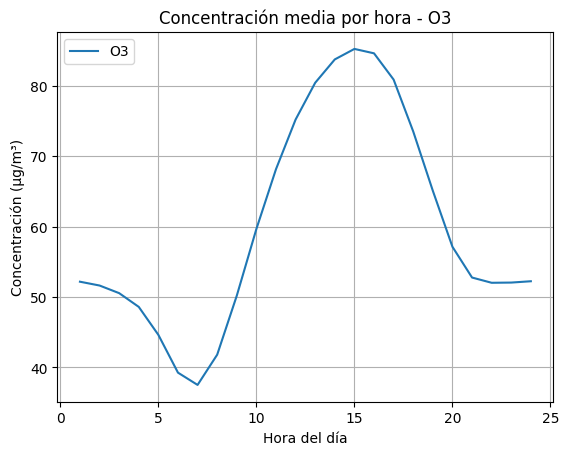

In [38]:
contaminantes_o = df_aire[df_aire['magnitud'] == 'O3'][horas]
medias = contaminantes_o.mean()

plt.plot(range(1, 25), medias, label='O3')
plt.title('Concentración media por hora - O3')
plt.xlabel('Hora del día')
plt.ylabel('Concentración (µg/m³)')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Vemos que las concentraciones de ozono bajan de madrugada y suben paulatinamente desde las 7 de la mañana hasta alcanzar su pico a las 15 horas. Tras ellos desciende bastante, teniendo concentraciones altas en horas inmediatamente posteriores hasta mantenerse en un nivel moderado entre las 21 y las 02 de la madrugada.

En cuanto a los municipios con mayores concentraciones medias son municipios menos conocidos y no tan urbanos como otros. Más alejados del centro de Madrid. Los de menor, están más cerca, pero tampoco mucho, salvo Pozuelo.

Top 5 municipios con mayor concentración de O3 (Ozono):
municipio
PUERTO DE COTOS                87.830372
ATAZAR, EL                     80.994886
ORUSCO DE TAJUÑA               77.835887
SAN MARTÍN DE VALDEIGLESIAS    68.911027
VILLAREJO DE SALVANÉS          66.671658
dtype: float64


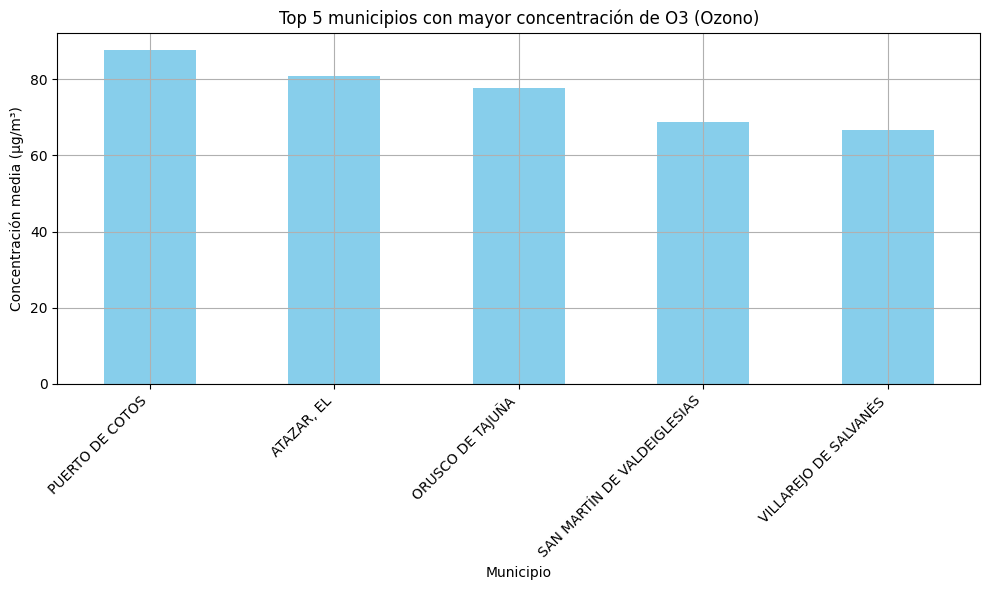

In [39]:
contaminantes_o = df_aire[df_aire['magnitud'] == 'O3'][['municipio'] + horas]

media_o3 = contaminantes_o.groupby('municipio').mean()
concentracion_o3 = media_o3.mean(axis=1)
top_o3_municipios = concentracion_o3.sort_values(ascending=False).head(5)

print("Top 5 municipios con mayor concentración de O3 (Ozono):")
print(top_o3_municipios)

top_o3_municipios.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 5 municipios con mayor concentración de O3 (Ozono)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 5 municipios con menor concentración de O3 (Ozono):
municipio
COSLADA               46.850986
PARLA                 48.044260
POZUELO DE ALARCÓN    48.081709
LEGANÉS               49.790120
ROZAS, LAS            51.100003
dtype: float64


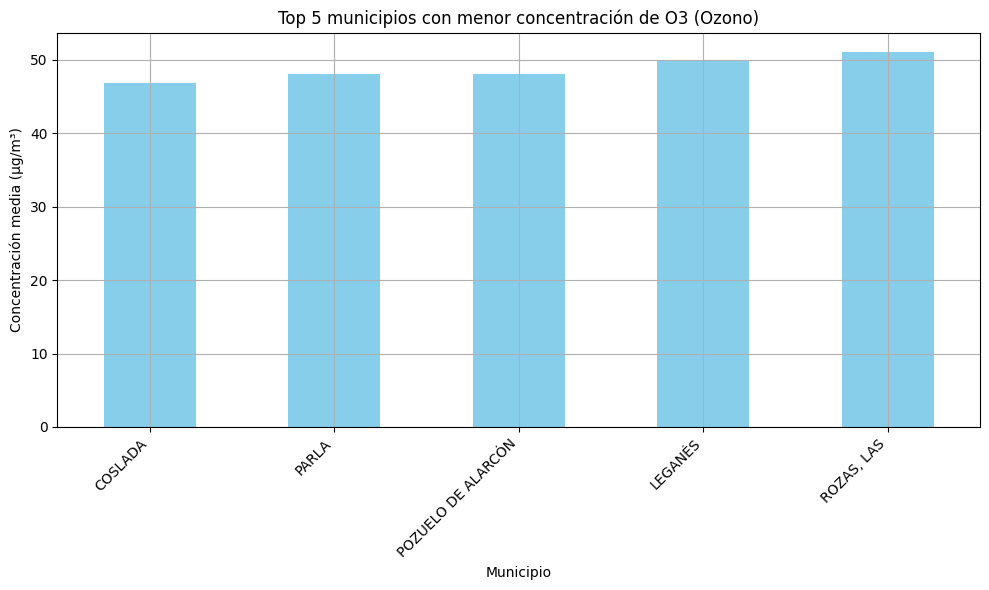

In [40]:
low_o3_municipios = concentracion_o3.sort_values(ascending=True).head(5)

print("Top 5 municipios con menor concentración de O3 (Ozono):")
print(low_o3_municipios)

low_o3_municipios.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 5 municipios con menor concentración de O3 (Ozono)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

DIÓXIDO DE NITRÓGENO (NO2)

In [41]:
df_aire[df_aire['magnitud'] == 'NO2'].describe().T

count                           mean                  min  \
h01    89567.0                       18.06604                  1.0   
h02    89558.0                      16.048561                  1.0   
h03    89480.0                       14.92357                  1.0   
h04    89525.0                       15.13146                  1.0   
h05    89489.0                      18.169999                  1.0   
h06    88649.0                      23.972735                  1.0   
h07    87429.0                      27.731005                  0.0   
h08    86614.0                      27.233366                  1.0   
h09    85871.0                      23.400723                  0.0   
h10    85590.0                      19.017925                  1.0   
h11    85648.0                      15.969542                  1.0   
h12    86026.0                       13.91857                  1.0   
h13    86948.0                      12.505902                  1.0   
h14    88187.0                      11.645667                  1.0   
h15    88910.0                       11.36844                  1.0   
h16    89201.0                      12.355001                  1.0   
h17    89461.0                      15.599837                  1.0   
h18    89580.0                      21.802367                  1.0   
h19    89603.0                      28.057119                  1.0   
h20    89615.0                       32.23495                  1.0   
h21    89595.0                        32.3322                  1.0   
h22    89538.0                      28.858641                  1.0   
h23    89574.0                       24.86871                  1.0   
h24    89559.0                      21.092196                  1.0   
fecha    90370  2020-04-03 05:01:12.581608960  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    5.0                 10.0                 23.0   
h02                    4.0                  9.0                 20.0   
h03                    4.0                  8.0                 19.0   
h04                    4.0                  9.0                 20.0   
h05                    6.0                 12.0                 26.0   
h06                    7.0                 18.0                 37.0   
h07                    9.0                 21.0                 43.0   
h08                    8.0                 20.0                 41.0   
h09                    7.0                 16.0                 34.0   
h10                    6.0                 13.0                 26.0   
h11                    5.0                 11.0                 21.0   
h12                    5.0                  9.0                 18.0   
h13                    5.0                  9.0                 15.0   
h14                    4.0                  8.0                 14.0   
h15                    4.0                  8.0                 14.0   
h16                    4.0                  8.0                 15.0   
h17                    5.0                 10.0                 20.0   
h18                    6.0                 13.0                 28.0   
h19                    8.0                 17.0                 39.0   
h20                    9.0                 21.0                 46.0   
h21                    9.0                 21.0                 47.0   
h22                    8.0                 18.0                 41.0   
h23                    6.0                 15.0                 35.0   
h24                    5.0                 12.0                 28.0   
fecha  2017-09-09 00:00:00  2020-04-27 00:00:00  2022-11-24 00:00:00   

                       max        std  
h01                  220.0  20.390311  
h02                  223.0  18.252495  
h03                  231.0   16.59057  
h04                  246.0  15.682575  
h05                  248.0  16.683853  
h06                  246.0  20.200364  
h07                  252.0  22.7488

ÓXIDO DE NITRÓGENO (NO)

In [42]:
df_aire[df_aire['magnitud'] == 'NO'].describe().T

count                           mean                  min  \
h01    89572.0                        6.88214                  0.0   
h02    89562.0                       5.667102                  0.0   
h03    89485.0                       4.861485                  0.0   
h04    89530.0                       4.532995                  0.0   
h05    89489.0                       5.465052                  0.0   
h06    88650.0                       9.639301                  0.0   
h07    87432.0                      16.244567                  0.0   
h08    86618.0                      20.186372                  0.0   
h09    85872.0                      17.758594                  0.0   
h10    85585.0                       11.78012                  0.0   
h11    85658.0                       8.033383                  0.0   
h12    86024.0                       5.837343                  0.0   
h13    86943.0                       4.559214                  0.0   
h14    88181.0                       3.811818                  0.0   
h15    88912.0                        3.32224                  0.0   
h16    89202.0                       3.229684                  0.0   
h17    89466.0                       4.082154                  0.0   
h18    89587.0                       7.671727                  0.0   
h19    89610.0                      12.484857                  0.0   
h20    89622.0                      15.010779                  0.0   
h21    89602.0                      15.036544                  0.0   
h22    89558.0                      13.090109                  0.0   
h23    89580.0                      10.735397                  0.0   
h24    89565.0                       8.542768                  0.0   
fecha    90370  2020-04-03 05:01:12.581608960  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    1.0                  1.0                  2.0   
h02                    1.0                  1.0                  2.0   
h03                    1.0                  1.0                  2.0   
h04                    1.0                  1.0                  2.0   
h05                    1.0                  1.0                  3.0   
h06                    1.0                  2.0                  7.0   
h07                    1.0                  4.0                 14.0   
h08                    1.0                  4.0                 16.0   
h09                    1.0                  4.0                 12.0   
h10                    1.0                  3.0                  8.0   
h11                    1.0                  3.0                  6.0   
h12                    1.0                  2.0                  5.0   
h13                    1.0                  2.0                  4.0   
h14                    1.0                  2.0                  4.0   
h15                    1.0                  2.0                  3.0   
h16                    1.0                  1.0                  3.0   
h17                    1.0                  1.0                  3.0   
h18                    1.0                  2.0                  4.0   
h19                    1.0                  2.0                  5.0   
h20                    1.0                  2.0                  6.0   
h21                    1.0                  2.0                  5.0   
h22                    1.0                  1.0                  4.0   
h23                    1.0                  1.0                  3.0   
h24                    1.0                  1.0                  2.0   
fecha  2017-09-09 00:00:00  2020-04-27 00:00:00  2022-11-24 00:00:00   

                       max        std  
h01                  490.0  22.970127  
h02                  472.0  19.395944  
h03                  486.0  16.544688  
h04                  494.0  14.637024  
h05                  643.0  14.675405  
h06                  730.0  20.607661  
h07                  737.0  32.2679

ÓXIDOS DE NITRÓGENO (EN CONJUNTO, NOx)

In [43]:
df_aire[df_aire['magnitud'] == 'NOx'].describe().T

count                           mean                  min  \
h01    89463.0                      28.894806                  1.0   
h02    89444.0                      25.030466                  0.0   
h03    89361.0                      22.680532                  0.0   
h04    89407.0                      22.369389                  0.0   
h05    89380.0                      26.779056                  1.0   
h06    88567.0                      38.860806                  0.0   
h07    87365.0                      52.618371                  0.0   
h08    86549.0                      58.112595                  0.0   
h09    85838.0                      50.561651                  0.0   
h10    85518.0                      37.059964                  0.0   
h11    85610.0                      28.316213                  0.0   
h12    85955.0                      22.951067                  0.0   
h13    86899.0                      19.613218                  0.0   
h14    88102.0                      17.633028                  0.0   
h15    88847.0                      16.646336                  0.0   
h16    89111.0                       17.49114                  0.0   
h17    89369.0                      22.040954                  1.0   
h18    89493.0                      33.734694                  1.0   
h19    89511.0                      47.328731                  1.0   
h20    89531.0                      55.384314                  1.0   
h21    89506.0                       55.50991                  1.0   
h22    89485.0                      49.122155                  1.0   
h23    89473.0                       41.52636                  1.0   
h24    89460.0                      34.418511                  1.0   
fecha    90352  2020-04-02 23:42:03.251283968  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    7.0                 12.0                 27.0   
h02                    6.0                 11.0                 23.0   
h03                    6.0                 11.0                 22.0   
h04                    7.0                 12.0                 23.0   
h05                    8.0                 15.0                 32.0   
h06                   10.0                 22.0                 49.0   
h07                   11.0                 28.0                 66.0   
h08                   11.0                 28.0                 67.0   
h09                   10.0                 22.0                 54.0   
h10                    9.0                 18.0                 39.0   
h11                    8.0                 15.0                 30.0   
h12                    7.0                 13.0                 25.0   
h13                    7.0                 12.0                 22.0   
h14                    6.0                 11.0                 20.0   
h15                    6.0                 10.0                 19.0   
h16                    7.0                 11.0                 20.0   
h17                    7.0                 13.0                 24.0   
h18                    8.0                 16.0                 34.0   
h19                   10.0                 20.0                 46.0   
h20                   12.0                 25.0                 56.0   
h21                   11.0                 24.0                 57.0   
h22                   10.0                 21.0                 49.0   
h23                    9.0                 17.0                 41.0   
h24                    7.0                 14.0                 33.0   
fecha  2017-09-09 00:00:00  2020-04-27 00:00:00  2022-11-24 00:00:00   

                       max        std  
h01                  898.0  50.325003  
h02                  798.0  43.150201  
h03                  755.0  37.388933  
h04                  774.0  33.606061  
h05                  770.0  34.292826  
h06                  778.0   46.23966  
h07                  918.0  66.3262

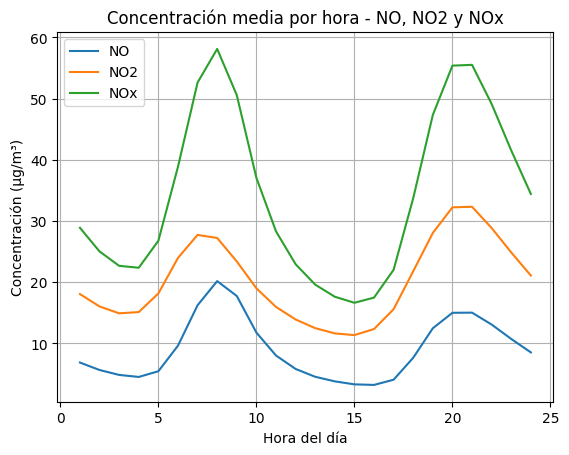

In [44]:
contaminantes_NO = ['NO', 'NO2', 'NOx']
horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]

for contaminante in contaminantes_NO:
    datos = df_aire[df_aire['magnitud'] == contaminante][horas]
    medias = datos.mean()
    plt.plot(range(1, 25), medias, label=contaminante)

plt.title('Concentración media por hora - NO, NO2 y NOx')
plt.xlabel('Hora del día')
plt.ylabel('Concentración (µg/m³)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Las concentraciones medias horarias de los oxidos de nitrógeno tienen tendencias muy parecidas. Obviamente el más alto es el NOx, que junta todos los tipos de NO. Entre NO y NO2 solo hay diferecnias de concentración media, siendo la del NO2 mayores que el NO. La distribució es muy cambiante, con picos entre las 7 y las 10 de la mañana y las 20 y las 21 de la tarde Hay descensos justo entre esas horas: de madrugada y entre el mediodía y la tarde.

Los municipios con mas concentración de este tipo son poblaciones grandes en los alrededores de Madrid centro, pero todavía algo alejadas. Son también municipios bastante industrializados. En este caso, además algunos municipios invierten el sentido con respecto al ozono, ya que los que eran mayores con el ozono aquí tienen las menores concentraciones y justo al revés con Leganés o Coslada, por lo que pueden estar inversamente relacionados.

Top 5 municipios con mayor concentración de NO (óxidos de nitrógeno):
municipio
COSLADA              21.758619
LEGANÉS              21.623864
GETAFE               21.051438
RIVAS-VACIAMADRID    15.753847
ALCALÁ DE HENARES    15.727745
dtype: float64


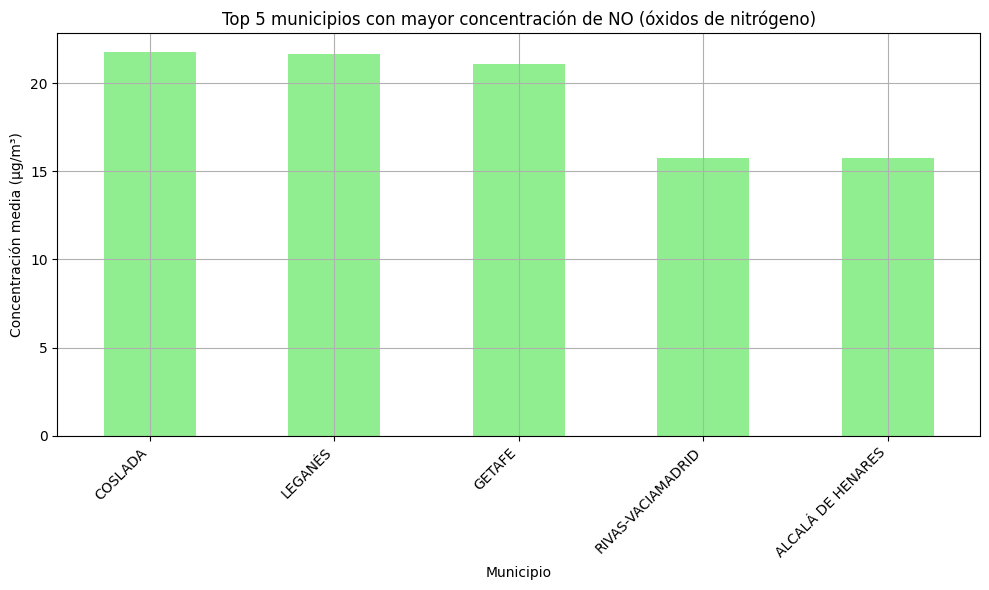

In [45]:
contaminantes_no = df_aire[df_aire['magnitud'] == 'NO'][['municipio'] + horas]

media_no = contaminantes_no.groupby('municipio').mean()
concentracion_no = media_no.mean(axis=1)
top_no_municipios = concentracion_no.sort_values(ascending=False).head(5)

print("Top 5 municipios con mayor concentración de NO (óxidos de nitrógeno):")
print(top_no_municipios)

top_no_municipios.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Top 5 municipios con mayor concentración de NO (óxidos de nitrógeno)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 5 municipios con menor concentración de NO (óxidos de nitrógeno):
municipio
PUERTO DE COTOS                1.071089
ATAZAR, EL                     1.198719
ORUSCO DE TAJUÑA               1.222296
VILLA DEL PRADO                1.672201
SAN MARTÍN DE VALDEIGLESIAS    1.865834
dtype: float64


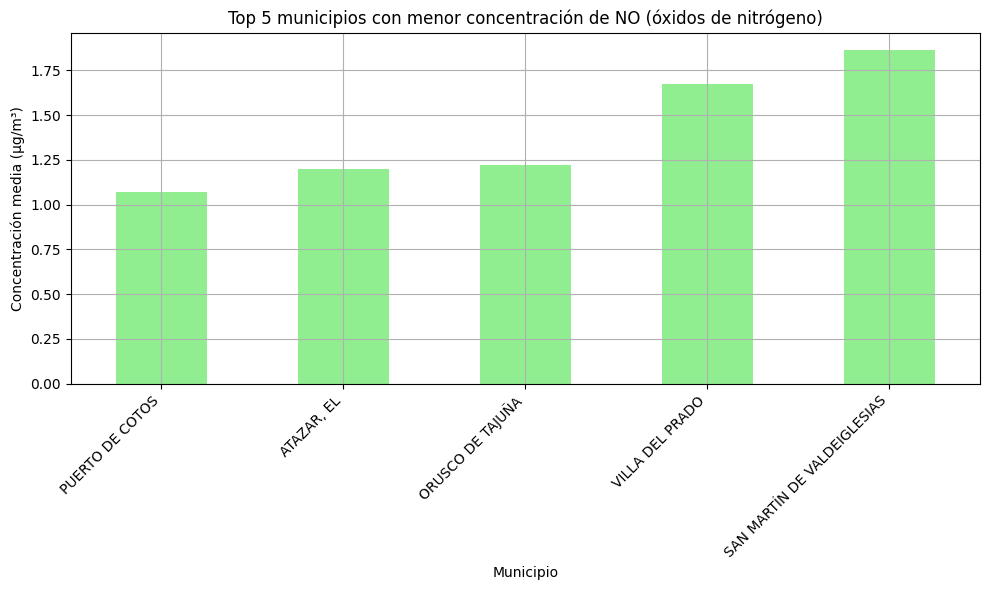

In [46]:
low_no_municipios = concentracion_no.sort_values(ascending=True).head(5)

print("Top 5 municipios con menor concentración de NO (óxidos de nitrógeno):")
print(low_no_municipios)

low_no_municipios.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Top 5 municipios con menor concentración de NO (óxidos de nitrógeno)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

MATERIAL PARTICULADO DE 10 MICROGRAMOS O MENOR (PM10)

In [47]:
df_aire[df_aire['magnitud'] == 'PM10'].describe().T

count                           mean                  min  \
h01    68698.0                      18.314864                  0.6   
h02    68689.0                       18.08606                  0.6   
h03    68632.0                      17.233769                  0.6   
h04    68666.0                      16.313838                  0.6   
h05    68652.0                      15.871074                  0.6   
h06    68386.0                      16.442501                  0.6   
h07    67962.0                      17.941978                  1.0   
h08    67637.0                      19.494605                  0.0   
h09    67389.0                      19.980199                  0.6   
h10    67203.0                      19.215934                  0.0   
h11    67151.0                      18.029673                  0.0   
h12    67316.0                       16.73592                  0.6   
h13    67702.0                      15.618277                  0.6   
h14    68113.0                      14.866901                  0.0   
h15    68333.0                      14.400044                  0.0   
h16    68473.0                       14.53287                  0.0   
h17    68570.0                      15.111646                  0.6   
h18    68635.0                      16.502676                  0.6   
h19    68662.0                      18.564601                  0.6   
h20    68685.0                      20.508586                  0.6   
h21    68675.0                      21.731474                  0.6   
h22    68552.0                      21.543325                  1.0   
h23    68688.0                      20.405768                  0.6   
h24    68677.0                      19.024586                  0.6   
fecha    69947  2020-03-31 08:57:22.972536064  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    8.0                 14.0                 24.0   
h02                    8.0                 14.0                 23.0   
h03                    8.0                 14.0                 22.0   
h04                    7.0                 13.0                 21.0   
h05                    7.0                 13.0                 20.0   
h06                    8.0                 13.0                 21.0   
h07                    8.0                 15.0                 23.0   
h08                    9.0                 16.0                 25.0   
h09                    9.0                 16.0                 26.0   
h10                    8.0                 15.0                 25.0   
h11                    7.0                 14.0                 24.0   
h12                    7.0                 13.0                 22.0   
h13                    6.0                 12.0                 20.0   
h14                    6.0                 11.0                 19.0   
h15                    6.0                 10.0                 18.0   
h16                    6.0                 10.0                 18.0   
h17                    6.0                 11.0                 18.0   
h18                    7.0                 12.0                 20.0   
h19                    7.0                 13.0                 23.0   
h20                    8.0                 15.0                 26.0   
h21                    9.0                 16.0                 28.0   
h22                    9.0                 16.0                 28.0   
h23                    8.0                 15.0                 26.0   
h24                    8.0                 14.0                 25.0   
fecha  2017-09-23 00:00:00  2020-04-25 00:00:00  2022-11-01 00:00:00   

                       max        std  
h01                  801.0  17.770949  
h02                  908.0  17.480142  
h03                 1043.0  17.048564  
h04                 1109.0  16.855046  
h05                 1065.0  16.817001  
h06                  994.0  17.179278  
h07                  895.0  17.9385

MATERIAL PARTICULADO DE 2.5 MICROGRAMOS O MENOR (PM2.5)

In [48]:
df_aire[df_aire['magnitud'] == 'PM2.5'].describe().T

count                        mean                  min  \
h01    41854.0                   11.027314                  0.0   
h02    41849.0                   10.965473                  0.0   
h03    41805.0                   10.436393                  0.0   
h04    41833.0                    9.773301                  0.0   
h05    41824.0                    9.375643                  0.0   
h06    41624.0                    9.415727                  0.0   
h07    41338.0                    9.706873                  0.0   
h08    41180.0                   10.092842                  0.0   
h09    41095.0                    10.19571                  0.0   
h10    41028.0                    9.929848                  0.0   
h11    40977.0                     9.61503                  0.0   
h12    41082.0                    9.200919                  0.0   
h13    41273.0                    9.108749                  0.0   
h14    41496.0                    9.029123                  0.0   
h15    41632.0                    8.688242                  0.0   
h16    41705.0                    8.541043                  0.0   
h17    41773.0                    8.652475                  0.0   
h18    41808.0                    9.241436                  0.0   
h19    41839.0                   10.466077                  0.0   
h20    41841.0                   11.692241                  0.0   
h21    41823.0                   12.466894                  0.0   
h22    41715.0                   12.503704                  1.0   
h23    41837.0                   11.960159                  0.0   
h24    41831.0                   11.229992                  0.0   
fecha    43624  2020-08-04 00:23:42.042912  2015-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    4.0                  9.0                 15.0   
h02                    5.0                  9.0                 15.0   
h03                    5.0                  9.0                 14.0   
h04                    5.0                  8.0                 13.0   
h05                    4.0                  8.0                 13.0   
h06                    5.0                  8.0                 13.0   
h07                    5.0                  8.0                 13.0   
h08                    4.0                  8.0                 14.0   
h09                    4.0                  8.0                 14.0   
h10                    4.0                  8.0                 13.0   
h11                    4.0                  8.0                 13.0   
h12                    3.0                  7.0                 12.0   
h13                    3.0                  7.0                 12.0   
h14                    4.0                  7.0                 12.0   
h15                    4.0                  7.0                 11.0   
h16                    4.0                  7.0                 11.0   
h17                    4.0                  7.0                 11.0   
h18                    4.0                  7.0                 12.0   
h19                    5.0                  8.0                 14.0   
h20                    5.0                  9.0                 15.0   
h21                    5.0                  9.0                 16.0   
h22                    5.0                 10.0                 17.0   
h23                    5.0                  9.0                 16.0   
h24                    5.0                  9.0                 15.0   
fecha  2018-04-22 00:00:00  2020-11-09 00:00:00  2023-02-26 00:00:00   

                       max        std  
h01                  295.0   9.774412  
h02                  340.0   9.329802  
h03                  432.0   8.580797  
h04                  380.0   7.895259  
h05                  311.0   7.386018  
h06                  295.0    7.35554  
h07                  265.0   7.555594  
h08                  269.0   8.246501  
h09                  207.0   8.63

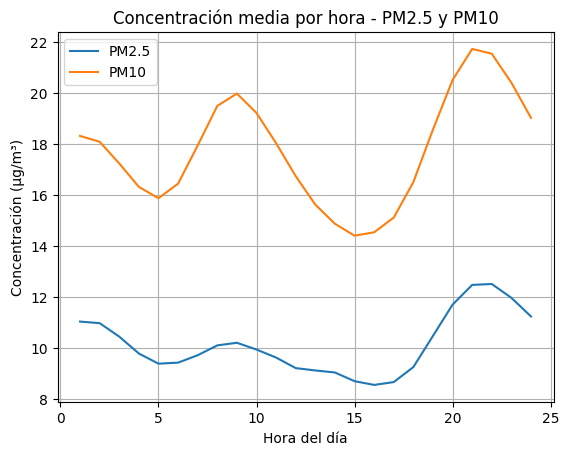

In [ ]:
contaminantes_pm = ['PM2.5', 'PM10']

for contaminante in contaminantes_pm:
    datos = df_aire[df_aire['magnitud'] == contaminante][horas]
    medias = datos.mean()
    plt.plot(range(1, 25), medias, label=contaminante)

plt.title('Concentración media por hora - PM2.5 y PM10')
plt.xlabel('Hora del día')
plt.ylabel('Concentración (µg/m³)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

El material particulado sí tiene más diferencia de concentraciones entre PM10 y PM2.5, siendo Pm10 mucho más alta, aunque mantiene una distribución horaria parecida. La concentración varía bastante durante el día con picos máximos a primeras horas de la mañana (09:00) y últimas de la tarde/primera de la noche (21:00-22:00), por lo que genera más o menos un intervalo de 12 horas (medio día) entre picos máximos. Los mínimos se encuentran en ambos casos entre las 15:00 y las 16:00.

Los municipios con mayor concentración son lejanos al centro (menos Leganés) y vuelven a ser municipios bastante poblados.

Top 5 municipios con mayor concentración de PM (material particulado):
municipio
ARGANDA DEL REY      20.749076
RIVAS-VACIAMADRID    20.388836
FUENLABRADA          20.012176
ARANJUEZ             18.511220
LEGANÉS              18.189678
dtype: float64


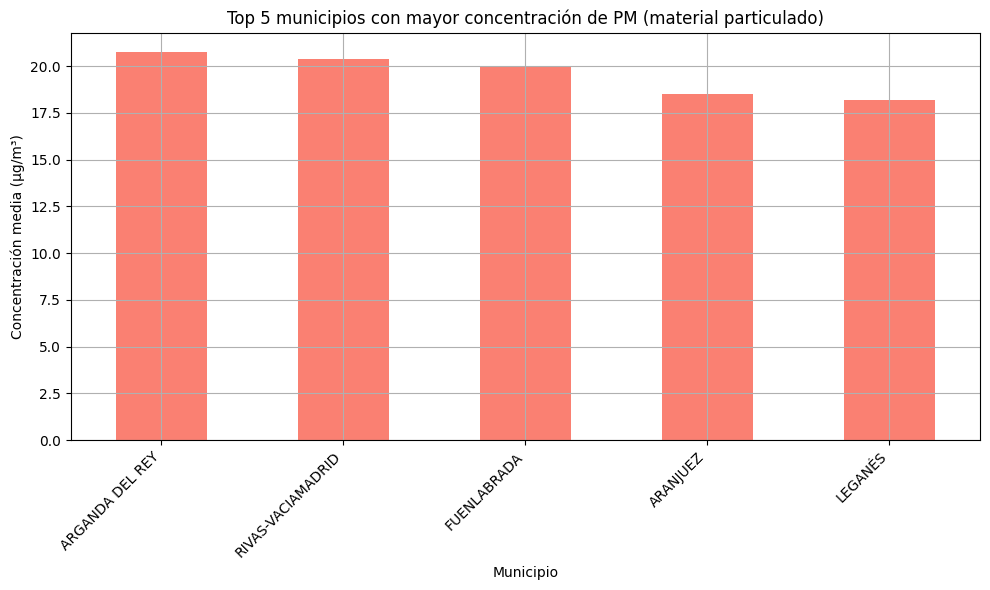

In [50]:
contaminantes_pm = df_aire[df_aire['magnitud'].isin(['PM2.5', 'PM10'])][['municipio'] + horas]

media_pm = contaminantes_pm.groupby('municipio').mean()
concentracion_pm = media_pm.mean(axis=1)
top_pm_municipios = concentracion_pm.sort_values(ascending=False).head(5)

print("Top 5 municipios con mayor concentración de PM (material particulado):")
print(top_pm_municipios)

top_pm_municipios.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Top 5 municipios con mayor concentración de PM (material particulado)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 5 municipios con menor concentración de PM (material particulado):
municipio
PUERTO DE COTOS       7.786393
POZUELO DE ALARCÓN    9.418803
ATAZAR, EL            9.465766
ALGETE                9.798451
ALCORCÓN              9.923953
dtype: float64


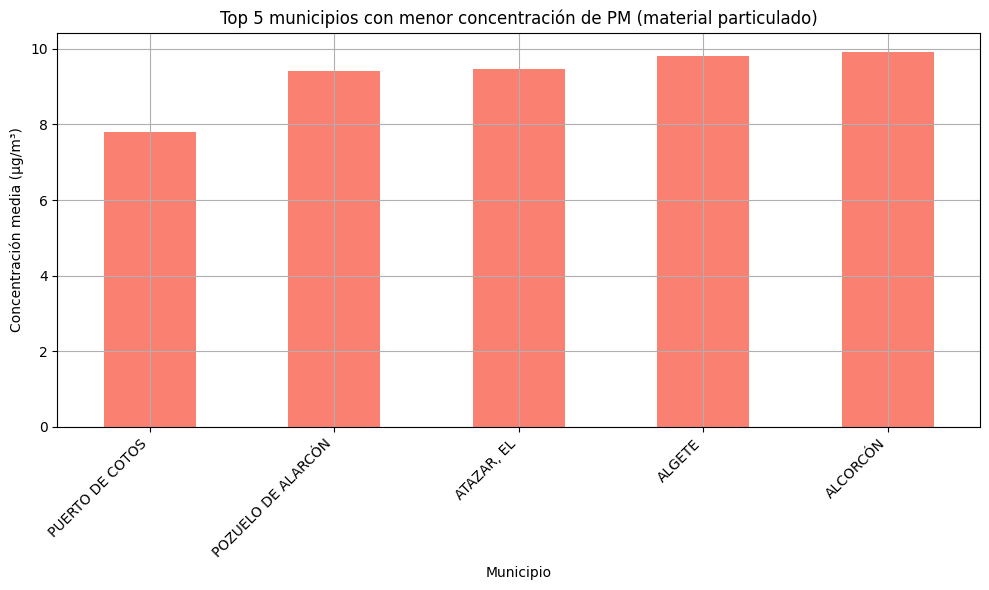

In [51]:
low_pm_municipios = concentracion_pm.sort_values(ascending=True).head(5)

print("Top 5 municipios con menor concentración de PM (material particulado):")
print(low_pm_municipios)

low_pm_municipios.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Top 5 municipios con menor concentración de PM (material particulado)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

DIÓXIDO DE AZUFRE (SO2)

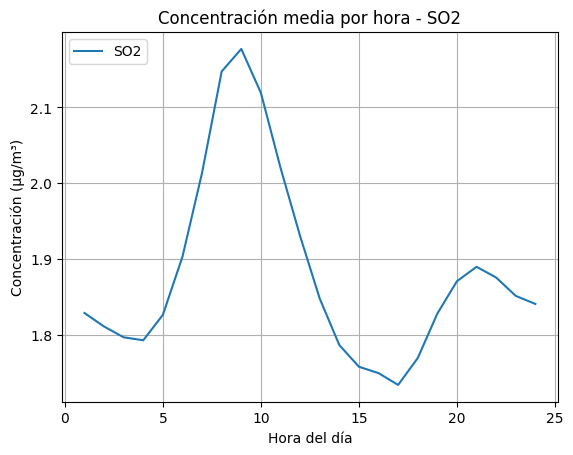

In [52]:
contaminantes_SO = df_aire[df_aire['magnitud'] == 'SO2'][horas]
medias = contaminantes_SO.mean()

plt.plot(range(1, 25), medias, label='SO2')
plt.title('Concentración media por hora - SO2')
plt.xlabel('Hora del día')
plt.ylabel('Concentración (µg/m³)')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Las concentraciones de dióxido de azufre son más estables, donde solo sobresale el pico máximo a las 9:00 de la mañana. Tiene otro pequeño pico algo más alto en trono a las 21:00 horas y un mínimo por la tarde a las 17:00.

Los municipios con mayor concentración de SO2 están bastante alejados del centro de Madrid, son lugares con no muchos habitantes (excepto Alcalá de Henares) y predominan municipios del norte de Madrid

Top 5 municipios con mayor concentración de SO2 (dióxido de azufre):
municipio
ALCALÁ DE HENARES    2.437842
VILLA DEL PRADO      2.005939
ORUSCO DE TAJUÑA     1.937051
COLLADO VILLALBA     1.855089
ATAZAR, EL           1.625341
dtype: float64


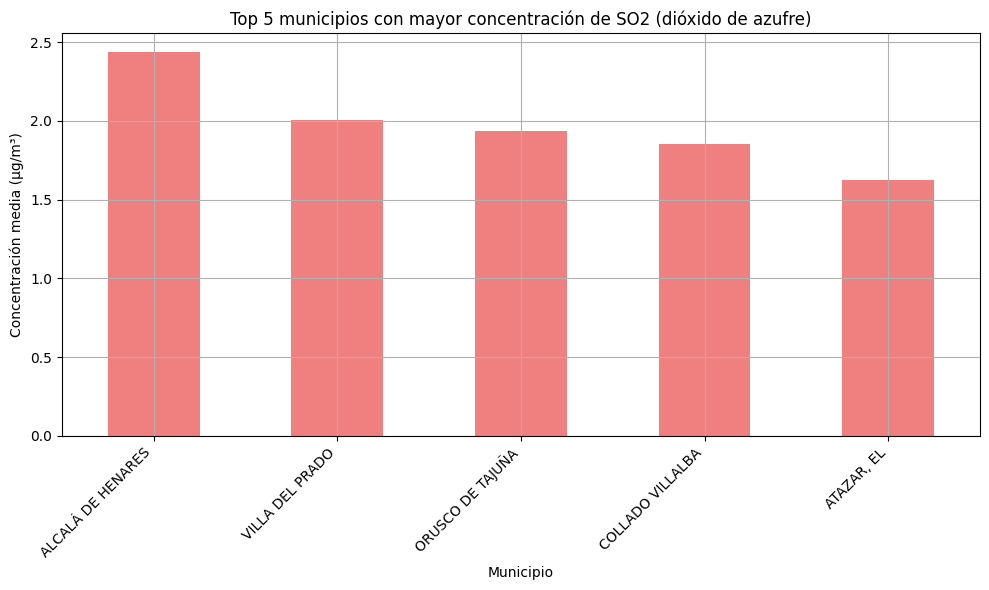

In [53]:
contaminantes_so2 = df_aire[df_aire['magnitud'] == 'SO2'][['municipio'] + horas]

media_so2 = contaminantes_so2.groupby('municipio').mean()
concentracion_so2 = media_so2.mean(axis=1)
top_so2_municipios = concentracion_so2.sort_values(ascending=False).head(5)

print("Top 5 municipios con mayor concentración de SO2 (dióxido de azufre):")
print(top_so2_municipios)

top_so2_municipios.plot(kind='bar', figsize=(10, 6), color='lightcoral')
plt.title('Top 5 municipios con mayor concentración de SO2 (dióxido de azufre)')
plt.xlabel('Municipio')
plt.ylabel('Concentración media (µg/m³)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

OTROS CONTAMINANTES

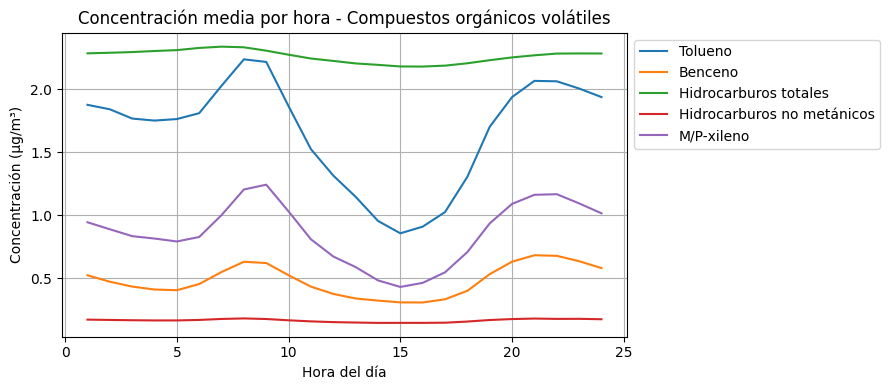

In [54]:
contaminantes_otros = ['Tolueno', 'Carbón', 'Benceno', 'Hidrocarburos totales', 'Hidrocarburos no metánicos', 'M/P-xileno']
horas = [f'h{str(i).zfill(2)}' for i in range(1, 25)]
plt.figure(figsize=(9, 4))

for contaminante in contaminantes_otros:
    datos = df_aire[df_aire['magnitud'] == contaminante][horas]
    if not datos.empty:
        medias = datos.mean()
        plt.plot(range(1, 25), medias, label=contaminante)

plt.title('Concentración media por hora - Compuestos orgánicos volátiles')
plt.xlabel('Hora del día')
plt.ylabel('Concentración (µg/m³)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Estos últimos contaminantes tienen concentraciones muy bajas. La más alta son los hidrocarburos totales, pero al ser la suma de hidrocarburos. Entonces, el más alto e inestable horariamente es el Tolueno. Los hidrocarburos no metánicos son el contaminante menos significativo, tanto en cantidad total como en distribución horaria, siendo casi plana su representación

In [55]:
df_aire_grouped = df_aire.groupby('municipio')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 
                                               'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 
                                               'h21', 'h22', 'h23', 'h24']].mean()

df_aire_grouped['concentracion_media'] = df_aire_grouped.mean(axis=1)

top_municipios = df_aire_grouped.sort_values('concentracion_media', ascending=False)

print("Top municipios con mayor concentración media de contaminación:")
top_municipios[['concentracion_media']].head(10)

Top municipios con mayor concentración media de contaminación:


concentracion_media
municipio                             
LEGANÉS                      36.165919
COSLADA                      36.156063
RIVAS-VACIAMADRID            35.929056
GETAFE                       35.047566
ALCORCÓN                     28.956560
PARLA                        28.467633
TORREJÓN DE ARDOZ            27.070870
MAJADAHONDA                  26.981781
VALDEMORO                    26.751778
ARGANDA DEL REY              26.406131

Se observa que los municipios con más contaminación total son municipios de la mitad inferior de la zona geográfica madrileña, es decir, de la zona sur. Además son zonas con bastante industria, tráfico de vehículos y población grande. La excepción es Majadahonda, que pertenece a la zona norte y es más urbana que industrial. Por el contrario, los municipios con menores concentraciones de contaminantes son muchos de la zona norte y los que no lo son están más cercanos a otras comunidades que a la ciudad de Madrid. Son zonas más naturaes, de sierra, menor tráfico y más eventos meteorológicos. La excepción aquí es Fuenlabrada, que es zona sur, bastante industrial y habitada y con mucho tráfico.

In [56]:
low_municipios = df_aire_grouped.sort_values('concentracion_media', ascending=True)

print("Top municipios con menor concentración media de contaminación:")
low_municipios[['concentracion_media']].head(10)

Top municipios con menor concentración media de contaminación:


concentracion_media
municipio                                       
ATAZAR, EL                              9.144876
VILLA DEL PRADO                        14.303564
COLLADO VILLALBA                       15.097578
ORUSCO DE TAJUÑA                       15.392541
ALCOBENDAS                             16.457422
FUENLABRADA                            17.294576
SAN SEBASTIÁN DE LOS REYES             18.341825
PUERTO DE COTOS                        18.474607
SAN MARTÍN DE VALDEIGLESIAS            20.900352
GUADALIX DE LA SIERRA                  21.087706

Para ver todo el conjunto de una forma más visual de los contaminantes y municipios, pintamos la siguiente gráfica:

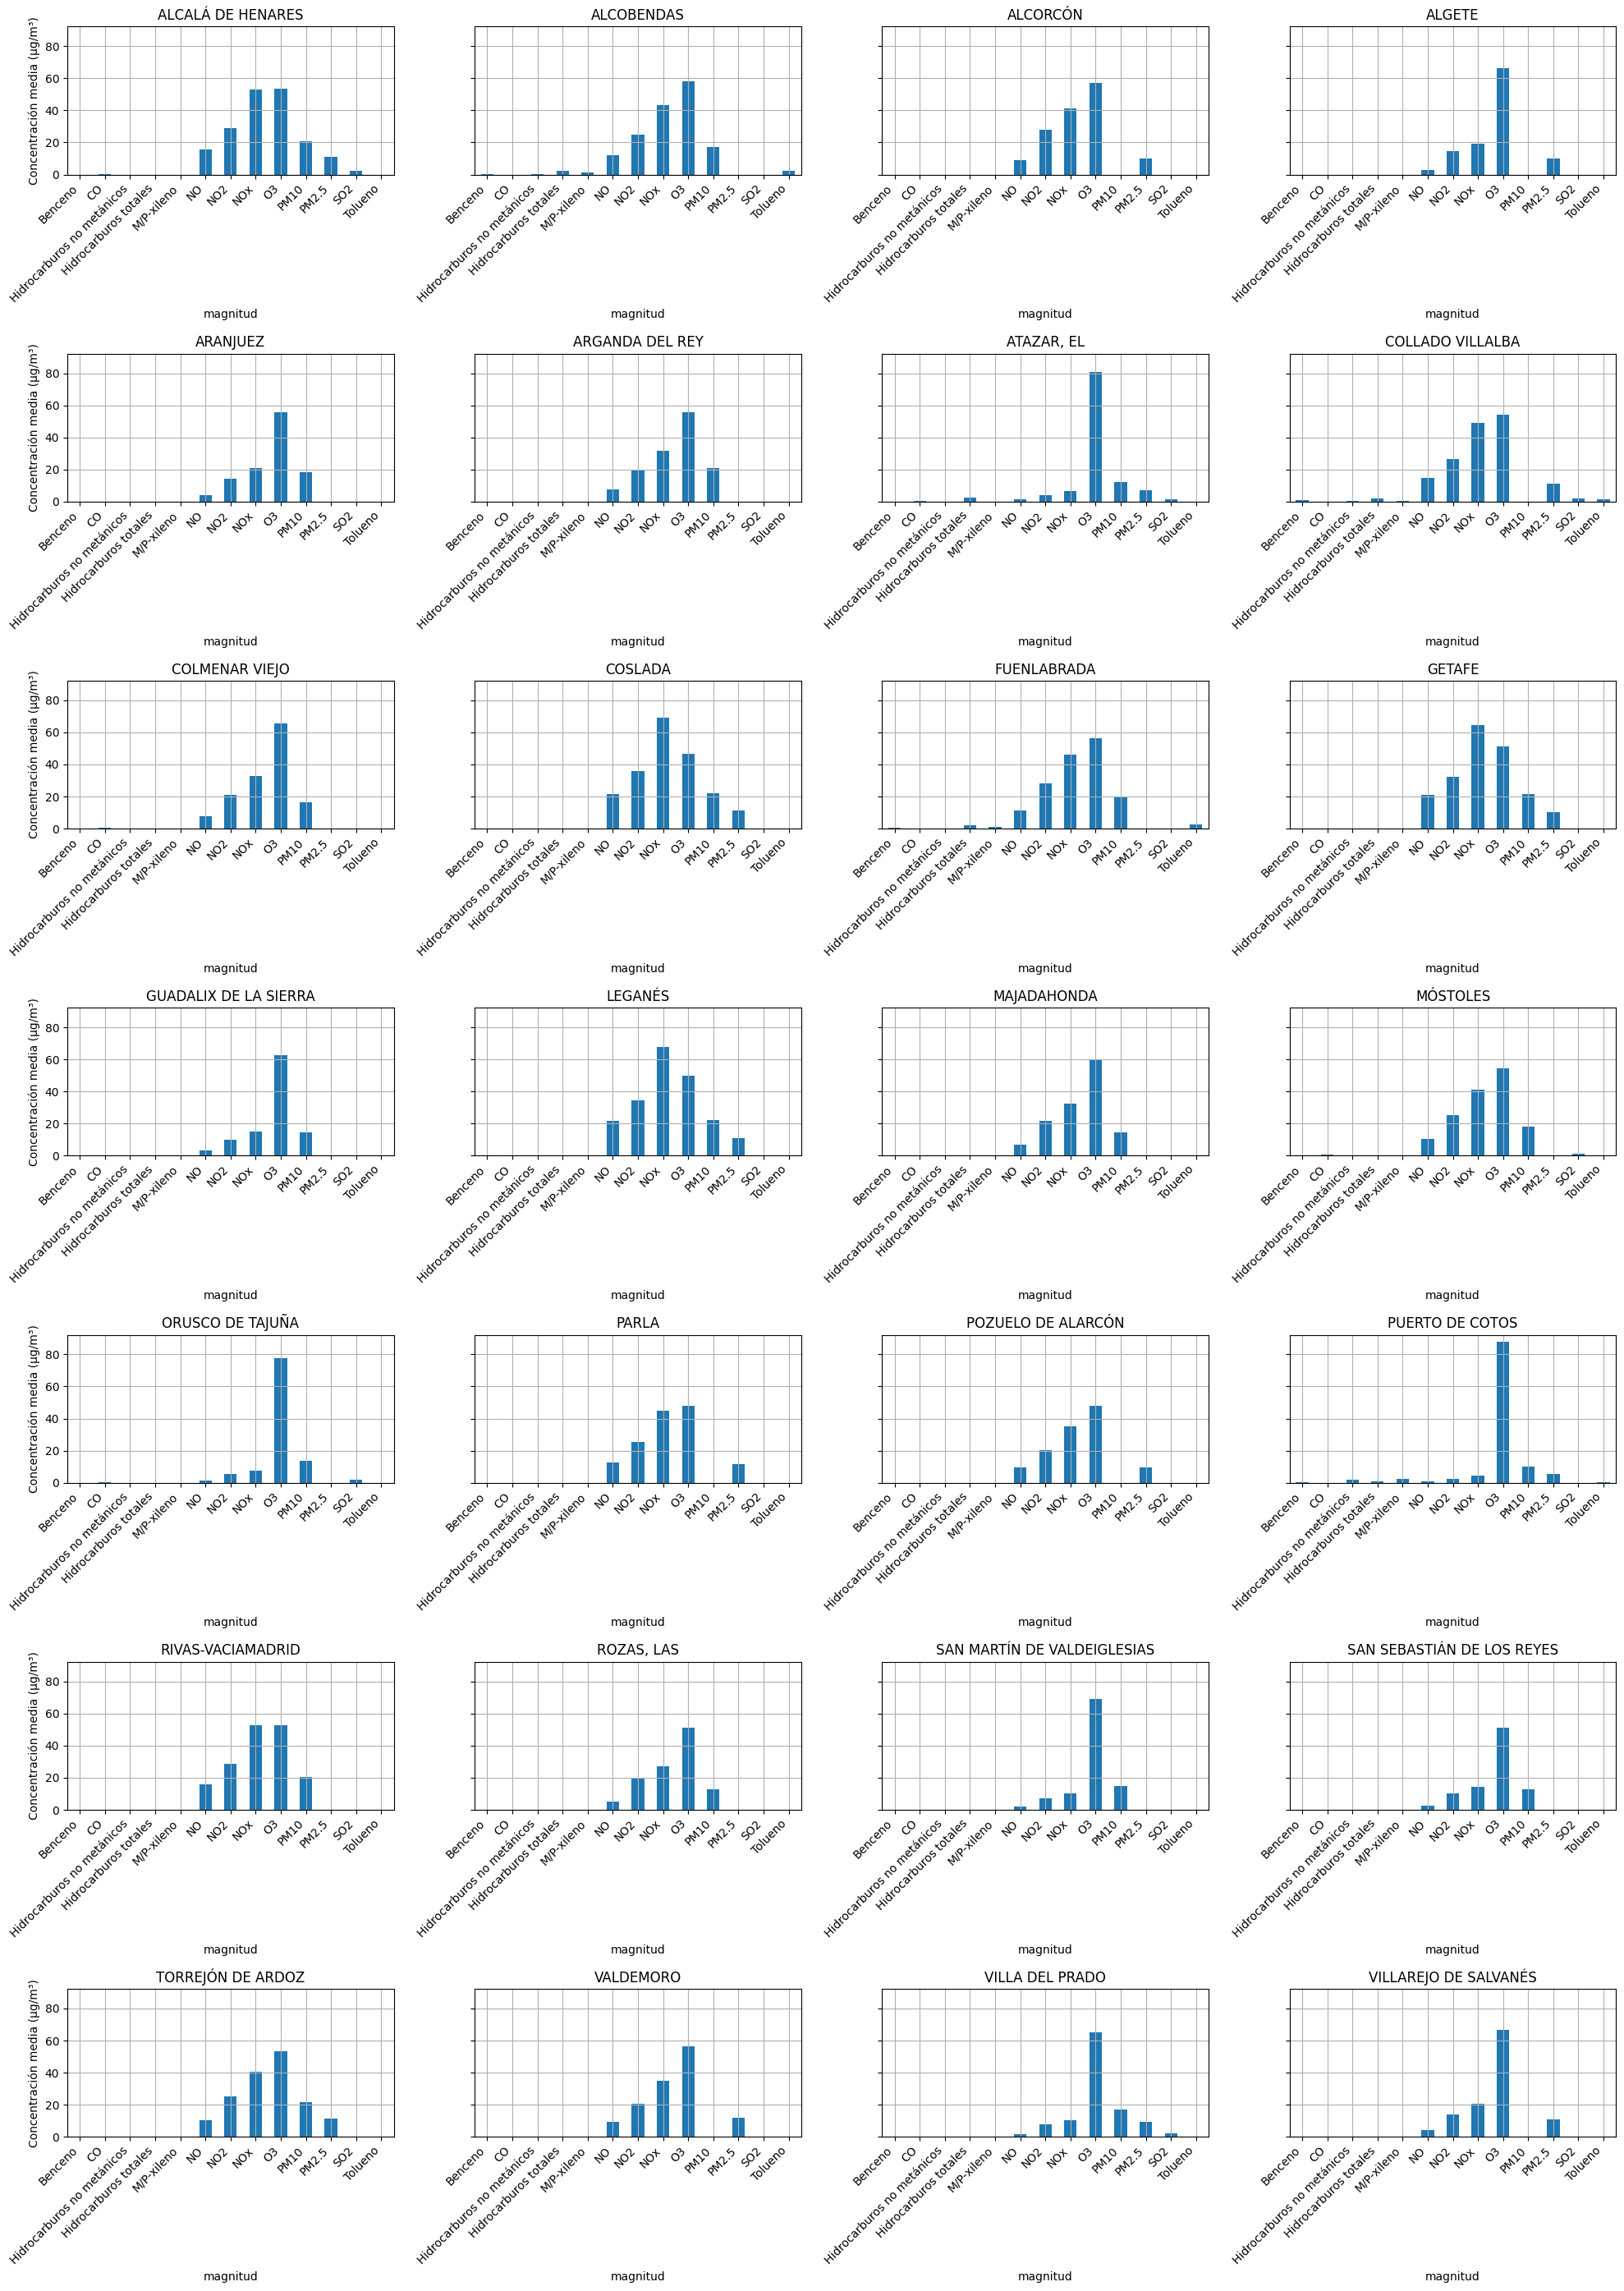

In [57]:
df_grouped = df_aire.groupby(['municipio', 'magnitud'])[horas].mean().mean(axis=1).unstack()

municipios = df_grouped.index.tolist()
n_municipios = len(municipios)

n_cols = 4
n_rows = math.ceil(n_municipios / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=True)
axes = axes.flatten()

for i, municipio in enumerate(municipios):
    ax = axes[i]
    df_grouped.loc[municipio].plot(kind='bar', ax=ax)
    ax.set_title(f'{municipio}')
    ax.set_ylabel('Concentración media (µg/m³)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

____

## DATASET RELATIVO A LA METEOROLOGÍA


In [58]:
ruta = 'datasets datos meteo/*.csv'

archivos_csv = glob.glob(ruta)

dataframes = []
for archivo in archivos_csv:
    try:
        df = pd.read_csv(archivo, sep=';', decimal=',') 
        dataframes.append(df)
    except Exception as e:
        print(f"Error en el archivo {archivo}: {e}")


df_meteo = pd.concat(dataframes, ignore_index=True)
df_meteo

provincia  municipio  estacion  magnitud  punto_muestreo   ano  mes  \
0              28        102         1        81  28102001_81_89  2020    1   
1              28        102         1        82  28102001_82_89  2020    1   
2              28        102         1        83  28102001_83_89  2020    1   
3              28        102         1        86  28102001_86_89  2020    1   
4              28        102         1        87  28102001_87_89  2020    1   
...           ...        ...       ...       ...             ...   ...  ...   
335804         28         92         5        83  28092005_83_89  2025    2   
335805         28         92         5        86  28092005_86_89  2025    2   
335806         28         92         5        87  28092005_87_89  2025    2   
335807         28         92         5        88  28092005_88_89  2025    2   
335808         28         92         5        89  28092005_89_89  2025    2   

        dia    h01 v01  ...    h20 v20    h21 v21    h22 v22    h23 v23  \
0         1    1.1   V  ...    0.2   V    0.3   V    0.9   V    0.7   V   
1         1   15.0   V  ...  291.0   V    3.0   V  359.0   V   18.0   V   
2         1    2.7   V  ...    7.3   V    6.3   V    5.3   V    4.3   V   
3         1   86.0   V  ...   68.0   V   74.0   V   81.0   V   86.0   V   
4         1  946.0   V  ...  944.0   V  945.0   V  945.0   V  945.0   V   
...     ...    ...  ..  ...    ...  ..    ...  ..    ...  ..    ...  ..   
335804   28    3.1   V  ...    8.1   V    7.3   V    6.6   V    6.1   V   
335805   28   73.0   V  ...   53.0   V   56.0   V   59.0   V   62.0   V   
335806   28  943.0   V  ...  938.0   V  939.0   V  939.0   V  939.0   V   
335807   28    2.0   V  ...    1.0   V    2.0   V    2.0   V    2.0   V   
335808   28    0.0   V  ...    0.0   V    0.0   V    0.0   V    0.0   V   

          h24 v24  
0         0.4   V  
1        27.0   V  
2         4.2   V  
3        85.0   V  
4       944.0   V  
...       ...  ..  
335804    5.5   V  
335805   64.0   V  
335806  940.0   V  
335807    2.0   V  
335808    0.0   V  

[335809 rows x 56 columns]

#### Limpieza, calidad y comprobación del dataframe

In [59]:
df_meteo.shape

(335809, 56)

In [60]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335809 entries, 0 to 335808
Data columns (total 56 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   provincia       335809 non-null  int64 
 1   municipio       335809 non-null  int64 
 2   estacion        335809 non-null  int64 
 3   magnitud        335809 non-null  int64 
 4   punto_muestreo  335809 non-null  object
 5   ano             335809 non-null  int64 
 6   mes             335809 non-null  int64 
 7   dia             335809 non-null  int64 
 8   h01             334238 non-null  object
 9   v01             335809 non-null  object
 10  h02             334226 non-null  object
 11  v02             335809 non-null  object
 12  h03             334070 non-null  object
 13  v03             335809 non-null  object
 14  h04             334031 non-null  object
 15  v04             335809 non-null  object
 16  h05             333943 non-null  object
 17  v05             335809 non-nu

In [61]:
df_meteo.columns

Index(['provincia', 'municipio', 'estacion', 'magnitud', 'punto_muestreo',
       'ano', 'mes', 'dia', 'h01', 'v01', 'h02', 'v02', 'h03', 'v03', 'h04',
       'v04', 'h05', 'v05', 'h06', 'v06', 'h07', 'v07', 'h08', 'v08', 'h09',
       'v09', 'h10', 'v10', 'h11', 'v11', 'h12', 'v12', 'h13', 'v13', 'h14',
       'v14', 'h15', 'v15', 'h16', 'v16', 'h17', 'v17', 'h18', 'v18', 'h19',
       'v19', 'h20', 'v20', 'h21', 'v21', 'h22', 'v22', 'h23', 'v23', 'h24',
       'v24'],
      dtype='object')

La provincia es la misma para todos los registros, ya que son todos los municipios de la comunidad de Madrid, por lo que no lo necesitamos. La estación va asociada solo al municipio, por lo que tampoco nos hace falta y el punto de muestreo es una etiqueta que no considero necesaria para la predicción, ya que es una suma de números de las anteriores variables.

Ya que las columna que contienen 'v' son únicamente para conocer la validación de los datos, no lo vamos a necesitar, ya que más adelante comprobaremos los nulos. Así que procedemos a eliminar estas columnas.

Aparte, creo que no es necesario realizar cambios de nombre en la columnas, ya que son bastante descriptivos y cumplen con el formato PEP8

In [62]:
df_meteo = df_meteo.drop(columns=['provincia', 'estacion', 'punto_muestreo', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24'])

hacemos la mismo operación para la fecha que con df_aire, juntandolo en una sola columna

In [63]:
df_meteo['fecha'] = pd.to_datetime(
    df_meteo.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'})[['year', 'month', 'day']]
)

In [64]:
df_meteo.drop(columns=['ano', 'mes', 'dia'], inplace=True)

Transformamos la columna de municipio de variable numérica a nominal y hacemos la transformación también con las medidas, creando de nuevo un diccionario para ellas. Además prescindiremos de la variable de 'dirección del viento', ya que solo nos interesa la velocidad del mismo

In [65]:
df_meteo['municipio'] = df_meteo['municipio'].map(dic_municipios)

In [66]:
df_meteo.rename(columns={'magnitud': 'medida'}, inplace=True)

In [67]:
dic_medida = {
    81: 'Velocidad del viento (m/s)',
    82: 'Dirección del viento (Grd)',
    83: 'Temperatura (ºC)',
    86: 'Humedad relativa (%)',
    87: 'Presión atmosférica (mbar)',
    88: 'Radiación solar (W/m²)',
    89: 'Precipitación'
}

df_meteo['medida'] = df_meteo['medida'].replace(dic_medida)

In [68]:
df_meteo = df_meteo[~df_meteo['medida'].isin(['Dirección del viento (Grd)'])]

In [69]:
df_meteo

municipio                      medida    h01    h02    h03  \
0       ORUSCO DE TAJUÑA  Velocidad del viento (m/s)    1.1    1.0    1.1   
2       ORUSCO DE TAJUÑA            Temperatura (ºC)    2.7    2.6    2.1   
3       ORUSCO DE TAJUÑA        Humedad relativa (%)   86.0   87.0   89.0   
4       ORUSCO DE TAJUÑA  Presión atmosférica (mbar)  946.0  946.0  945.0   
5       ORUSCO DE TAJUÑA      Radiación solar (W/m²)   12.0   12.0   12.0   
...                  ...                         ...    ...    ...    ...   
335804          MÓSTOLES            Temperatura (ºC)    3.1    2.3    2.4   
335805          MÓSTOLES        Humedad relativa (%)   73.0   76.0   74.0   
335806          MÓSTOLES  Presión atmosférica (mbar)  943.0  943.0  941.0   
335807          MÓSTOLES      Radiación solar (W/m²)    2.0    2.0    2.0   
335808          MÓSTOLES               Precipitación    0.0    0.0    0.0   

          h04    h05    h06    h07    h08  ...    h16    h17    h18    h19  \
0         1.0    1.2    1.2    1.5    1.6  ...    0.8    0.8    1.3    0.7   
2         1.9    1.6    1.6    0.0    0.1  ...   13.9   11.9    8.6    7.5   
3        91.0   92.0   92.0   96.0   96.0  ...   43.0   53.0   63.0   68.0   
4       945.0  944.0  945.0  946.0  947.0  ...  943.0  944.0  944.0  944.0   
5        12.0   12.0   12.0   12.0   22.0  ...  260.0  103.0   14.0   13.0   
...       ...    ...    ...    ...    ...  ...    ...    ...    ...    ...   
335804    2.2    2.0    1.6    2.1    2.8  ...   14.3   13.0   10.7    9.2   
335805   74.0   75.0   76.0   73.0   71.0  ...   35.0   37.0   42.0   48.0   
335806  941.0  940.0  941.0  941.0  941.0  ...  937.0  937.0  938.0  938.0   
335807    2.0    2.0    2.0    3.0   80.0  ...  312.0  136.0   36.0    1.0   
335808    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   

          h20    h21    h22    h23    h24      fecha  
0         0.2    0.3    0.9    0.7    0.4 2020-01-01  
2         7.3    6.3    5.3    4.3    4.2 2020-01-01  
3        68.0   74.0   81.0   86.0   85.0 2020-01-01  
4       944.0  945.0  945.0  945.0  944.0 2020-01-01  
5        13.0   13.0   13.0   13.0   13.0 2020-01-01  
...       ...    ...    ...    ...    ...        ...  
335804    8.1    7.3    6.6    6.1    5.5 2025-02-28  
335805   53.0   56.0   59.0   62.0   64.0 2025-02-28  
335806  938.0  939.0  939.0  939.0  940.0 2025-02-28  
335807    1.0    2.0    2.0    2.0    2.0 2025-02-28  
335808    0.0    0.0    0.0    0.0    0.0 2025-02-28  

[287835 rows x 27 columns]

In [70]:
df_meteo.dtypes

municipio            object
medida               object
h01                  object
h02                  object
h03                  object
h04                  object
h05                  object
h06                  object
h07                  object
h08                  object
h09                  object
h10                  object
h11                  object
h12                  object
h13                  object
h14                  object
h15                  object
h16                  object
h17                  object
h18                  object
h19                  object
h20                  object
h21                  object
h22                  object
h23                  object
h24                  object
fecha        datetime64[ns]
dtype: object

In [71]:
columnas_hora = [f'h{i:02}' for i in range(1, 25)]

for col in columnas_hora:
    df_meteo[col] = pd.to_numeric(df_meteo[col], errors='coerce')


In [72]:
df_meteo.dtypes

municipio            object
medida               object
h01                 float64
h02                 float64
h03                 float64
h04                 float64
h05                 float64
h06                 float64
h07                 float64
h08                 float64
h09                 float64
h10                 float64
h11                 float64
h12                 float64
h13                 float64
h14                 float64
h15                 float64
h16                 float64
h17                 float64
h18                 float64
h19                 float64
h20                 float64
h21                 float64
h22                 float64
h23                 float64
h24                 float64
fecha        datetime64[ns]
dtype: object

DUPLICADOS

In [73]:
df_meteo.duplicated().sum()

np.int64(0)

NULOS

In [74]:
df_meteo.isnull().sum()

municipio        0
medida           0
h01          17768
h02          17825
h03          18003
h04          18067
h05          18206
h06          18725
h07          18925
h08          18904
h09          18874
h10          18889
h11          18634
h12          18373
h13          18046
h14          17684
h15          17442
h16          17438
h17          17354
h18          17356
h19          17488
h20          17474
h21          17611
h22          17640
h23          17696
h24          17753
fecha            0
dtype: int64

Como hemos hecho anteriormente con df_aire, vamos a conservar en este caso los nulos, ya que ahora sólo queremos realizar un análisis básico de los datos horarios, pero mi proyecto está enfocado en el análisis y predicción diaria. Al hacer el cambio a diario, haré la inputación de nulos

____
#### ANÁLISIS METEOROLÓGICO HORARIO

In [75]:
revision_medida = df_meteo.groupby('medida')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                           'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                           'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].mean()

revision_medida.T

medida  Humedad relativa (%)  Precipitación  Presión atmosférica (mbar)  \
h01                66.183523       0.037379                  934.743418   
h02                68.037048       0.033575                  934.574897   
h03                69.718500       0.032186                  934.481049   
h04                71.317793       0.043078                  934.350510   
h05                72.700556       0.041998                  934.373213   
h06                73.606315       0.034571                  934.523069   
h07                72.629338       0.033745                  934.743215   
h08                69.348734       0.048858                  935.064752   
h09                64.272853       0.035226                  935.366885   
h10                58.656273       0.037429                  935.535508   
h11                53.809842       0.034865                  935.542600   
h12                49.700126       0.027948                  935.237254   
h13                46.539913       0.037106                  934.701371   
h14                44.431323       0.045435                  934.156179   
h15                43.346093       0.045079                  933.718924   
h16                43.296613       0.052004                  933.465354   
h17                44.685091       0.049546                  933.374137   
h18                47.809593       0.040689                  933.460928   
h19                51.399908       0.039965                  933.719471   
h20                54.765356       0.044702                  934.047277   
h21                57.644813       0.051711                  934.432045   
h22                60.015368       0.047942                  934.696177   
h23                62.156751       0.046868                  934.800515   
h24                64.188986       0.040830                  934.825006   

medida  Radiación solar (W/m²)  Temperatura (ºC)  Velocidad del viento (m/s)  
h01                   2.313816         12.279471                    1.572373  
h02                   2.339355         11.719226                    1.535998  
h03                   2.353030         11.206888                    1.506444  
h04                   2.376012         10.745808                    1.475489  
h05                   2.481776         10.330944                    1.447333  
h06                  11.269878         10.130722                    1.444205  
h07                  58.558501         10.540738                    1.480528  
h08                 159.896642         11.641900                    1.581910  
h09                 301.538640         13.231164                    1.707842  
h10                 440.898055         14.921912                    1.859162  
h11                 553.966801         16.426291                    2.017548  
h12                 622.832952         17.718825                    2.176857  
h13                 634.840193         18.705148                    2.307923  
h14                 592.965102         19.397203                    2.390391  
h15                 504.918234         19.790252                    2.418073  
h16                 377.340333         19.866074                    2.380415  
h17                 233.905646         19.455737                    2.255147  
h18                 110.506360         18.510609                    2.062220  
h19                  32.830564         17.324651                    1.862744  
h20                   4.939091         16.077001                    1.697721  
h21                   2.259960         15.047395                    1.628229  
h22                   2.271595         14.239379                    1.609544  
h23                   2.286109         13.520229                    1.605429  
h24                   2.306608         12.876478                    1.592018

Los datos recogidos están bastante balanceados, hay la misma cantidad en todos, menos en la presión atmosférica, pero que es muy pocos registros inferior

medida
Velocidad del viento (m/s)    47974
Temperatura (ºC)              47974
Humedad relativa (%)          47974
Radiación solar (W/m²)        47974
Precipitación                 47974
Presión atmosférica (mbar)    47965
Name: count, dtype: int64


C:\Users\metal\AppData\Local\Temp\ipykernel_11816\3743831906.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_meteo, x='medida', palette='Set2', order=medidas_count)


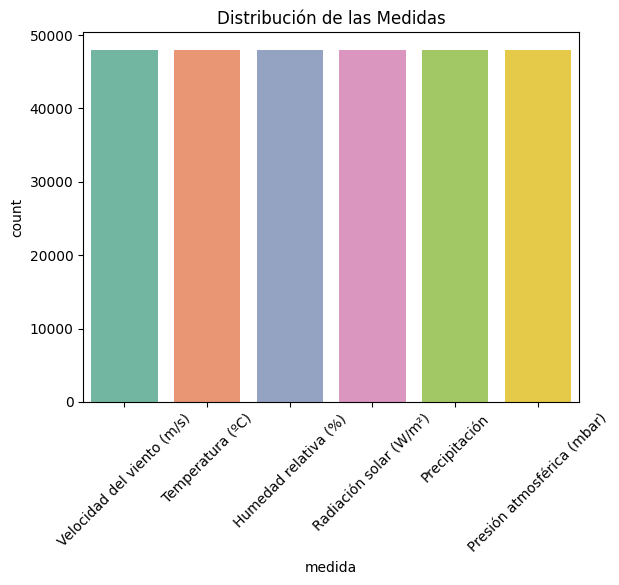

In [76]:
print(df_meteo['medida'].value_counts())

medidas_count = df_meteo['medida'].value_counts().index

sns.countplot(data=df_meteo, x='medida', palette='Set2', order=medidas_count)
plt.xticks(rotation=45)
plt.title('Distribución de las Medidas')
plt.show()

Comprobamos mínimos y máximos para cada medida de manera horaria:

In [77]:
min_medidas = df_meteo.groupby('medida')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                  'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].min()

max_medidas = df_meteo.groupby('medida')[['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
                                                  'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
                                                  'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']].max()

print("\nMínimas medidas por medida:")
min_medidas


Mínimas medidas por medida:


h01    h02    h03    h04    h05    h06    h07  \
medida                                                                        
Humedad relativa (%)          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Precipitación                 0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Presión atmosférica (mbar)  773.0  773.0  773.0  773.0  772.0  772.0  262.0   
Radiación solar (W/m²)        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Temperatura (ºC)            -40.0  -40.0  -40.0  -40.0  -40.0  -40.0  -40.0   
Velocidad del viento (m/s)    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                              h08    h09    h10  ...    h15    h16    h17  \
medida                                           ...                        
Humedad relativa (%)          0.0    0.0    0.0  ...    0.0    0.0    0.0   
Precipitación                 0.0    0.0    0.0  ...    0.0    0.0    0.0   
Presión atmosférica (mbar)  479.0  773.0  772.0  ...  777.0  777.0  717.0   
Radiación solar (W/m²)        0.0    0.0    0.0  ...    0.0    0.0    0.0   
Temperatura (ºC)            -40.0  -40.0  -40.0  ...  -40.0  -40.0  -40.0   
Velocidad del viento (m/s)    0.0    0.0    0.0  ...    0.0    0.0    0.0   

                              h18    h19    h20    h21    h22    h23    h24  
medida                                                                       
Humedad relativa (%)          0.0    0.0    0.0    0.0    0.0    0.0    0.0  
Precipitación                 0.0    0.0    0.0    0.0    0.0    0.0    0.0  
Presión atmosférica (mbar)  777.0  777.0  777.0  777.0  776.0  775.0  774.0  
Radiación solar (W/m²)        0.0    0.0    0.0    0.0    0.0    0.0    0.0  
Temperatura (ºC)            -40.0  -40.0  -40.0  -40.0  -40.0  -40.0  -40.0  
Velocidad del viento (m/s)    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[6 rows x 24 columns]

In [78]:
print("Máximas medidas por medida:")
max_medidas

Máximas medidas por medida:


h01     h02     h03     h04     h05     h06  \
medida                                                                       
Humedad relativa (%)         100.0   100.0   100.0   100.0   100.0   100.0   
Precipitación                 29.1    24.6    17.0    22.4    55.0    18.8   
Presión atmosférica (mbar)  1084.0  1083.0  1098.0  1074.0  1069.0  1068.0   
Radiación solar (W/m²)      2000.0  2000.0  2000.0  2000.0  2000.0  2000.0   
Temperatura (ºC)              45.0    57.4    57.1    60.0    58.2    58.7   
Velocidad del viento (m/s)   946.5   945.8   945.8   946.0   946.0   946.0   

                               h07     h08     h09     h10  ...     h15  \
medida                                                      ...           
Humedad relativa (%)         164.0   100.0   100.0   100.0  ...   100.0   
Precipitación                 16.0   742.1    23.0    21.4  ...    70.0   
Presión atmosférica (mbar)  1066.0  1060.0  1040.0  1100.0  ...  1018.0   
Radiación solar (W/m²)      2000.0  2000.0  1871.0  2000.0  ...  2000.0   
Temperatura (ºC)              80.8    57.7    45.0    45.0  ...    45.0   
Velocidad del viento (m/s)   946.0   946.0   946.3   947.0  ...   945.0   

                               h16     h17     h18     h19     h20     h21  \
medida                                                                       
Humedad relativa (%)         100.0   100.0   100.0   100.0   100.0   100.0   
Precipitación                 41.6    22.0    28.6    25.2    32.0   184.8   
Presión atmosférica (mbar)  1034.0  1021.0  1079.0  1100.0  1100.0  1100.0   
Radiación solar (W/m²)      2000.0  2000.0  2000.0  2000.0  2000.0  2000.0   
Temperatura (ºC)              45.0    45.0    45.0    45.0    45.0    45.0   
Velocidad del viento (m/s)   945.0   944.5   945.0   945.0   945.3   946.0   

                               h22     h23     h24  
medida                                              
Humedad relativa (%)         100.0   100.0   100.0  
Precipitación                 23.7    37.0    25.6  
Presión atmosférica (mbar)  1100.0  1100.0  1097.0  
Radiación solar (W/m²)      2000.0  2000.0  2000.0  
Temperatura (ºC)              45.0    45.0    45.0  
Velocidad del viento (m/s)   946.3   946.8   947.0  

[6 rows x 24 columns]

In [79]:
df_meteo['medida'].describe()

count                         287835
unique                             6
top       Velocidad del viento (m/s)
freq                           47974
Name: medida, dtype: object

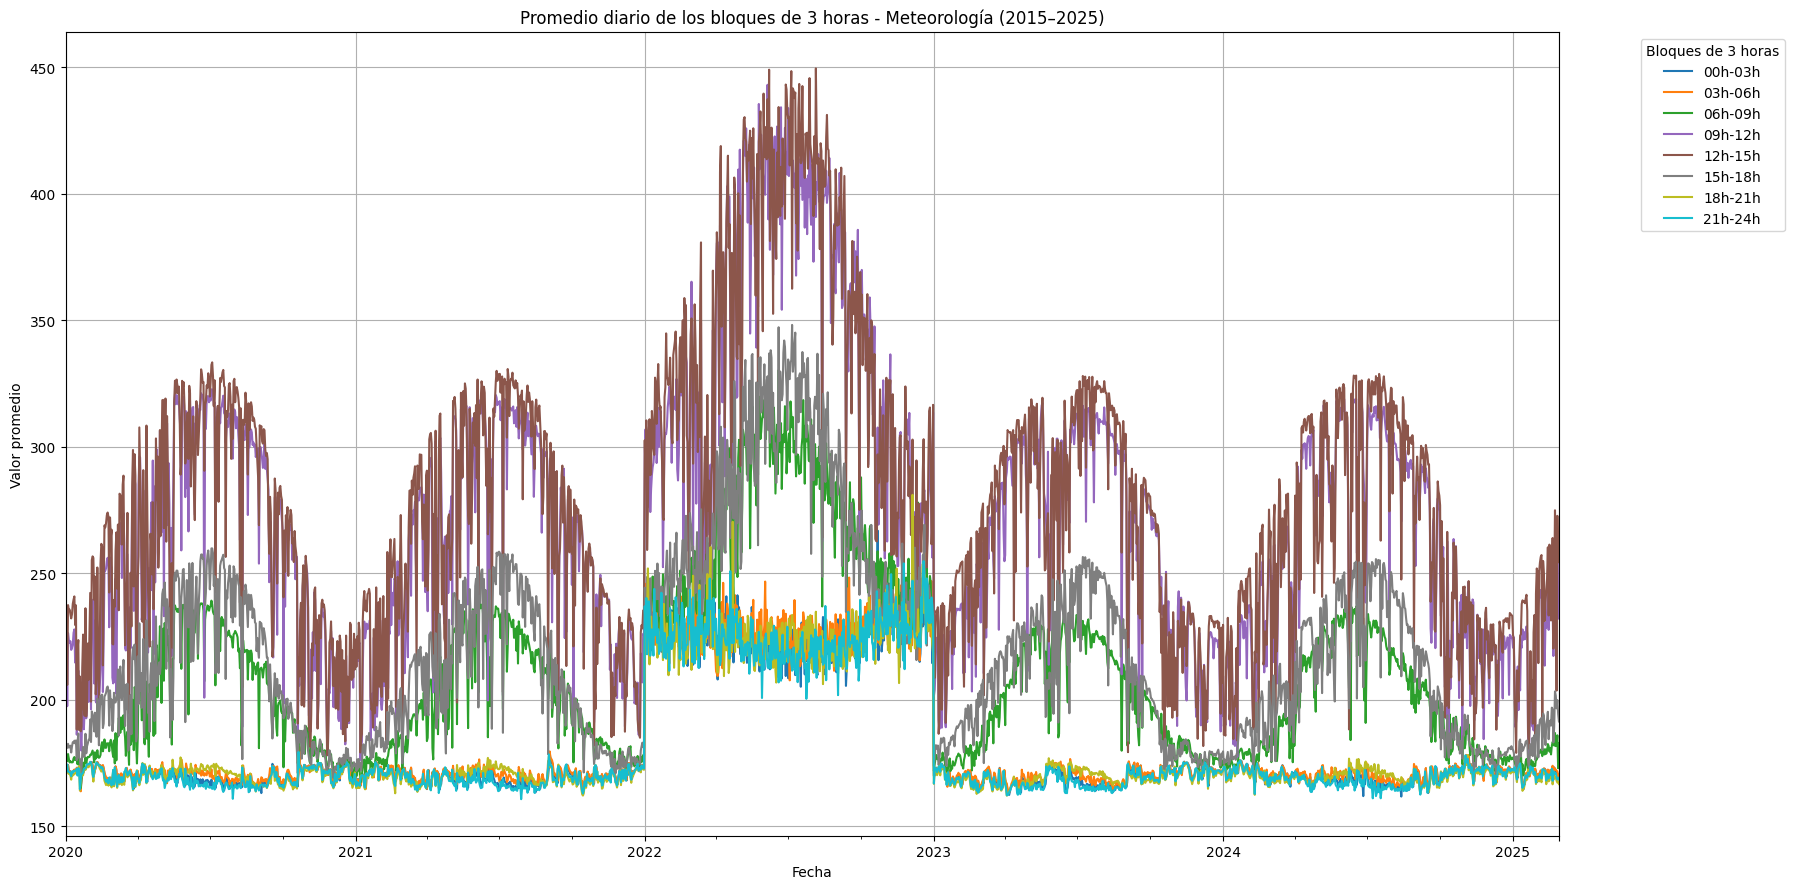

In [80]:
df_meteo['fecha'] = pd.to_datetime(df_meteo['fecha'])

bloques_horas = [
    ['h01', 'h02', 'h03'],
    ['h04', 'h05', 'h06'],
    ['h07', 'h08', 'h09'],
    ['h10', 'h11', 'h12'],
    ['h13', 'h14', 'h15'],
    ['h16', 'h17', 'h18'],
    ['h19', 'h20', 'h21'],
    ['h22', 'h23', 'h24']
]

df_meteo_bloques = pd.DataFrame()
for i, bloque in enumerate(bloques_horas):
    nombre = f'{str(i*3).zfill(2)}h-{str((i+1)*3).zfill(2)}h'
    df_meteo_bloques[nombre] = df_meteo[bloque].mean(axis=1)

df_meteo_bloques['fecha'] = df_meteo['fecha']
df_meteo_bloques.set_index('fecha', inplace=True)

df_resampled = df_meteo_bloques.resample('D').mean()

fig, ax = plt.subplots(figsize=(18, 9))
df_resampled.plot(ax=ax, cmap='tab10')
ax.set_title('Promedio diario de los bloques de 3 horas - Meteorología (2015–2025)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor promedio')
ax.legend(title='Bloques de 3 horas', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

Aqui tenemos un claro error con los datos de 2022. Después de analizarlo, buscar nulos, valores extremos o valores erróneos se llega a la conclusión de que son valores muy inflados ese año, quizás por utilizar otra medida o errores en algunos captadores, por lo que procedo a realizar un reescalada para 2022

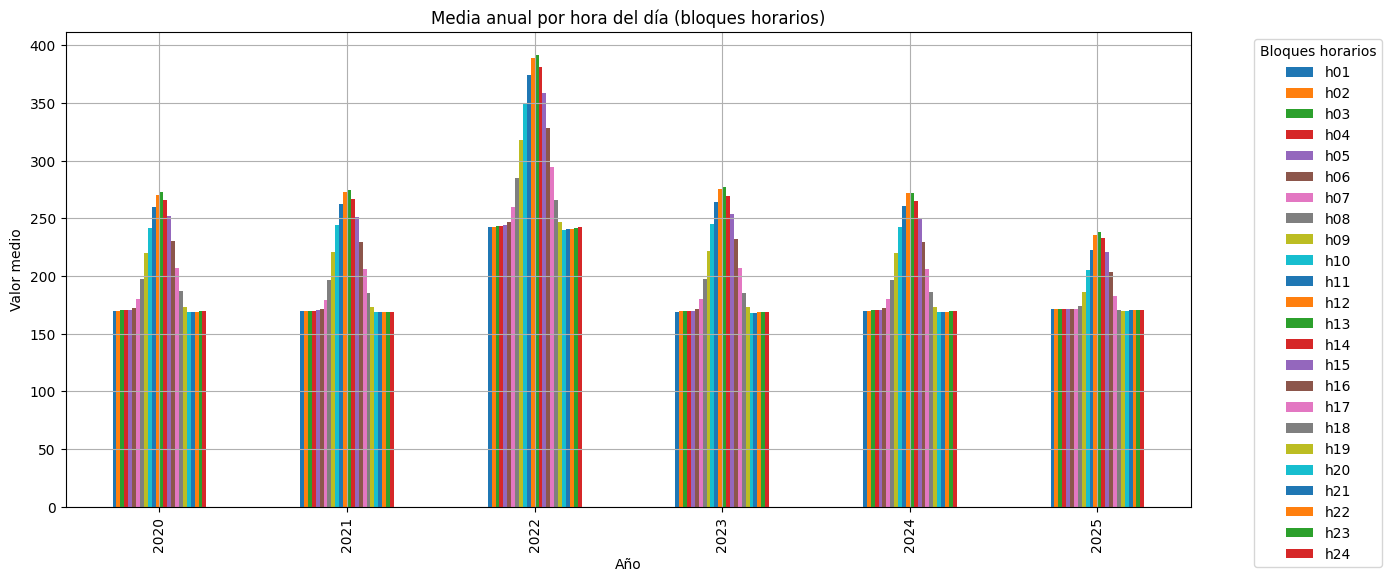

In [81]:
df_meteo['fecha'] = pd.to_datetime(df_meteo['fecha'], errors='coerce')
df_meteo['ano'] = df_meteo['fecha'].dt.year

bloques_horarios = [f"h{str(i).zfill(2)}" for i in range(1, 25)]

for col in bloques_horarios:
    df_meteo[col] = pd.to_numeric(df_meteo[col], errors='coerce')

media_por_anio = df_meteo.groupby('ano')[bloques_horarios].mean()

media_por_anio.plot(kind='bar', figsize=(14, 6))
plt.title("Media anual por hora del día (bloques horarios)")
plt.ylabel("Valor medio")
plt.xlabel("Año")
plt.legend(title="Bloques horarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

La distribución de los fenómenos meteorológicos siguen un patrón bastante parecido en los años. Las horas donde menos actividad meteorológica vemos es en la madrugada (entre las 00:00 y las 06:00) y de noche (de 20:00 a 24:00), mientras las que tienen mayores registros meteorológicos son las de la mañana y tarde entre las 9 y 17 horas, algo menos entre las 18 y las 20 horas y entre las 7 y las 9h por la mañana, que son considerablemente más bajas y podemos decir que moderadas.

En 2025 se ve un descenso porque los datos son solo hasta Marzo de ese año, por lo que faltan datos al completo de ese año

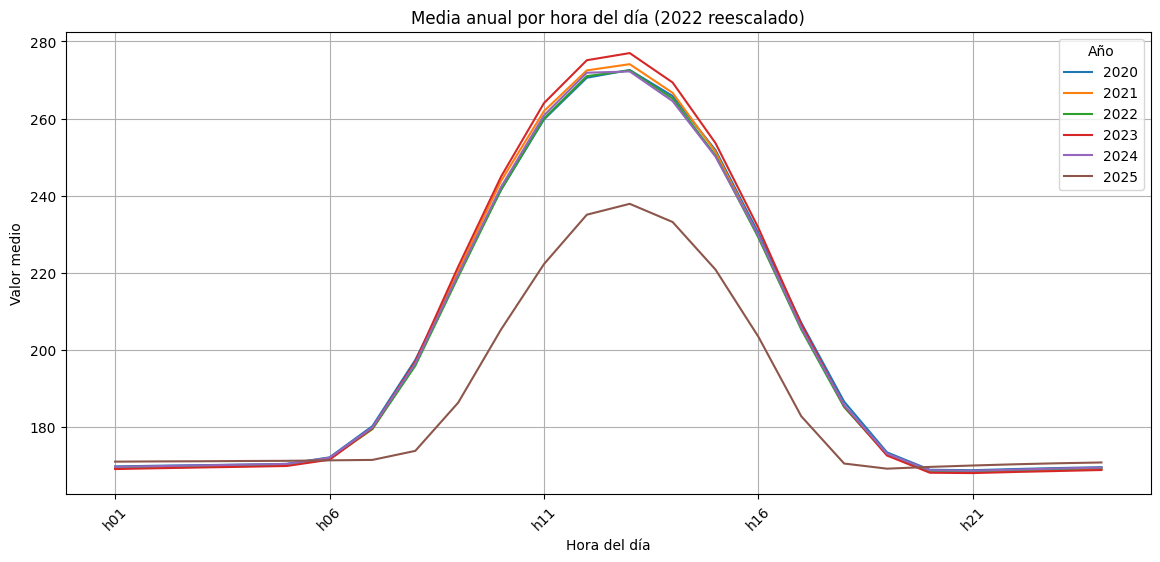

In [82]:
media_otros = df_meteo[df_meteo['fecha'].dt.year != 2022][bloques_horarios].mean()
media_2022 = df_meteo[df_meteo['fecha'].dt.year == 2022][bloques_horarios].mean()

scaling_factors = media_otros / media_2022

for col in bloques_horarios:
    df_meteo.loc[df_meteo['fecha'].dt.year == 2022, col] *= scaling_factors[col]

media_por_anio = df_meteo.groupby(df_meteo['fecha'].dt.year)[bloques_horarios].mean()

media_por_anio.T.plot(figsize=(14, 6))
plt.title("Media anual por hora del día (2022 reescalado)")
plt.ylabel("Valor medio")
plt.xlabel("Hora del día")
plt.grid(True)
plt.legend(title="Año")
plt.xticks(rotation=45)
plt.show()

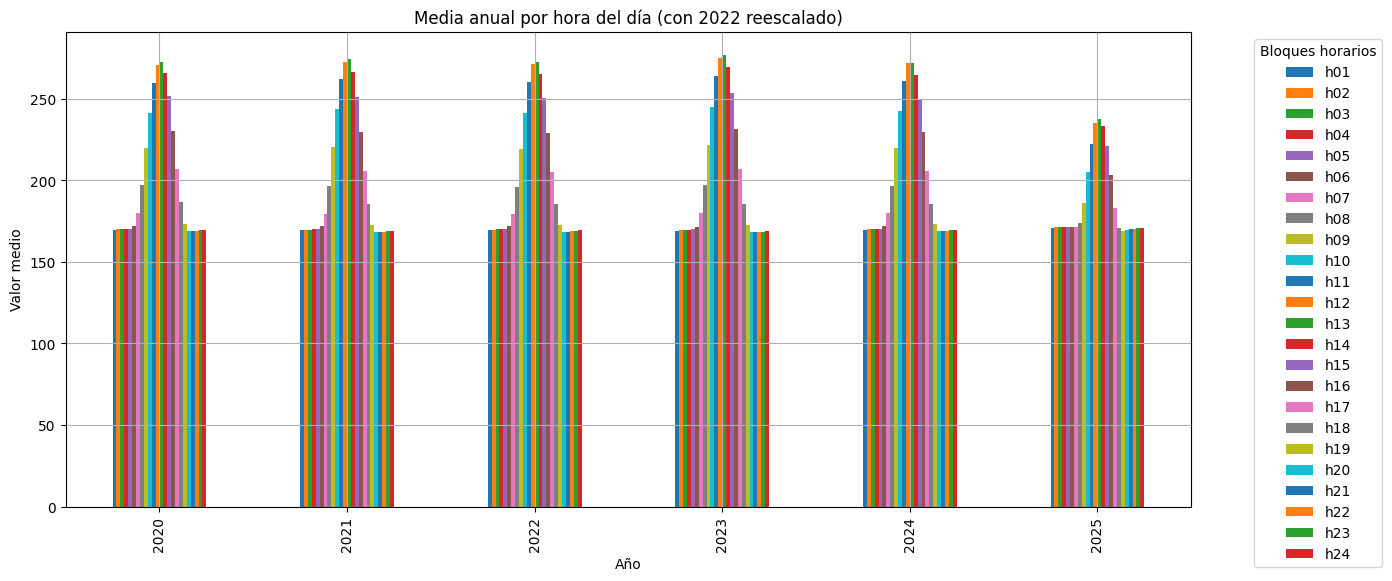

In [83]:
media_por_anio.plot(kind='bar', figsize=(14, 6))
plt.title("Media anual por hora del día (con 2022 reescalado)")
plt.ylabel("Valor medio")
plt.xlabel("Año")
plt.legend(title="Bloques horarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
df_meteo.drop(columns=['ano'], inplace=True)

In [85]:
df_meteo.to_csv("meteo_cleaned.csv", index=False)

VELOCIDAD DEL VIENTO (m/s: metros por segundo)

In [86]:
df_meteo[df_meteo['medida'] == 'Velocidad del viento (m/s)'].describe().T

count                           mean                  min  \
h01    39679.0                       1.562799                  0.0   
h02    39647.0                       1.527369                  0.0   
h03    39617.0                       1.497503                  0.0   
h04    39582.0                       1.467526                  0.0   
h05    39560.0                       1.439814                  0.0   
h06    39502.0                        1.43633                  0.0   
h07    39487.0                       1.472263                  0.0   
h08    39552.0                       1.572864                  0.0   
h09    39619.0                       1.697548                  0.0   
h10    39686.0                       1.847886                  0.0   
h11    39680.0                       2.005729                  0.0   
h12    39740.0                       2.163768                  0.0   
h13    39768.0                        2.29425                  0.1   
h14    39848.0                       2.375971                  0.0   
h15    39922.0                       2.402736                  0.0   
h16    39887.0                       2.366027                  0.0   
h17    39904.0                       2.241198                  0.0   
h18    39889.0                       2.048895                  0.0   
h19    39757.0                       1.852976                  0.0   
h20    39756.0                       1.688143                  0.0   
h21    39700.0                       1.618973                  0.0   
h22    39670.0                       1.600543                  0.0   
h23    39639.0                       1.596694                  0.0   
h24    39613.0                       1.583672                  0.0   
fecha    47974  2022-09-02 22:51:08.562137856  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    0.4                  1.0                  1.8   
h02                    0.4                  1.0                  1.8   
h03                    0.4                  0.9                  1.7   
h04                    0.4                  0.9                  1.7   
h05                    0.4                  0.9                  1.7   
h06                    0.4                  0.9                  1.6   
h07                    0.4                  0.9                  1.7   
h08                    0.5                  1.0                  1.8   
h09               0.688197                  1.2                  1.9   
h10                    0.8                  1.3                  2.1   
h11                    0.9                  1.5                  2.3   
h12                    1.1                  1.6                  2.5   
h13                    1.2                  1.8                  2.7   
h14                    1.2                  1.9                  2.8   
h15                    1.2                  1.9                  2.8   
h16                    1.2                  1.9                  2.8   
h17                    1.0                  1.7                  2.7   
h18                    0.8                  1.5                  2.5   
h19               0.699445                  1.3                  2.3   
h20                    0.5                  1.2                  2.1   
h21                    0.5                  1.1                  1.9   
h22                    0.4                  1.0                  1.9   
h23                    0.4                  1.0                  1.9   
h24                    0.4                  1.0                  1.9   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max        std  
h01                  946.5  14.272417  
h02                  945.8  14.226515  
h03                  945.8  14.228595  
h04                  946.0  14.234935  
h05                  946.0  14.242075  
h06                  946.0  14.253373  
h07                  946.0  14.2612

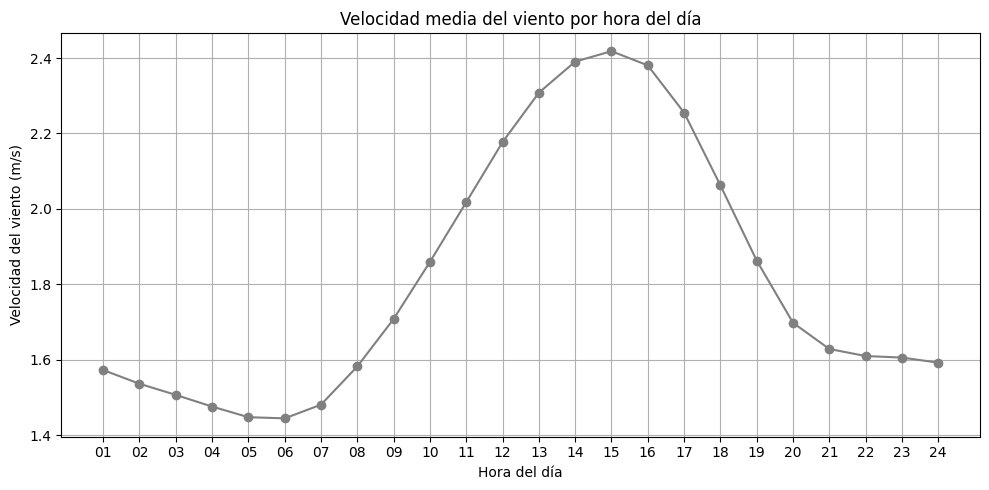

In [87]:
revision_medida.T['Velocidad del viento (m/s)'].plot(figsize=(10, 5), marker='o', color='grey')

plt.title('Velocidad media del viento por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Velocidad del viento (m/s)')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()

La velocidad del viento es mucho mayor entre el mediodía y las 17 horas, siendo su punto medio máximo a las 15 horas. Los mínimos se registran de madrugada, especialemnte entre las 5 y 6 horas

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\2105571862.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=concentracion_viento, x='municipio', y='velocidad_media', palette='GnBu_r')


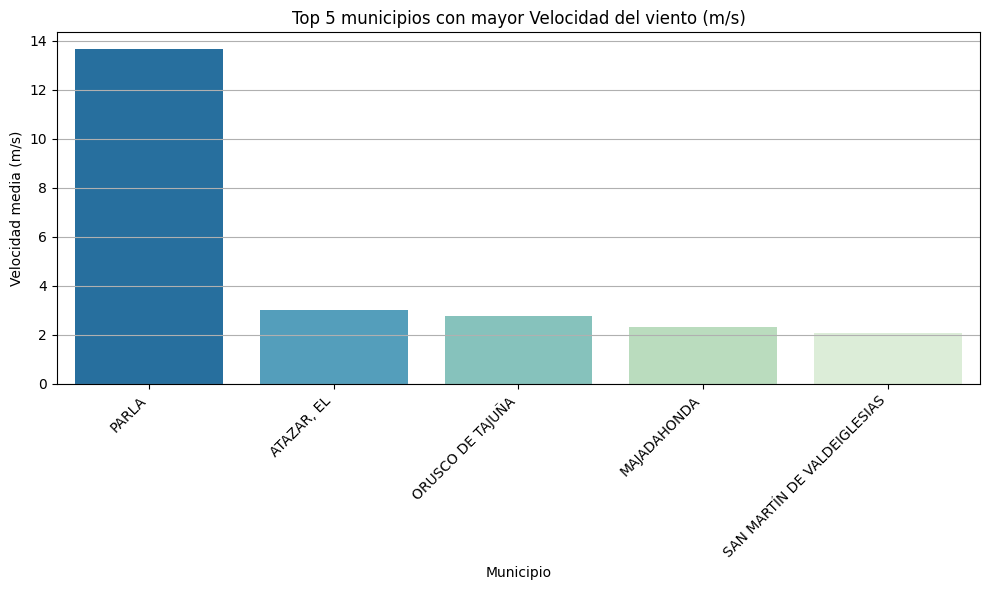

In [88]:
viento = df_meteo[df_meteo['medida'] == 'Velocidad del viento (m/s)'][['municipio'] + horas]
media_viento = viento.groupby('municipio').mean()
concentracion_viento = media_viento.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
concentracion_viento.columns = ['municipio', 'velocidad_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=concentracion_viento, x='municipio', y='velocidad_media', palette='GnBu_r')
plt.title('Top 5 municipios con mayor Velocidad del viento (m/s)')
plt.xlabel('Municipio')
plt.ylabel('Velocidad media (m/s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

Vemos que hay algo en los datos de Parla raro, asi que vamos a comprobar:

In [89]:
df_meteo[
    (df_meteo['municipio'] == 'PARLA') & 
    (df_meteo['medida'] == 'Velocidad del viento (m/s)') & 
    (df_meteo['h01'] > 50)
]

municipio                      medida    h01    h02    h03    h04  \
199969     PARLA  Velocidad del viento (m/s)  937.0  936.0  936.0  936.0   
200157     PARLA  Velocidad del viento (m/s)  942.0  942.0  942.0  942.0   
200345     PARLA  Velocidad del viento (m/s)  941.0  940.8  941.0  941.0   
200533     PARLA  Velocidad del viento (m/s)  941.0  941.0  941.0  941.0   
200721     PARLA  Velocidad del viento (m/s)  939.5  939.5  939.0  939.5   
200909     PARLA  Velocidad del viento (m/s)  941.5  942.0  942.0  942.0   
201097     PARLA  Velocidad del viento (m/s)  945.0  945.0  944.3  944.5   
201285     PARLA  Velocidad del viento (m/s)  946.5  945.8  945.8  946.0   
201473     PARLA  Velocidad del viento (m/s)  941.0  940.3  939.8  939.0   
201661     PARLA  Velocidad del viento (m/s)  237.0    2.1    1.4    1.9   

          h05    h06    h07    h08  ...    h16    h17    h18    h19    h20  \
199969  936.5  937.0  937.5  938.0  ...  937.0  937.0  937.8  938.5  939.5   
200157  942.0  942.0  942.5  943.0  ...  939.5  939.0  939.0  939.0  939.8   
200345  941.0  941.0  941.8  942.0  ...  939.8  939.0  939.0  939.0  940.0   
200533  941.0  941.0  941.3  942.0  ...  938.0  938.0  938.0  938.0  938.5   
200721  940.0  940.0  941.0  941.0  ...  939.0  939.0  939.0  940.0  940.3   
200909  942.8  943.0  943.8  944.0  ...  943.0  942.5  942.3  943.0  943.8   
201097  945.0  945.0  945.3  946.0  ...  945.0  944.5  945.0  945.0  945.3   
201285  946.0  946.0  946.0  946.0  ...  942.0  941.3  941.0  941.0  941.0   
201473  939.0  939.0  939.0  939.3  ...  938.0  937.5  937.8  938.0  939.0   
201661    2.6    2.1    1.7    1.9  ...    4.4    3.4    3.3    3.2    2.7   

          h21    h22    h23    h24      fecha  
199969  940.5  941.0  942.0  942.0 2023-04-04  
200157  940.0  940.3  941.0  941.0 2023-04-05  
200345  940.0  941.0  941.0  941.0 2023-04-06  
200533  939.0  939.0  939.0  939.0 2023-04-07  
200721  941.0  941.0  941.0  941.0 2023-04-08  
200909  944.3  945.0  945.0  945.0 2023-04-09  
201097  946.0  946.3  946.8  947.0 2023-04-10  
201285  941.0  941.0  941.0  941.0 2023-04-11  
201473  939.0  940.0  940.0  940.0 2023-04-12  
201661    2.4    1.6    0.9    1.6 2023-04-13  

[10 rows x 27 columns]

In [90]:
df_meteo.loc[df_meteo.index == 201661, 'h01'] = 2.3

Se imputa el valor que sí conocemos, que es solo una hora, y que está alterado por el uso de la coma. El resto de registros son erróneos para todas las horas del día, asi que se procede a prescindir de ellos al ser solo 9 días.

In [91]:
indices_a_eliminar = [199969, 200157, 200345, 200533, 200721, 200909, 201097, 201285, 201473]

df_meteo = df_meteo.drop(index=indices_a_eliminar)

La velocidad del viento es mucho mayor entre el mediodía y las 17 horas, siendo su punto medio máximo a las 15 horas. Los mínimos se registran de madrugada, especialemnte entre las 5 y 6 horas. Todos los municipios con mayores vientos, menos Majadahonda, se encuentran en extremos de la Comunidad de Madrid, varios lindando con otras comunidades autónomas. El Atazar en el norte y el resto en la zona sur

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\2105571862.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=concentracion_viento, x='municipio', y='velocidad_media', palette='GnBu_r')


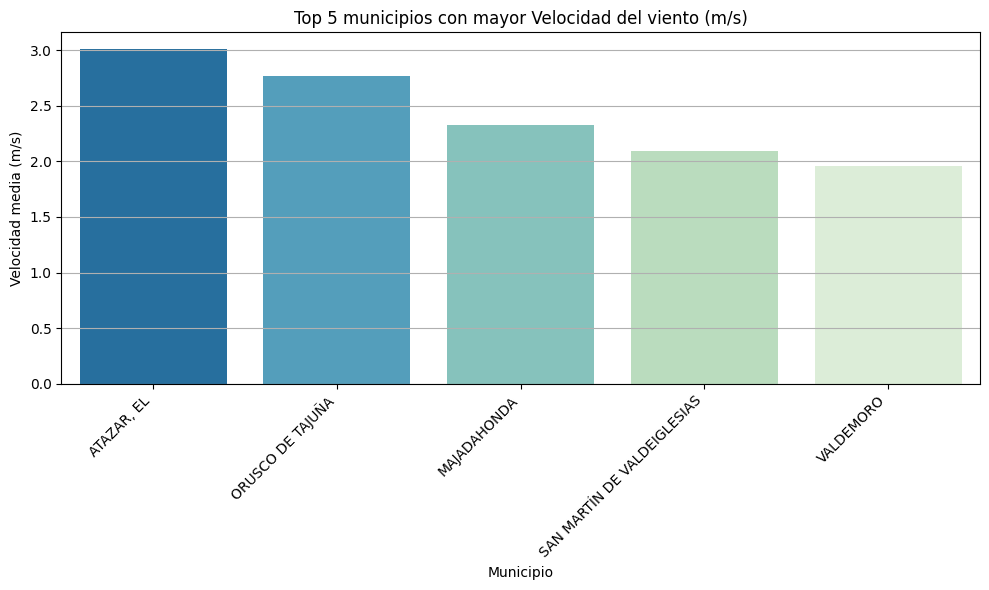

In [92]:
viento = df_meteo[df_meteo['medida'] == 'Velocidad del viento (m/s)'][['municipio'] + horas]
media_viento = viento.groupby('municipio').mean()
concentracion_viento = media_viento.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
concentracion_viento.columns = ['municipio', 'velocidad_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=concentracion_viento, x='municipio', y='velocidad_media', palette='GnBu_r')
plt.title('Top 5 municipios con mayor Velocidad del viento (m/s)')
plt.xlabel('Municipio')
plt.ylabel('Velocidad media (m/s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

TEMPERATURA (ºC)

In [93]:
df_meteo[df_meteo['medida'] == 'Temperatura (ºC)'].describe().T

count                           mean                  min  \
h01    39832.0                      12.191363                -40.0   
h02    39827.0                      11.636079                -40.0   
h03    39806.0                      11.128105                -40.0   
h04    39812.0                      10.668743                -40.0   
h05    39766.0                      10.261093                -40.0   
h06    39662.0                      10.057642                -40.0   
h07    39707.0                      10.463495                -40.0   
h08    39697.0                      11.552375                -40.0   
h09    39684.0                      13.136037                -40.0   
h10    39632.0                       14.81835                -40.0   
h11    39702.0                      16.307889                -40.0   
h12    39745.0                      17.591638                -40.0   
h13    39779.0                      18.574074                -40.0   
h14    39823.0                      19.264544                -40.0   
h15    39914.0                      19.646979                -40.0   
h16    39908.0                      19.724494                -40.0   
h17    39909.0                       19.32069                -40.0   
h18    39873.0                      18.384322                -40.0   
h19    39868.0                       17.20474                -40.0   
h20    39898.0                       15.96516                -40.0   
h21    39861.0                      14.943148                -40.0   
h22    39889.0                      14.135553                -40.0   
h23    39869.0                      13.424183                -40.0   
h24    39890.0                      12.780501                -40.0   
fecha    47974  2022-09-02 22:51:08.562137856  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    6.6                 11.2                 17.6   
h02               6.294547                 10.8                16.95   
h03                    5.9                 10.3                 16.3   
h04               5.584643                 10.0                 15.7   
h05                    5.3                  9.7                 15.2   
h06                    5.1                  9.5                 15.1   
h07                    5.0                  9.8                 16.0   
h08               5.504529                 10.8                 17.6   
h09                    6.8                 12.3                 19.5   
h10                    8.2                 13.8                 21.3   
h11                    9.6                 15.2                 22.9   
h12                   10.7                 16.4                 24.3   
h13                   11.7                 17.3                 25.3   
h14                   12.3                 17.9                 26.1   
h15                   12.6                 18.3                 26.6   
h16                   12.6                 18.3                 26.8   
h17                   12.0                 17.9                 26.7   
h18                   10.8                 16.8                 25.9   
h19                    9.8                 15.5                 24.4   
h20                    9.1                 14.4                 22.7   
h21                    8.5                 13.6                 21.2   
h22                    8.0                 12.8                 20.1   
h23                    7.5                 12.2                 19.2   
h24                    7.0                 11.7                 18.3   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max       std  
h01                   45.0  7.529121  
h02                   57.4  7.349576  
h03                   57.1  7.177644  
h04                   60.0   7.02117  
h05                   58.2  6.895782  
h06                   58.7  6.875961  
h07                   80.8  7.320385  
h08

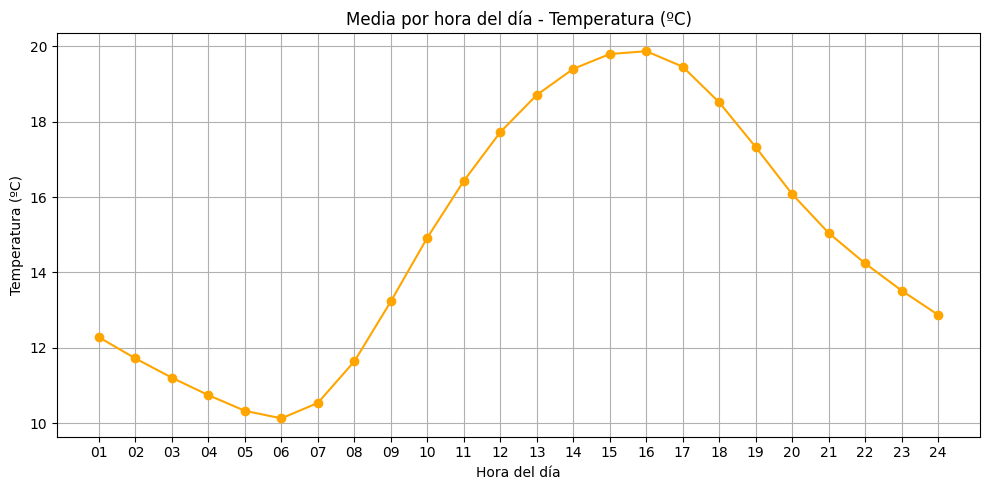

In [94]:
revision_medida.T['Temperatura (ºC)'].plot(figsize=(10, 5), marker='o', color='orange')
plt.title('Media por hora del día - Temperatura (ºC)')
plt.xlabel('Hora del día')
plt.ylabel('Temperatura (ºC)')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()


La temperatura media baja durante la madrugada, marcando el mínimo a las 6 horas y empezando a ascender constantemente desde esa hora hasta las 16 horas, donde alcanza la máxima temporatura media horaria. A partir de ahí vuelve a descender la temperatura durante la tarde y noche.

Parla vuelve a ser el municipio con mayores temperatura medias, pero en este caso bastante parecido a los siguientes municipios. Son municipios del sur de Madrid. al contrario, los municipios con temperaturas medias más suaves son de la zona norte, zonas más naturales, de sierra y alejadas del centro

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\2296156261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_temperatura, x='municipio', y='temperatura_media', palette='Oranges_r')


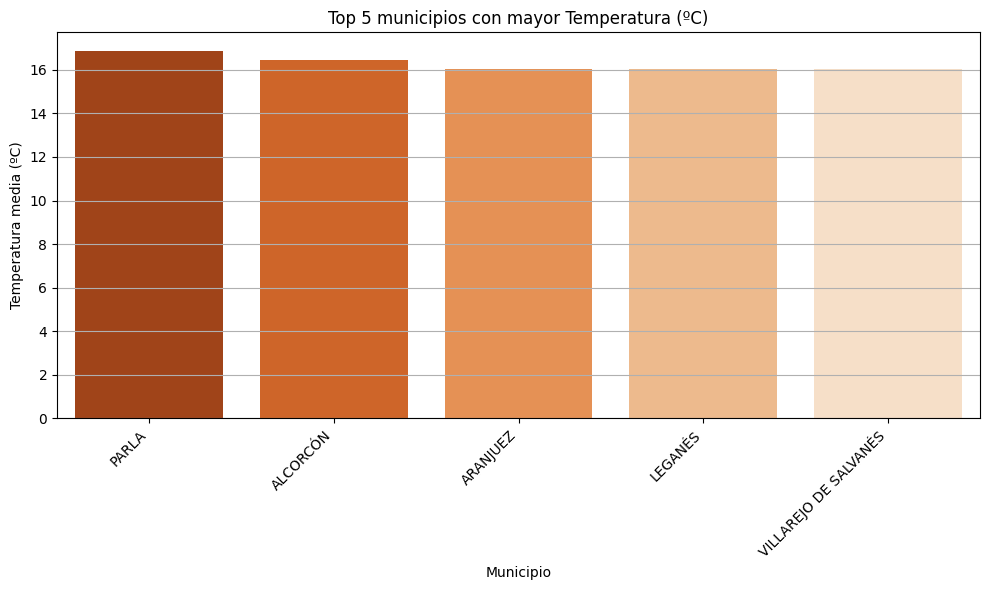

In [95]:
temperatura = df_meteo[df_meteo['medida'] == 'Temperatura (ºC)'][['municipio'] + horas]
media_temperatura = temperatura.groupby('municipio').mean()
top_temperatura = media_temperatura.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
top_temperatura.columns = ['municipio', 'temperatura_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_temperatura, x='municipio', y='temperatura_media', palette='Oranges_r')
plt.title('Top 5 municipios con mayor Temperatura (ºC)')
plt.xlabel('Municipio')
plt.ylabel('Temperatura media (ºC)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\4233225045.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_temperatura, x='municipio', y='temperatura_media', palette='Oranges_r')


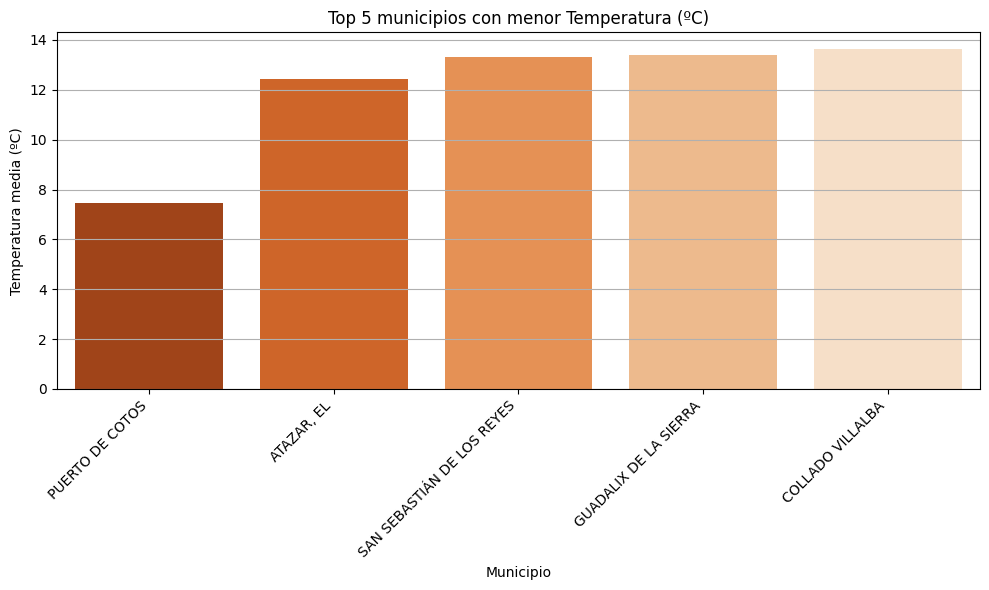

In [96]:
low_temperatura = media_temperatura.mean(axis=1).sort_values(ascending=True).head(5).reset_index()
low_temperatura.columns = ['municipio', 'temperatura_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=low_temperatura, x='municipio', y='temperatura_media', palette='Oranges_r')
plt.title('Top 5 municipios con menor Temperatura (ºC)')
plt.xlabel('Municipio')
plt.ylabel('Temperatura media (ºC)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

HUMEDAD RELATIVA (%)

In [97]:
df_meteo[df_meteo['medida'] == 'Humedad relativa (%)'].describe().T

count                           mean                  min  \
h01    47727.0                      62.735625                  0.0   
h02    47722.0                      64.475849                  0.0   
h03    47698.0                      66.050333                  0.0   
h04    47682.0                      67.560185                  0.0   
h05    47665.0                      68.859741                  0.0   
h06    47571.0                      69.700821                  0.0   
h07    47542.0                      68.709977                  0.0   
h08    47529.0                      65.569326                  0.0   
h09    47542.0                      60.771548                  0.0   
h10    47529.0                      55.475628                  0.0   
h11    47550.0                       50.93235                  0.0   
h12    47590.0                      47.046981                  0.0   
h13    47654.0                      44.048402                  0.0   
h14    47716.0                      42.059178                  0.0   
h15    47756.0                      41.058226                  0.0   
h16    47776.0                      41.005849                  0.0   
h17    47798.0                      42.319579                  0.0   
h18    47808.0                      45.295562                  0.0   
h19    47796.0                      48.724418                  0.0   
h20    47783.0                      51.943872                  0.0   
h21    47772.0                      54.659857                  0.0   
h22    47762.0                      56.902948                  0.0   
h23    47751.0                      58.922872                  0.0   
h24    47739.0                       60.84343                  0.0   
fecha    47974  2022-09-02 22:51:08.562137856  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                   44.0                 63.0                 83.0   
h02              46.160012                 65.0                 84.0   
h03              48.879842            66.336928                 86.0   
h04              50.969902                 68.0                 87.0   
h05              52.281975            69.012207                 88.0   
h06                   54.0                 70.0                 89.0   
h07                   52.0                 69.0                 88.0   
h08              47.476561                 65.0                 86.0   
h09                   42.0                 59.0                 80.0   
h10                   37.0                 53.0                 72.0   
h11                   33.0                 48.0            66.783645   
h12              29.261554            43.195627                 62.0   
h13              26.430858                 40.0                 58.0   
h14                   25.0                 38.0                 56.0   
h15                   23.0                 37.0                 55.0   
h16                   23.0                 37.0            55.824201   
h17                   23.0                 38.0                 59.0   
h18                   24.0            41.141763                 64.0   
h19                   27.0                 46.0                 68.0   
h20                   30.0                 50.0                 72.0   
h21                   33.0            53.239057                 75.0   
h22                   36.0                 56.0                 77.0   
h23                   39.0            58.797625                 79.0   
h24              41.283815            60.876133                 81.0   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max        std  
h01                  100.0  23.307365  
h02                  100.0  22.770747  
h03                  100.0  22.258067  
h04                  100.0  21.761132  
h05                  100.0  21.333287  
h06                  100.0  21.023596  
h07                  164.0  21.4473

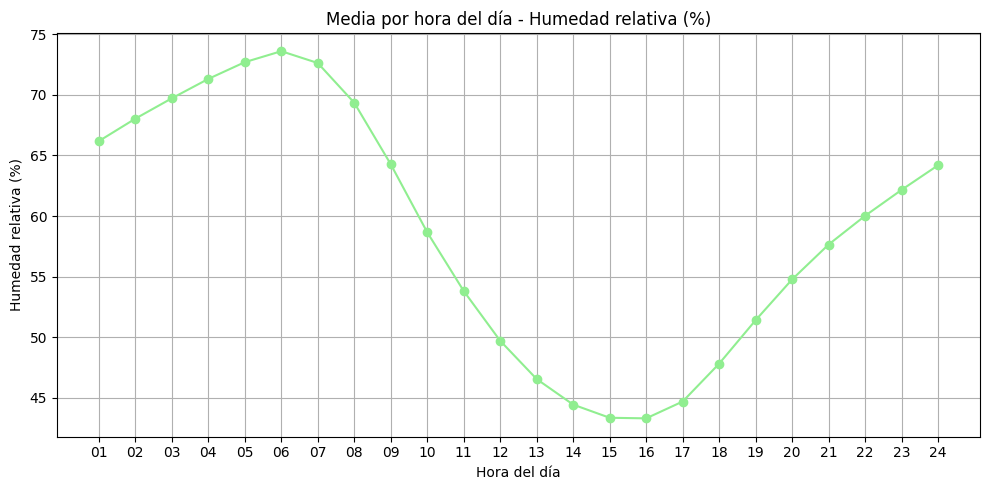

In [98]:
revision_medida.T['Humedad relativa (%)'].plot(figsize=(10, 5), marker='o', color='lightgreen')
plt.title('Media por hora del día - Humedad relativa (%)')
plt.xlabel('Hora del día')
plt.ylabel('Humedad relativa (%)')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()


La humedad relativa cambia de amnera más gradual y lo hace a la inversa que la temperatura, es decir, cuando la temperatura aumenta, la humedad relativa disminuye y viceversa. Las madrugadas son más húmedad de media y cuando emnos humedad hay es entre las 15 y 16, cuando las temperaturas son más altas.

Los municipios con mayor humedad son los del norte, por esta relación inversa que comento. Son sitios de sierra, a excepció de Pozuelo que es una zona cercana al centro de Madrid y Valdemoro que pertenece a la zona sur. Los municipios con menor humedad son municipios del sur pero cercanos a la ciudad de Madrid, muy poblados, urbanos e industriales, a excepción de Alcobendad, en el norte de Madrid.

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\2424260504.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_humedad, x='municipio', y='humedad_media', palette='Greens')


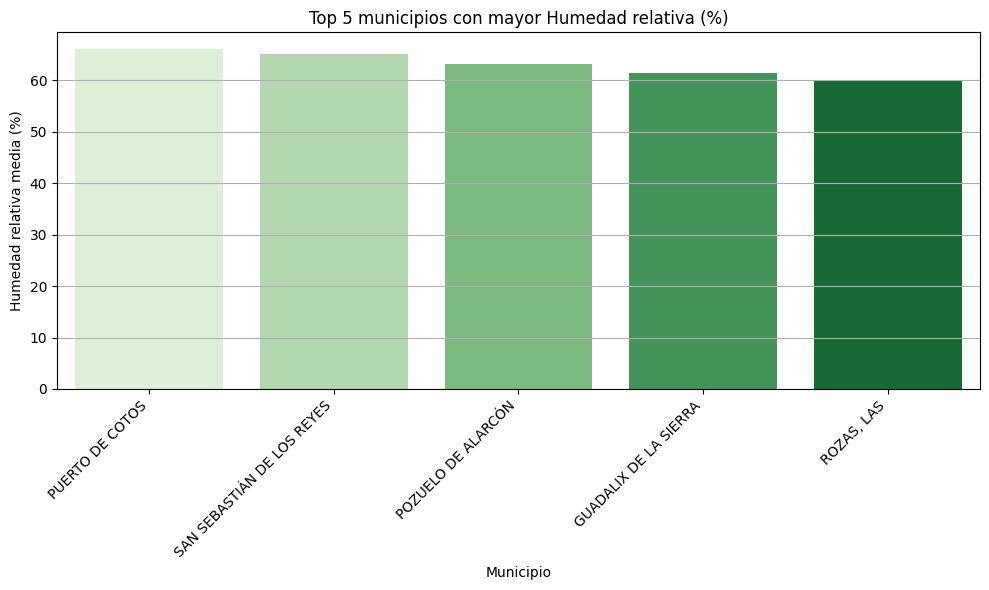

In [99]:
humedad = df_meteo[df_meteo['medida'] == 'Humedad relativa (%)'][['municipio'] + horas]
media_humedad = humedad.groupby('municipio').mean()
top_humedad = media_humedad.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
top_humedad.columns = ['municipio', 'humedad_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_humedad, x='municipio', y='humedad_media', palette='Greens')
plt.title('Top 5 municipios con mayor Humedad relativa (%)')
plt.xlabel('Municipio')
plt.ylabel('Humedad relativa media (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\metal\AppData\Local\Temp\ipykernel_11816\4099842429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_humedad, x='municipio', y='humedad_media', palette='Greens')


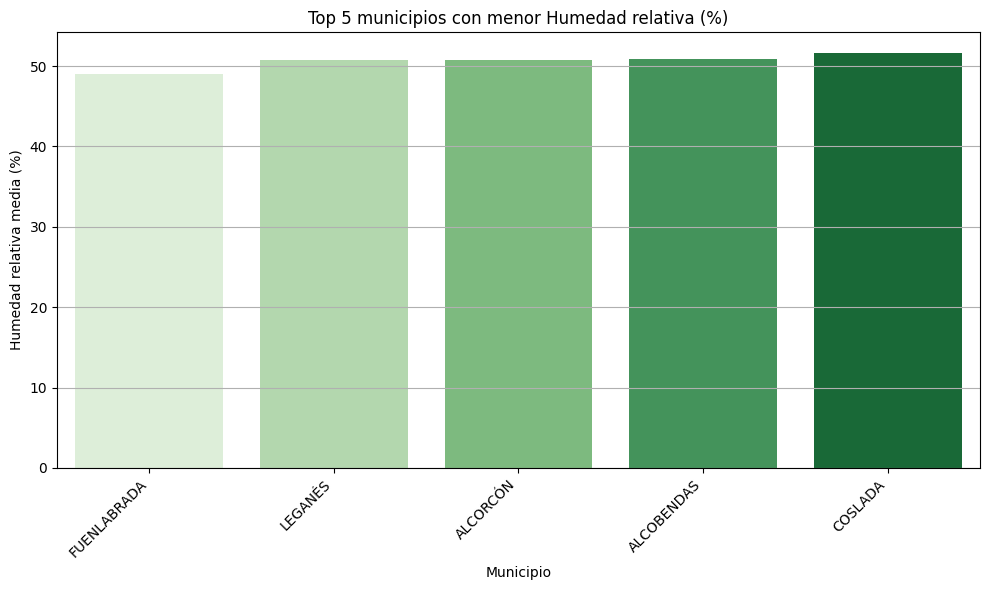

In [100]:
low_humedad = media_humedad.mean(axis=1).sort_values(ascending=True).head(5).reset_index()
low_humedad.columns = ['municipio', 'humedad_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=low_humedad, x='municipio', y='humedad_media', palette='Greens')
plt.title('Top 5 municipios con menor Humedad relativa (%)')
plt.xlabel('Municipio')
plt.ylabel('Humedad relativa media (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

PRECIPITACIÓN (l/m2: litros por metro cuadrado)

In [101]:
df_meteo[df_meteo['medida'] == 'Precipitación'].describe().T

count                           mean                  min  \
h01    47406.0                       0.037133                  0.0   
h02    47401.0                        0.03329                  0.0   
h03    47346.0                       0.031849                  0.0   
h04    47356.0                       0.042574                  0.0   
h05    47338.0                       0.041678                  0.0   
h06    47257.0                       0.034275                  0.0   
h07    47106.0                       0.033411                  0.0   
h08    47094.0                       0.048447                  0.0   
h09    47062.0                       0.034722                  0.0   
h10    47068.0                       0.036995                  0.0   
h11    47191.0                       0.034452                  0.0   
h12    47220.0                       0.027383                  0.0   
h13    47302.0                       0.036829                  0.0   
h14    47345.0                       0.044593                  0.0   
h15    47317.0                        0.04476                  0.0   
h16    47306.0                       0.051378                  0.0   
h17    47308.0                       0.048751                  0.0   
h18    47327.0                       0.040139                  0.0   
h19    47364.0                       0.039749                  0.0   
h20    47387.0                       0.044482                  0.0   
h21    47381.0                       0.051534                  0.0   
h22    47384.0                       0.047607                  0.0   
h23    47408.0                       0.046399                  0.0   
h24    47392.0                       0.040583                  0.0   
fecha    47974  2022-09-02 22:51:08.562137856  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    0.0                  0.0                  0.0   
h02                    0.0                  0.0                  0.0   
h03                    0.0                  0.0                  0.0   
h04                    0.0                  0.0                  0.0   
h05                    0.0                  0.0                  0.0   
h06                    0.0                  0.0                  0.0   
h07                    0.0                  0.0                  0.0   
h08                    0.0                  0.0                  0.0   
h09                    0.0                  0.0                  0.0   
h10                    0.0                  0.0                  0.0   
h11                    0.0                  0.0                  0.0   
h12                    0.0                  0.0                  0.0   
h13                    0.0                  0.0                  0.0   
h14                    0.0                  0.0                  0.0   
h15                    0.0                  0.0                  0.0   
h16                    0.0                  0.0                  0.0   
h17                    0.0                  0.0                  0.0   
h18                    0.0                  0.0                  0.0   
h19                    0.0                  0.0                  0.0   
h20                    0.0                  0.0                  0.0   
h21                    0.0                  0.0                  0.0   
h22                    0.0                  0.0                  0.0   
h23                    0.0                  0.0                  0.0   
h24                    0.0                  0.0                  0.0   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max       std  
h01                   29.1  0.373075  
h02                   24.6  0.335216  
h03                   17.0  0.318292  
h04                   22.4  0.452878  
h05                   55.0  0.483495  
h06                   18.8  0.318147  
h07                   16.0  0.299089  
h08

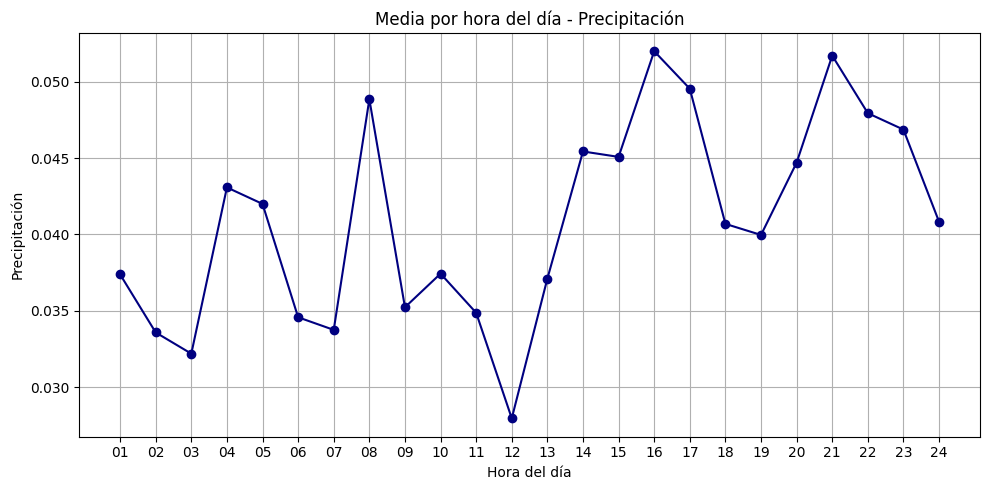

In [102]:
revision_medida.T['Precipitación'].plot(figsize=(10, 5), marker='o', color='navy')
plt.title('Media por hora del día - Precipitación')
plt.xlabel('Hora del día')
plt.ylabel('Precipitación')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()

Las precipitaciones son muy irregulares al analizarlas horariamente, sin patrones muy definidos y una tendencia a llover muy poco o que no llueva. Tenemos picos de mucha lluvia a las 8h, las 16-17h y 21-23 horas. El mínimo sí tiene un pico claro de menor precipitación a las 12 horas del mediodía.

El puerto de Cotos es con diferencia el lugar con más precipitaciones. Los lugares que menso precipitaciones tienen coinciden con las de mayores temperaturas y menor humedad relativa, como Alcorcón, Leganés o Algete

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\1123714978.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_precipitacion, x='municipio', y='precipitacion_media', palette='Blues_r')


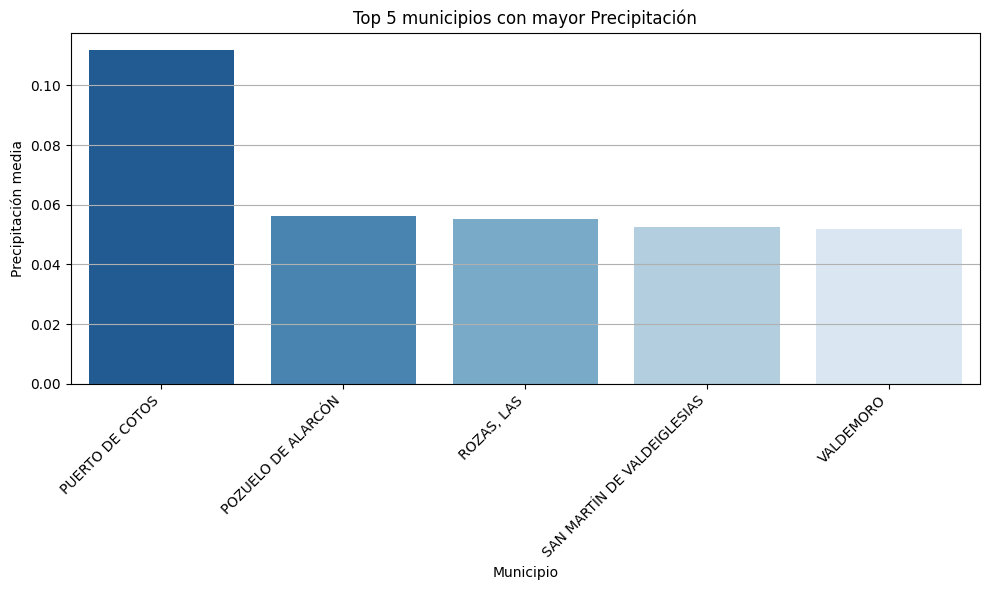

In [103]:
precipitacion = df_meteo[df_meteo['medida'] == 'Precipitación'][['municipio'] + horas]
media_precipitacion = precipitacion.groupby('municipio').mean()
top_precipitacion = media_precipitacion.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
top_precipitacion.columns = ['municipio', 'precipitacion_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_precipitacion, x='municipio', y='precipitacion_media', palette='Blues_r')
plt.title('Top 5 municipios con mayor Precipitación')
plt.xlabel('Municipio')
plt.ylabel('Precipitación media')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\metal\AppData\Local\Temp\ipykernel_11816\828837133.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_precipitacion, x='municipio', y='precipitacion_media', palette='Blues_r')


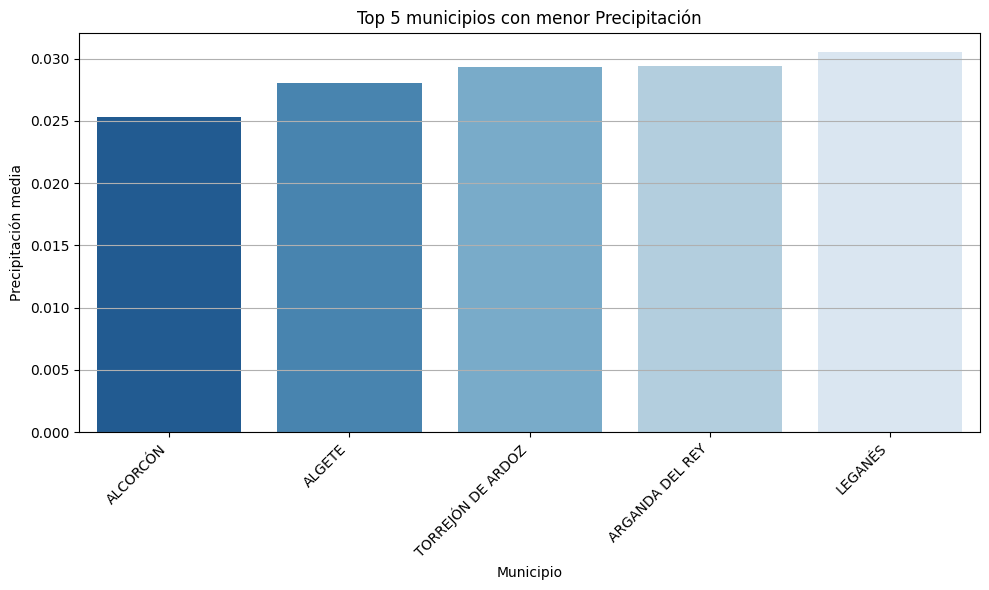

In [104]:
low_precipitacion = media_precipitacion.mean(axis=1).sort_values(ascending=True).head(5).reset_index()
low_precipitacion.columns = ['municipio', 'precipitacion_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=low_precipitacion, x='municipio', y='precipitacion_media', palette='Blues_r')
plt.title('Top 5 municipios con menor Precipitación')
plt.xlabel('Municipio')
plt.ylabel('Precipitación media')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

PRESIÓN ATMOSFÉRICA (mbar)

In [105]:
df_meteo[df_meteo['medida'] == 'Presión atmosférica (mbar)'].describe().T

count                           mean                  min  \
h01    47704.0                     883.506486            549.81256   
h02    47699.0                     883.192876           548.324991   
h03    47675.0                     882.894303           547.454226   
h04    47662.0                     882.775717            547.29504   
h05    47643.0                     882.638551           546.520915   
h06    47552.0                     882.625269           545.353117   
h07    47530.0                     881.964137                262.0   
h08    47535.0                     881.739175                479.0   
h09    47538.0                     882.066722           540.922514   
h10    47525.0                     882.604593           543.961503   
h11    47547.0                     883.473963           549.573746   
h12    47582.0                      883.37293            549.69919   
h13    47641.0                     882.644011           548.092539   
h14    47708.0                     882.176119           549.690237   
h15    47738.0                     882.243603           553.236447   
h16    47755.0                     881.852897           552.659593   
h17    47774.0                     881.596935           551.883945   
h18    47784.0                     881.775635           552.275867   
h19    47774.0                     882.391731           553.260997   
h20    47761.0                     883.148721            553.90933   
h21    47745.0                     883.228297           552.705469   
h22    47735.0                     883.467143            552.65865   
h23    47728.0                     883.485886           550.877746   
h24    47716.0                     883.464516           550.684102   
fecha    47965  2022-09-02 21:52:29.821745152  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                  909.0                937.0                948.0   
h02                  909.0                936.0                948.0   
h03                  908.0                936.0                948.0   
h04                  908.0                936.0                948.0   
h05                  908.0                936.0                948.0   
h06                  908.0                936.0                948.0   
h07                  908.0                937.0                948.0   
h08                  909.0                937.0                948.0   
h09                  909.0                937.0                949.0   
h10                  910.0                937.0                949.0   
h11                  910.0                937.0                949.0   
h12                  909.0                937.0                948.0   
h13                  909.0                937.0                948.0   
h14                  908.0                936.0                947.0   
h15                  908.0                936.0                947.0   
h16                  908.0                935.0                946.0   
h17                  908.0                935.0                946.0   
h18                  908.0                935.0                946.0   
h19                  908.0                935.0                947.0   
h20                  909.0                936.0                947.0   
h21                  909.0                936.0                948.0   
h22                  909.0                937.0                948.0   
h23                  909.0                937.0                948.0   
h24                  909.0                937.0                948.0   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max         std  
h01                 1084.0  111.797598  
h02                 1083.0  112.116979  
h03                 1098.0  112.514036  
h04                 1074.0  112.549306  
h05                 1069.0  112.892276  
h06                 1068.0    113.1652  
h07                 1066.0  

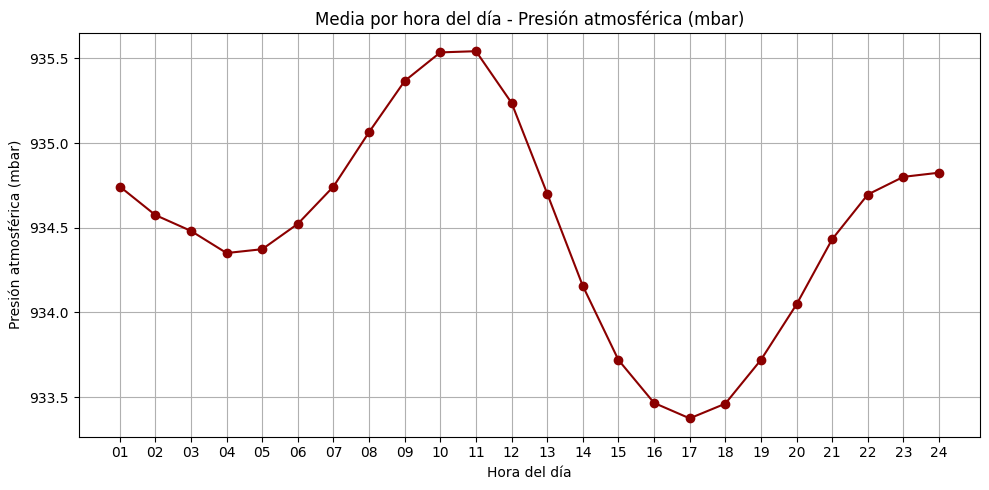

In [106]:
revision_medida.T['Presión atmosférica (mbar)'].plot(figsize=(10, 5), marker='o', color='darkred')
plt.title('Media por hora del día - Presión atmosférica (mbar)')
plt.xlabel('Hora del día')
plt.ylabel('Presión atmosférica (mbar)')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()

La presión atmosférica suele bajar de madrugada para ascender a su pico máximo por las mañanas, sobre todo a las 10-11h. Luego desciende durante el restod e la mañana y la tarde hasta alcanzar su mínimoa las 17h, desde donde vuelve otra vez a ser creciente por la tarde noche y estabilizarse de madrugada un poco. En cuanto a los municipios la distribucicón de la preseion es muy heterogenea, sin claros patrones

C:\Users\metal\AppData\Local\Temp\ipykernel_11816\3166812088.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_presion, x='municipio', y='presion_media', palette='Reds_r')


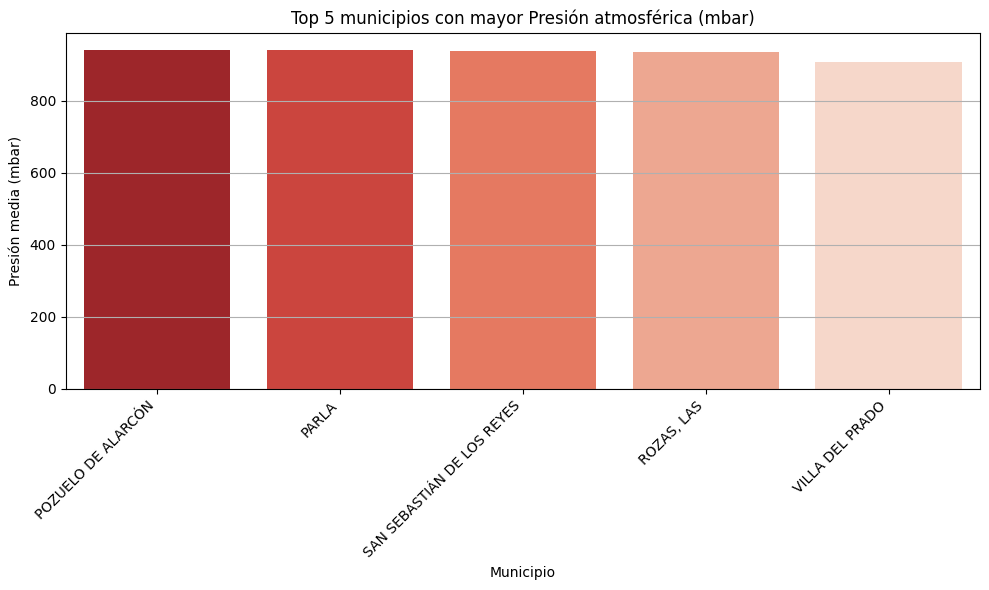

In [ ]:
presion = df_meteo[df_meteo['medida'] == 'Presión atmosférica (mbar)'][['municipio'] + horas]
media_presion = presion.groupby('municipio').mean()
top_presion = media_presion.mean(axis=1).sort_values(ascending=False).head(5).reset_index()
top_presion.columns = ['municipio', 'presion_media']

plt.figure(figsize=(10, 6))
sns.barplot(data=top_presion, x='municipio', y='presion_media', palette='Reds_r')
plt.title('Top 5 municipios con mayor Presión atmosférica (mbar)')
plt.xlabel('Municipio')
plt.ylabel('Presión media (mbar)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

RADIACIÓN SOLAR (W/m2: vatios por metro cuadrado)

In [108]:
df_meteo[df_meteo['medida'] == 'Radiación solar (W/m²)'].describe().T

count                           mean                  min  \
h01    47719.0                       2.159919                  0.0   
h02    47714.0                       2.182847                  0.0   
h03    47690.0                         2.1957                  0.0   
h04    47674.0                       2.216534                  0.0   
h05    47657.0                       2.315478                  0.0   
h06    47566.0                      10.558242                  0.0   
h07    47538.0                      54.917325                  0.0   
h08    47524.0                     150.072115                  0.0   
h09    47516.0                      283.55744                  0.0   
h10    47506.0                     415.227744                  0.0   
h11    47531.0                     522.627668                  0.0   
h12    47585.0                     587.774846                  0.0   
h13    47645.0                     598.908319                  0.0   
h14    47711.0                     559.401811                  0.0   
h15    47746.0                     476.648302                  0.0   
h16    47765.0                      356.09975                  0.0   
h17    47788.0                     220.471527                  0.0   
h18    47798.0                     104.020602                  0.0   
h19    47788.0                      30.890441                  0.0   
h20    47776.0                       4.627553                  0.0   
h21    47765.0                       2.107919                  0.0   
h22    47755.0                       2.120125                  0.0   
h23    47744.0                       2.134763                  0.0   
h24    47732.0                         2.1533                  0.0   
fecha    47974  2022-09-02 22:51:08.562137856  2020-01-01 00:00:00   

                       25%                  50%                  75%  \
h01                    0.0                  1.0                  1.0   
h02                    0.0                  1.0                  1.0   
h03                    0.0                  1.0                  1.0   
h04                    0.0                  1.0                  1.0   
h05                    0.0                  1.0             1.394186   
h06                    1.0                  2.0                 13.0   
h07                    1.0                 15.0                 93.0   
h08                   15.0             93.57699           271.786111   
h09                   90.0                248.0                464.0   
h10                  197.0                396.0                641.0   
h11                  300.0                515.0                771.0   
h12             365.072719           585.231077                846.0   
h13             378.378605                591.0                854.0   
h14             338.163867                548.0                801.0   
h15             262.647606                456.0                695.0   
h16                  156.0           323.082565                539.0   
h17                   49.0                173.0                369.0   
h18                    4.0                 48.0                186.0   
h19                    1.0              5.59556                 45.0   
h20                0.70204                  1.0                  5.0   
h21                    0.0                  1.0                  1.0   
h22                    0.0                  1.0                  1.0   
h23                    0.0                  1.0                  1.0   
h24                    0.0                  1.0                  1.0   
fecha  2021-05-14 00:00:00  2022-09-26 00:00:00  2023-12-26 00:00:00   

                       max         std  
h01            1400.796331   15.981907  
h02            1398.788242   16.342195  
h03            1396.566903   16.194746  
h04            1396.160816   16.386699  
h05            1394.186008   16.311779  
h06            1392.983696   23.150684  
h07            1383.064515  

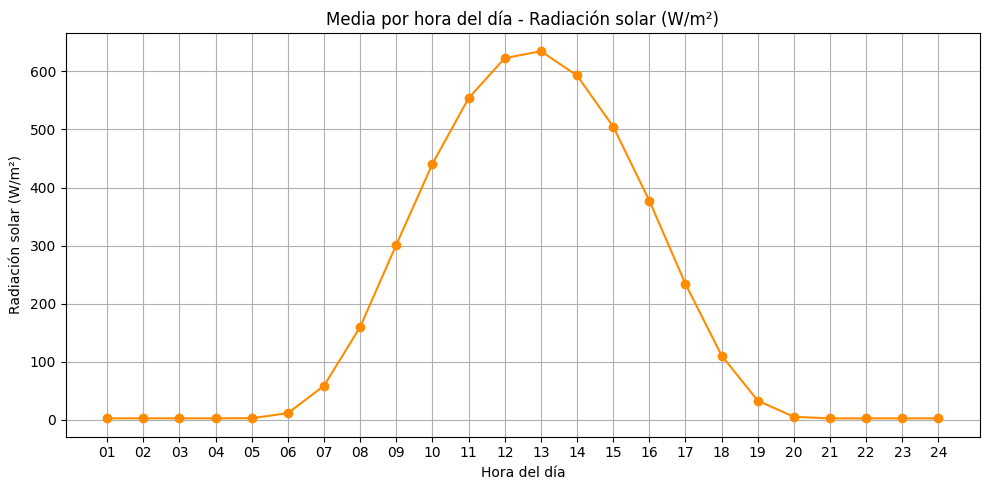

In [109]:
revision_medida.T['Radiación solar (W/m²)'].plot(figsize=(10, 5), marker='o', color='darkorange')
plt.title('Media por hora del día - Radiación solar (W/m²)')
plt.xlabel('Hora del día')
plt.ylabel('Radiación solar (W/m²)')
plt.xticks(range(0, 24), [f'{i+1:02d}' for i in range(24)])
plt.grid(True)
plt.tight_layout()
plt.show()


La radiación solar, al depender del sol, crea una distribución totalmente acorde a la incisión del mismo, siendo creciente durante toda la mañana hasta el punto máximo entre las 12 y las 14 horas, desde donde desciende para llegar a cero cuando anochece y que se mantiene hasta el amanecer.

Los municipios con ayor radiación, como orusco de Tajuña, Puerto de Cotos o Guadalix de la Sierra coinciden por ser zonas altas de la sierra, donde la incisión del sol es mayor, y alejados del centro de Madrid. Los de menor radiación no parecen tener un patrón marcado, siendo Pozuelo de Alarcón la que menos radiación tiene, coincidiendo con su mayor media de lluvias, húmedad y menor altitud que otros.

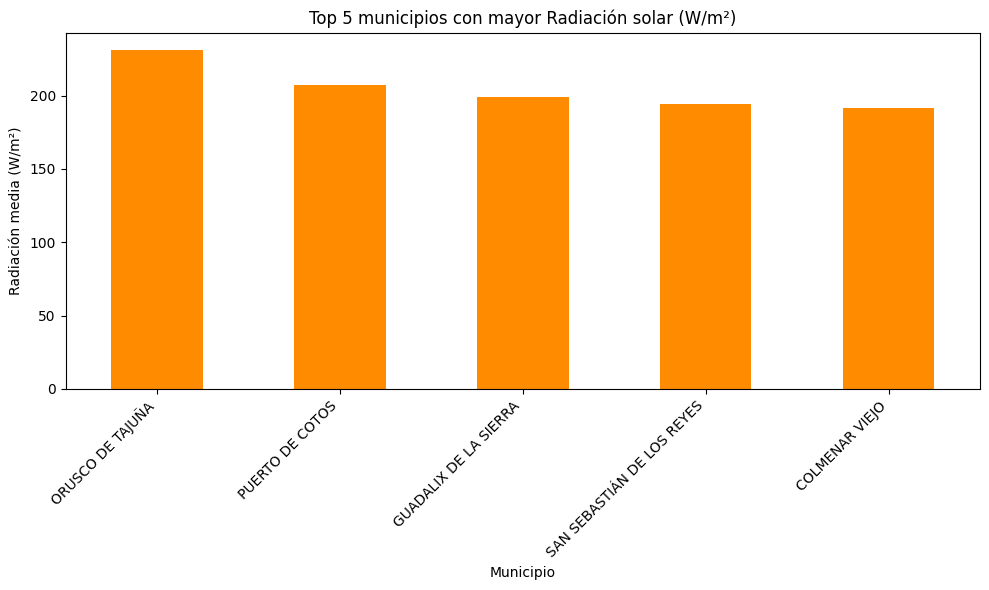

In [110]:
radiacion = df_meteo[df_meteo['medida'] == 'Radiación solar (W/m²)'][['municipio'] + horas]
media_radiacion = radiacion.groupby('municipio').mean()
concentracion_radiacion = media_radiacion.mean(axis=1)
top_radiacion = concentracion_radiacion.sort_values(ascending=False).head(5)

top_radiacion.plot(kind='bar', figsize=(10, 6), color='darkorange')
plt.title('Top 5 municipios con mayor Radiación solar (W/m²)')
plt.xlabel('Municipio')
plt.ylabel('Radiación media (W/m²)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


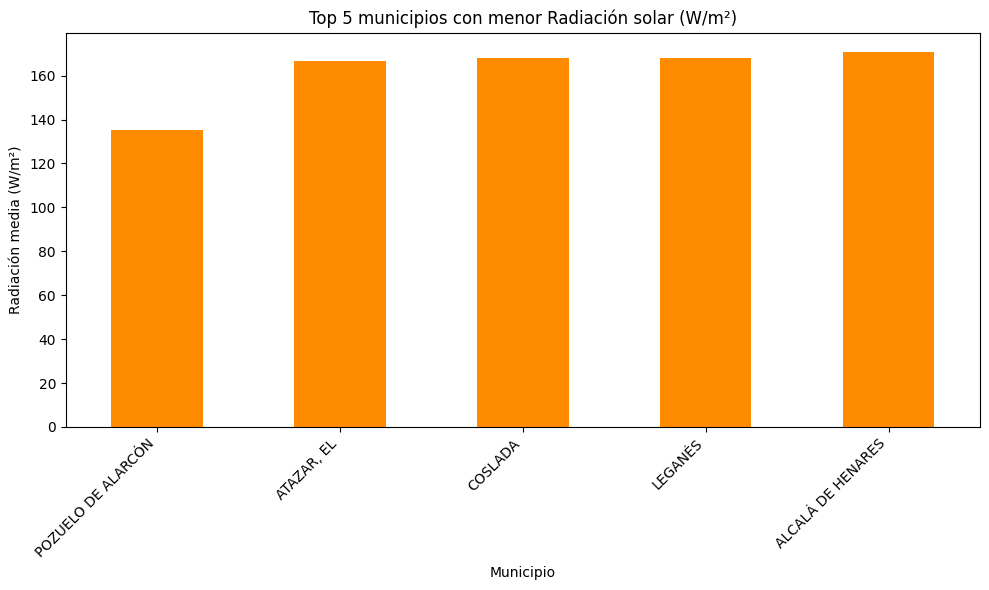

In [111]:
low_radiacion = concentracion_radiacion.sort_values(ascending=True).head(5)

low_radiacion.plot(kind='bar', figsize=(10, 6), color='darkorange')
plt.title('Top 5 municipios con menor Radiación solar (W/m²)')
plt.xlabel('Municipio')
plt.ylabel('Radiación media (W/m²)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### METEREOLOGÍA HORARIA POR MUNICIPIOS

In [112]:
df_meteo_grouped = df_meteo.groupby(['municipio', 'medida'])[horas].agg(['max', 'min', 'mean'])

df_meteo_grouped

h01              \
                                                        max         min   
municipio             medida                                              
ALCALÁ DE HENARES     Humedad relativa (%)         97.00000   10.505972   
                      Precipitación                 7.00000    0.000000   
                      Presión atmosférica (mbar)  972.00000  653.471488   
                      Radiación solar (W/m²)        0.00000    0.000000   
                      Temperatura (ºC)             30.70000   -7.600000   
...                                                     ...         ...   
VILLAREJO DE SALVANÉS Precipitación                 6.40000    0.000000   
                      Presión atmosférica (mbar)  950.00000  639.463525   
                      Radiación solar (W/m²)        1.00000    0.700398   
                      Temperatura (ºC)             32.60000   -5.800000   
                      Velocidad del viento (m/s)   15.40876    0.100000   

                                                                h02  \
                                                        mean    max   
municipio             medida                                          
ALCALÁ DE HENARES     Humedad relativa (%)         60.590459   96.0   
                      Precipitación                 0.027775    6.4   
                      Presión atmosférica (mbar)  897.292352  972.0   
                      Radiación solar (W/m²)        0.000000    0.0   
                      Temperatura (ºC)             12.650522   29.4   
...                                                      ...    ...   
VILLAREJO DE SALVANÉS Precipitación                 0.026167    9.6   
                      Presión atmosférica (mbar)  879.049828  950.0   
                      Radiación solar (W/m²)        0.942151    4.0   
                      Temperatura (ºC)             13.241359   31.0   
                      Velocidad del viento (m/s)    1.182717    9.2   

                                                                          \
                                                         min        mean   
municipio             medida                                               
ALCALÁ DE HENARES     Humedad relativa (%)         12.589094   62.444337   
                      Precipitación                 0.000000    0.026273   
                      Presión atmosférica (mbar)  652.534715  897.315849   
                      Radiación solar (W/m²)        0.000000    0.000000   
                      Temperatura (ºC)             -8.400000   12.073613   
...                                                      ...         ...   
VILLAREJO DE SALVANÉS Precipitación                 0.000000    0.031066   
                      Presión atmosférica (mbar)  638.546833  878.696226   
                      Radiación solar (W/m²)        0.699394    0.943553   
                      Temperatura (ºC)             -5.700000   12.700683   
                      Velocidad del viento (m/s)    0.100000    1.176685   

                                                    h03              \
                                                    max         min   
municipio             medida                                          
ALCALÁ DE HENARES     Humedad relativa (%)         96.0   13.267386   
                      Precipitación                 5.8    0.000000   
                      Presión atmosférica (mbar)  972.0  651.498460   
                      Radiación solar (W/m²)        0.0    0.000000   
                      Temperatura (ºC)             28.2   -8.700000   
...                                                 ...         ...   
VILLAREJO DE SALVANÉS Precipitación                 3.4    0.000000   
                      Presión atmosférica (mbar)  950.0  637.532791   
                      Radiación solar (W/m²)        1.0    0.698283   
                      Temperatura (ºC)             29.6   -6.400000   
                      

Por último graficamos los municipios y sus valores meteorológicos, para hacerlo más visual y facilitar el análisis

In [113]:
df_meteo_grouped = df_meteo.groupby(['municipio', 'medida'])[
    ['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08',
     'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
     'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']
].mean().mean(axis=1).reset_index(name='media')

medidas_interes = [
    'Temperatura (ºC)',
    'Humedad relativa (%)',
    'Precipitación',
    'Presión atmosférica (mbar)',
    'Radiación solar (W/m²)',
    'Velocidad del viento (m/s)'
]

colores = {
    'Temperatura (ºC)': 'orange',
    'Humedad relativa (%)': 'lightgreen',
    'Precipitación': 'skyblue',
    'Presión atmosférica (mbar)': 'darkred',
    'Radiación solar (W/m²)': '#FFD700', 
    'Velocidad del viento (m/s)': 'slateblue'
}

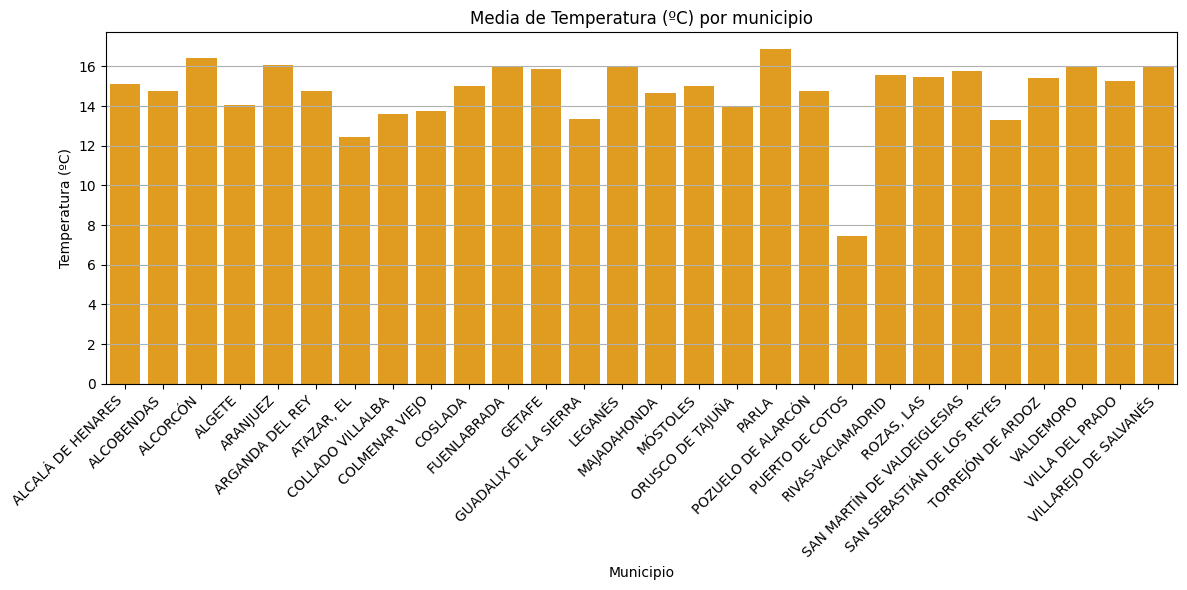

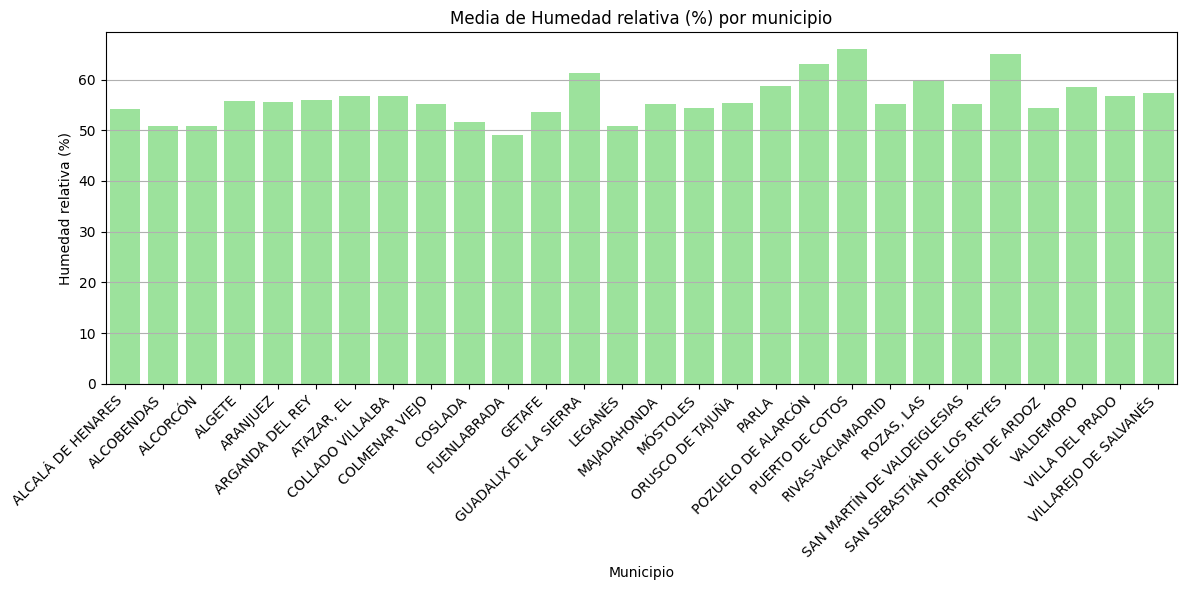

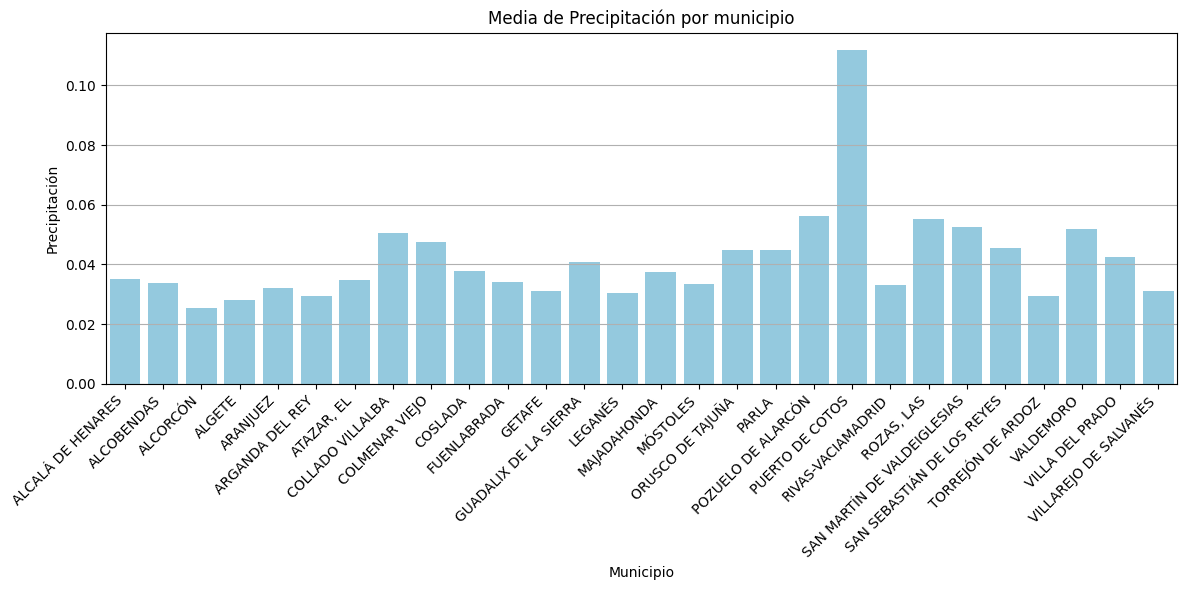

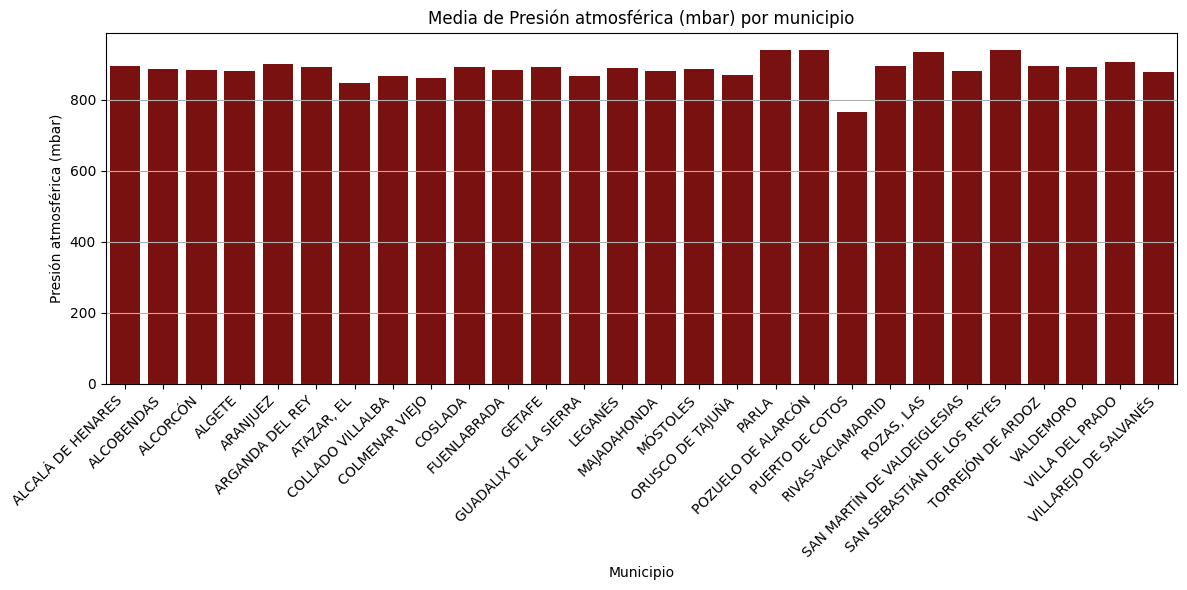

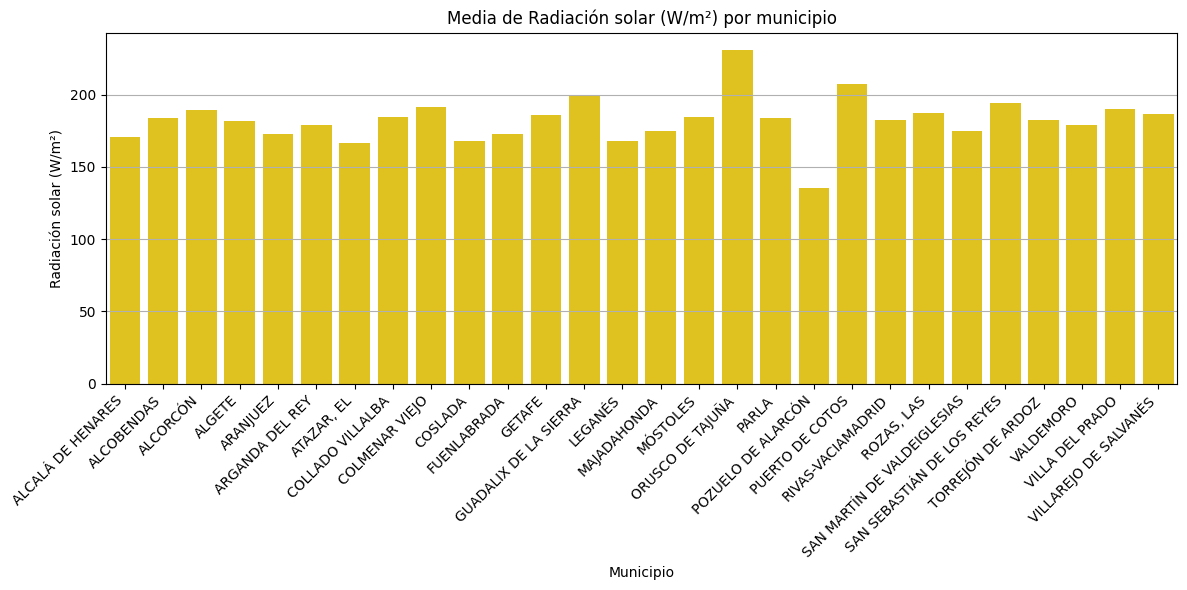

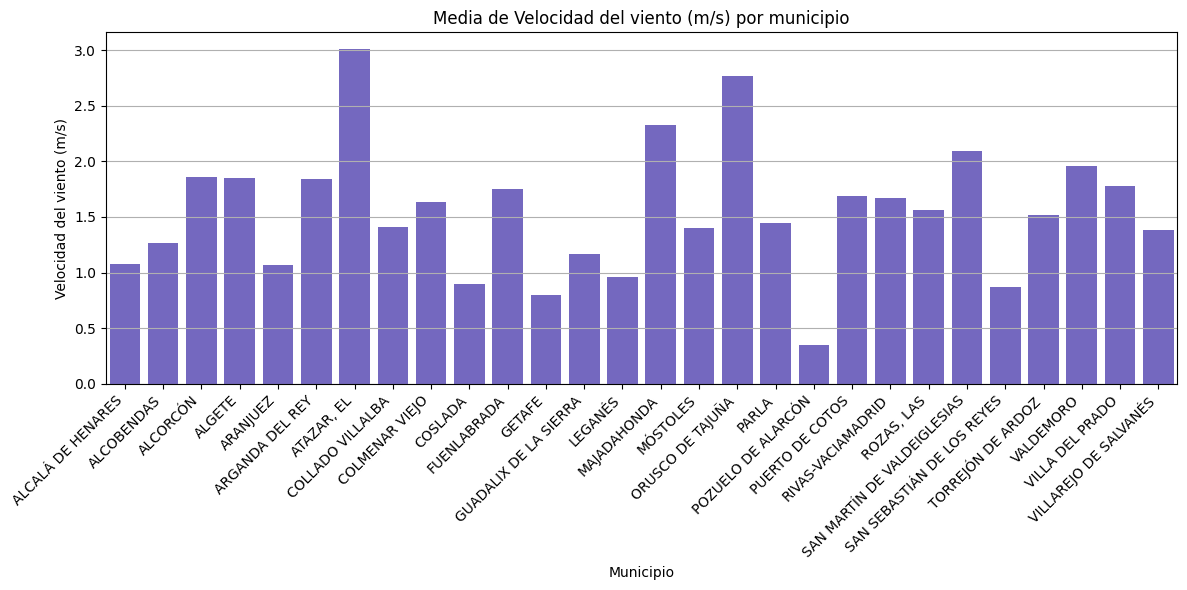

In [114]:
for medida in medidas_interes:
    data = df_meteo_grouped[df_meteo_grouped['medida'] == medida]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x='municipio', y='media', color=colores[medida])
    
    plt.title(f'Media de {medida} por municipio')
    plt.xlabel('Municipio')
    plt.ylabel(f'{medida}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

### CONCLUSIONES GENERALES A NIVEL HORARIO DE LA CALIDAD DEL AIRE
*Contaminantes*   
Los contaminantes con concentraciones horarias totales más altas son el Ozono (O3), el dióxido de nitrógeno (NO2), los óxidos de nitrógeno (NOx), y partículas PM10 y PM2.5
Los de menor concentración y presencia son los hidrocarburos no metánicos, el monóxido de carbono (CO), el benceno y el MP-Xileno.

En los más importantes se muestran patrones horarios de contaminación:
- O3: tiene picos entre el mediodía y la tarde (12:00-17:00) coincidiendo con las horas de mayor calor y sol diaria, lo que genera niveles de ozono troposférico altos.
- PM10: tiene picos de concentración durante la madrugada (3:00-6:00) y al mediodía, lo que sugiere una combinación de acumulación nocturna y posibles fuentes humanas diurnas.
- NOx (óxidos de nitrógeno): muestran dos picos principales: por la mañana (7:00-9:00) y por la tarde-noche (20:00-22:00), coincidiendo con los horarios de mayor tráfico de transportes.
- PM2.5: se observa un máximo entre las 19:00 y las 20:00, lo que también podría estar ligado al tráfico vespertino o actividades industriales.

*Municipios*   
Los municipios con mayor contaminación se concentran principalmente en el sur de la Comunidad de Madrid, donde predominan la industria, el tráfico intenso y una alta densidad de población. Una excepción es Majadahonda, en el norte, más urbana que industrial. En cambio, los municipios con menor contaminación suelen estar en el norte o en áreas periféricas cercanas a otras comunidades (no a Madrid), caracterizadas por entornos más naturales, menos tráfico y mayor influencia meteorológica. Fuenlabrada es la excepción entre los menos contaminados, pese a ser un municipio industrial del sur con alto tráfico y población

*Meteo*    
La velocidad del viento tiene máximos diarios entre mediodía y las 17h, especialmente a las 15h y mínimos diarios durante la madrugada, en particular entre 5h y 6h. Los municipios con más viento son El Atazar (norte) y varios en el sur lindando con otras comunidades. Majadahonda es la excepción (zona centro-norte).     
La temperatura tiene mínimos a las 6h (madrugada), ascenso hasta las 16h, donde se registra la máxima media y descenso gradual por la tarde y noche. Parla lidera en temperatura media (zona sur), aunque otros municipios del sur presentan valores similares. Las temperaturas más suaves se registran en municipios del norte, más naturales y de sierra.    
Humedad relativa es inversa a la temperatura, siendo más alta de madrugada, con mínimos entre las 15-16h y máximos de madrugada. Los municipios más húmedos están en el norte/noroeste, salvo  Valdemoro (sur).Los municipios menos húmedos son del sur (urbanos, industriales), con la excepción de Alcobendas (norte).     
La precipitación es muy irregular, sin un patrón horario claro, teniendo picos máximos promedios a las 8h, 16-17h y 21-23h y mínimo a las 12h. Puerto de Cotos tiene la mayor media de precipitación, que coincide con su altitud al ser puerto de montaña, y la menor precipitación se da en Alcorcón, Leganés y Algete, coincidiendo con alta temperatura y baja humedad.      
La presión atmosférica desciende de madrugada, alcanza su pico entre 10-11h, y baja hasta las 17h, luego se recupera por la tarde-noche.     
La radiación solar sube desde el amanecer, con máximos entre las 12h y 14h, y cae a cero al anochecer, manteniéndose así hasta la mañana siguiente. Los municipios con mayor radiación son Orusco de Tajuña, Puerto de Cotos, Guadalix de la Sierra (zonas altas y alejadas del centro) y el de menor radiación es Pozuelo de Alarcón, coincidiendo con más lluvia, humedad y menor altitud.


